# Compare averaged SEB

Author: Ziqi Yin

Last modified: 2024 Dec 21

Table of contents:
* [Time series of averaged SEB differences](#first-bullet)

In [28]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import xarray as xr
from scipy import stats

import cartopy
import cartopy.crs as ccrs
import numpy.ma as ma
import matplotlib.colors as colors
from statistics import mode
import pandas as pd
from scipy import signal
from cartopy.util import add_cyclic_point
from scipy import interpolate
import glob

home_dir = '/glade/work/ziqiyin/'
import sys  
sys.path.insert(0, home_dir)
sys.path.append(home_dir + 'function/')

from functions import *
#from Plot_2D import Plot_2D # To draw plots
#import matplotlib.cm as cm # To change colormap used in plots

crs_np = ccrs.NorthPolarStereo(central_longitude=0)
crs_ll = ccrs.PlateCarree()

# For unstructured grid
#import datashader as ds
#import datashader.utils as du
#import geoviews as gv
#import geoviews.feature as gf
#import holoviews as hv
#from datashader import reductions as rd, transfer_functions as tf
from holoviews.operation.datashader import datashade, rasterize, regrid
#from scipy.spatial import Delaunay
#hv.extension("bokeh")
import warnings
warnings.filterwarnings('ignore')

from matplotlib.collections import PolyCollection

# For regridding
import os
import ESMF
import xesmf as xe

# For creating ERA5 GrIS mask
import geopandas as gp
import matplotlib.patheffects as pe
import pooch
import regionmask

from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

import pyproj

In [3]:
## Parameter
g = 9.80616 #[m/s2]

## 1. Time series of averaged SEB differences <a class="anchor" id="first-bullet"></a>

MHF = SWnet + LWnet + SHF + LHF + GHF, 
where 

MHF = FSM(_ICE) + QICE_MELT*hfus
<br>
SWnet = FSDS - FSR(_ICE)
<br>
LWnet = (FLDS(_ICE) - FIRE(_ICE)) * -1 (this one is defined away from the surface, so you need to swap sign and therefore * -1)
<br>
SHF = FSH(_ICE) * -1 (same story here)
<br>
LHF = EFLX_LH_TOT(_ICE) *-1 (same story here) 
<br>
GHF = (FGR(_ICE) - MHF) *-1 (as mentioned above the sign need to be swapped here as well). 

### Read data

In [4]:
## BG iteration 7
BG7_TREFHT_JJA = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/BG7/BG7_TREFHT_JJA_yearly.nc')['TREFHT'][:]
BG7_TS_JJA = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/BG7/BG7_TS_JJA_yearly.nc')['TS'][:]
BG7_FSDS_JJA = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/BG7/BG7_FSDS_JJA_yearly.nc')['FSDS'][:]
BG7_FSA_JJA = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/BG7/BG7_FSA_JJA_yearly.nc')['FSA'][:]
BG7_FLDS_JJA = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/BG7/BG7_FLDS_JJA_yearly.nc')['FLDS'][:]
BG7_FIRA_JJA = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/BG7/BG7_FIRA_JJA_yearly.nc')['FIRA'][:]
BG7_FSH_JJA = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/BG7/BG7_FSH_JJA_yearly.nc')['FSH'][:]
BG7_EFLX_LH_TOT_JJA = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/BG7/BG7_EFLX_LH_TOT_JJA_yearly.nc')['EFLX_LH_TOT'][:]
BG7_FSM_JJA = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/BG7/BG7_FSM_JJA_yearly.nc')['FSM'][:]
BG7_FICE_MELT_JJA = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/BG7/BG7_QICE_MELT_JJA_yearly.nc')['QICE_MELT'][:] * 3.34e5 #[W/m2]
#BG7_FGR_JJA = xr.open_dataset(home_dir+'dynamic_GrIS/BG7/BG7_FGR_JJA_yearly.nc')['FGR'][:] # Var not saved, can calculate

In [5]:
## f09muntjewerf
data_dir = '/glade/derecho/scratch/ziqiyin/2022-VR-dynamic-GrIS/'

# piControl
f09_piControl_FSDS_JJA = xr.open_dataset(data_dir+'f09_FSDS_piControl_JJA_yearly.nc')['FSDS'][:]
f09_piControl_FSA_JJA = xr.open_dataset(data_dir+'f09_FSA_piControl_JJA_yearly.nc')['FSA'][:]
f09_piControl_FLDS_JJA = xr.open_dataset(data_dir+'f09_FLDS_piControl_JJA_yearly.nc')['FLDS'][:]
f09_piControl_FIRA_JJA = xr.open_dataset(data_dir+'f09_FIRA_piControl_JJA_yearly.nc')['FIRA'][:]
f09_piControl_FSH_JJA = xr.open_dataset(data_dir+'f09_FSH_piControl_JJA_yearly.nc')['FSH'][:]
f09_piControl_EFLX_LH_TOT_JJA = xr.open_dataset(data_dir+'f09_EFLX_LH_TOT_piControl_JJA_yearly.nc')['EFLX_LH_TOT'][:]
f09_piControl_FSM_JJA = xr.open_dataset(data_dir+'f09_FSM_piControl_JJA_yearly.nc')['FSM'][:]
f09_piControl_FICE_MELT_JJA = xr.open_dataset(data_dir+'f09_QICE_MELT_piControl_JJA_yearly.nc')['QICE_MELT'][:] * 3.34e5 #[W/m2]
f09_piControl_FGR_JJA = xr.open_dataset(data_dir+'f09_FGR_piControl_JJA_yearly.nc')['FGR'][:]

# 1pctCO2
f09_1pctCO2_TREFHT_JJA = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09muntjewerf/f09_TREFHT_1pctCO2_JJA_yearly.nc')['TREFHT'][:140]
f09_1pctCO2_TS_JJA = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09muntjewerf/f09_TS_1pctCO2_JJA_yearly.nc')['TS'][:140]
f09_1pctCO2_FSDS_JJA = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09muntjewerf/f09_FSDS_1pctCO2_JJA.nc')['FSDS'][:140]
f09_1pctCO2_FSA_JJA = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09muntjewerf/f09_FSA_1pctCO2_JJA.nc')['FSA'][:140]
f09_1pctCO2_FLDS_JJA = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09muntjewerf/f09_FLDS_1pctCO2_JJA.nc')['FLDS'][:140]
f09_1pctCO2_FIRA_JJA = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09muntjewerf/f09_FIRA_1pctCO2_JJA.nc')['FIRA'][:140]
f09_1pctCO2_FSH_JJA = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09muntjewerf/f09_FSH_1pctCO2_JJA.nc')['FSH'][:140]
f09_1pctCO2_EFLX_LH_TOT_JJA = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09muntjewerf/f09_EFLX_LH_TOT_1pctCO2_JJA.nc')['EFLX_LH_TOT'][:140]
f09_1pctCO2_FSM_JJA = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09muntjewerf/f09_FSM_1pctCO2_JJA.nc')['FSM'][:140]
f09_1pctCO2_FICE_MELT_JJA = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09muntjewerf/f09_QICE_MELT_1pctCO2_JJA.nc')['QICE_MELT'][:140] * 3.34e5 #[W/m2]
f09_1pctCO2_FGR_JJA = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09muntjewerf/f09_FGR_1pctCO2_JJA.nc')['FGR'][:140]
f09_1pctCO2_PHIS = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09muntjewerf/f09_PHIS_1pctCO2_JJA_yearly.nc')['PHIS'][:140]

# 4xCO2
f09_4xext_TREFHT_JJA = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09muntjewerf/f09_TREFHT_4xext_JJA_yearly.nc')['TREFHT'][:]
f09_4xext_TS_JJA = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09muntjewerf/f09_TS_4xext_JJA_yearly.nc')['TS'][:]
f09_4xext_FSDS_JJA = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09muntjewerf/f09_FSDS_4xext_JJA.nc')['FSDS'][:]
f09_4xext_FSA_JJA = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09muntjewerf/f09_FSA_4xext_JJA.nc')['FSA'][:]
f09_4xext_FLDS_JJA = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09muntjewerf/f09_FLDS_4xext_JJA.nc')['FLDS'][:]
f09_4xext_FIRA_JJA = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09muntjewerf/f09_FIRA_4xext_JJA.nc')['FIRA'][:]
f09_4xext_FSH_JJA = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09muntjewerf/f09_FSH_4xext_JJA.nc')['FSH'][:]
f09_4xext_EFLX_LH_TOT_JJA = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09muntjewerf/f09_EFLX_LH_TOT_4xext_JJA.nc')['EFLX_LH_TOT'][:]
f09_4xext_FSM_JJA = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09muntjewerf/f09_FSM_4xext_JJA.nc')['FSM'][:]
f09_4xext_FICE_MELT_JJA = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09muntjewerf/f09_QICE_MELT_4xext_JJA.nc')['QICE_MELT'][:] * 3.34e5 #[W/m2]
f09_4xext_FGR_JJA = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09muntjewerf/f09_FGR_4xext_JJA.nc')['FGR'][:]
f09_4xext_PHIS = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09muntjewerf/f09_PHIS_4xext_JJA_yearly.nc')['PHIS'][:]

In [6]:
## f09nohacks
# piControl
f09_nohacks_piControl_TREFHT_JJA = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09nohacks/f09_nohacks_TREFHT_piControl_JJA_yearly.nc')['TREFHT'][:]
f09_nohacks_piControl_TS_JJA = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09nohacks/f09_nohacks_TS_piControl_JJA_yearly.nc')['TS'][:]
f09_nohacks_piControl_FSDS_JJA = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09nohacks/f09_nohacks_FSDS_piControl_JJA_yearly.nc')['FSDS'][:]
f09_nohacks_piControl_FSR_JJA = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09nohacks/f09_nohacks_FSR_piControl_JJA_yearly.nc')['FSR'][:]
f09_nohacks_piControl_FSA_JJA = f09_nohacks_piControl_FSDS_JJA - f09_nohacks_piControl_FSR_JJA
f09_nohacks_piControl_FLDS_JJA = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09nohacks/f09_nohacks_FLDS_piControl_JJA_yearly.nc')['FLDS'][:]
f09_nohacks_piControl_FIRA_JJA = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09nohacks/f09_nohacks_FIRA_piControl_JJA_yearly.nc')['FIRA'][:]
f09_nohacks_piControl_FSH_JJA = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09nohacks/f09_nohacks_FSH_piControl_JJA_yearly.nc')['FSH'][:]
f09_nohacks_piControl_EFLX_LH_TOT_JJA = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09nohacks/f09_nohacks_EFLX_LH_TOT_piControl_JJA_yearly.nc')['EFLX_LH_TOT'][:]
f09_nohacks_piControl_FSM_JJA = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09nohacks/f09_nohacks_FSM_piControl_JJA_yearly.nc')['FSM'][:]
f09_nohacks_piControl_FICE_MELT_JJA = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09nohacks/f09_nohacks_QICE_MELT_piControl_JJA_yearly.nc')['QICE_MELT'][:] * 3.34e5 #[W/m2]
f09_nohacks_piControl_FGR_JJA = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09nohacks/f09_nohacks_FGR_piControl_JJA_yearly.nc')['FGR'][:]

# 1pctCO2
f09_nohacks_1pctCO2_TREFHT_JJA = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09nohacks/f09_nohacks_TREFHT_1pctCO2_JJA_yearly.nc')['TREFHT'][:]
f09_nohacks_1pctCO2_TS_JJA = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09nohacks/f09_nohacks_TS_1pctCO2_JJA_yearly.nc')['TS'][:]
f09_nohacks_1pctCO2_FSDS_JJA = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09nohacks/f09_nohacks_FSDS_1pctCO2_JJA_yearly.nc')['FSDS'][:]
f09_nohacks_1pctCO2_FSR_JJA = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09nohacks/f09_nohacks_FSR_1pctCO2_JJA_yearly.nc')['FSR'][:]
f09_nohacks_1pctCO2_FSA_JJA = f09_nohacks_1pctCO2_FSDS_JJA - f09_nohacks_1pctCO2_FSR_JJA
f09_nohacks_1pctCO2_FLDS_JJA = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09nohacks/f09_nohacks_FLDS_1pctCO2_JJA_yearly.nc')['FLDS'][:]
f09_nohacks_1pctCO2_FIRA_JJA = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09nohacks/f09_nohacks_FIRA_1pctCO2_JJA_yearly.nc')['FIRA'][:]
f09_nohacks_1pctCO2_FSH_JJA = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09nohacks/f09_nohacks_FSH_1pctCO2_JJA_yearly.nc')['FSH'][:]
f09_nohacks_1pctCO2_EFLX_LH_TOT_JJA = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09nohacks/f09_nohacks_EFLX_LH_TOT_1pctCO2_JJA_yearly.nc')['EFLX_LH_TOT'][:]
f09_nohacks_1pctCO2_FSM_JJA = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09nohacks/f09_nohacks_FSM_1pctCO2_JJA_yearly.nc')['FSM'][:]
f09_nohacks_1pctCO2_FICE_MELT_JJA = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09nohacks/f09_nohacks_QICE_MELT_1pctCO2_JJA_yearly.nc')['QICE_MELT'][:] * 3.34e5 #[W/m2]
f09_nohacks_1pctCO2_FGR_JJA = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09nohacks/f09_nohacks_FGR_1pctCO2_JJA_yearly.nc')['FGR'][:]
f09_nohacks_1pctCO2_PHIS = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09nohacks/f09_nohacks_PHIS_1pctCO2_JJA_yearly.nc')['PHIS'][:]

# 4xext
f09_nohacks_4xext_TREFHT_JJA = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09nohacks/f09_nohacks_TREFHT_4xext_JJA_yearly.nc')['TREFHT'][:]
f09_nohacks_4xext_TS_JJA = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09nohacks/f09_nohacks_TS_4xext_JJA_yearly.nc')['TS'][:]
f09_nohacks_4xext_FSDS_JJA = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09nohacks/f09_nohacks_FSDS_4xext_JJA_yearly.nc')['FSDS'][:]
f09_nohacks_4xext_FSR_JJA = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09nohacks/f09_nohacks_FSR_4xext_JJA_yearly.nc')['FSR'][:]
f09_nohacks_4xext_FSA_JJA = f09_nohacks_4xext_FSDS_JJA - f09_nohacks_4xext_FSR_JJA
f09_nohacks_4xext_FLDS_JJA = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09nohacks/f09_nohacks_FLDS_4xext_JJA_yearly.nc')['FLDS'][:]
f09_nohacks_4xext_FIRA_JJA = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09nohacks/f09_nohacks_FIRA_4xext_JJA_yearly.nc')['FIRA'][:]
f09_nohacks_4xext_FSH_JJA = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09nohacks/f09_nohacks_FSH_4xext_JJA_yearly.nc')['FSH'][:]
f09_nohacks_4xext_EFLX_LH_TOT_JJA = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09nohacks/f09_nohacks_EFLX_LH_TOT_4xext_JJA_yearly.nc')['EFLX_LH_TOT'][:]
f09_nohacks_4xext_FSM_JJA = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09nohacks/f09_nohacks_FSM_4xext_JJA_yearly.nc')['FSM'][:]
f09_nohacks_4xext_FICE_MELT_JJA = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09nohacks/f09_nohacks_QICE_MELT_4xext_JJA_yearly.nc')['QICE_MELT'][:] * 3.34e5 #[W/m2]
f09_nohacks_4xext_FGR_JJA = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09nohacks/f09_nohacks_FGR_4xext_JJA_yearly.nc')['FGR'][:]
f09_nohacks_4xext_PHIS = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09nohacks/f09_nohacks_PHIS_4xext_JJA_yearly.nc')['PHIS'][:]

In [7]:
## Arctic grid
# piControl
ARCTIC_piControl_p4_TREFHT_JJA = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_TREFHT_piControl_p4_JJA_yearly.nc')['TREFHT'][:]
ARCTIC_piControl_p4_TS_JJA = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_TS_piControl_p4_JJA_yearly.nc')['TS'][:]
ARCTIC_piControl_p4_FSDS_JJA = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_FSDS_piControl_p4_JJA.nc')['FSDS'][:]
ARCTIC_piControl_p4_FSA_JJA = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_FSA_piControl_p4_JJA.nc')['FSA'][:]
ARCTIC_piControl_p4_FLDS_JJA = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_FLDS_piControl_p4_JJA.nc')['FLDS'][:]
ARCTIC_piControl_p4_FIRA_JJA = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_FIRA_piControl_p4_JJA.nc')['FIRA'][:]
ARCTIC_piControl_p4_FSH_JJA = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_FSH_piControl_p4_JJA.nc')['FSH'][:]
ARCTIC_piControl_p4_EFLX_LH_TOT_JJA = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_EFLX_LH_TOT_piControl_p4_JJA.nc')['EFLX_LH_TOT'][:]
ARCTIC_piControl_p4_FSM_JJA = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_FSM_piControl_p4_JJA.nc')['FSM'][:]
ARCTIC_piControl_p4_FICE_MELT_JJA = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_QICE_MELT_piControl_p4_JJA.nc')['QICE_MELT'][:] * 3.34e5 #[W/m2]
ARCTIC_piControl_p4_FGR_JJA = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_FGR_piControl_p4_JJA.nc')['FGR'][:]

# 1pctCO2
ARCTIC_1pctCO2_TREFHT_JJA = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_TREFHT_1pctCO2_JJA_yearly.nc')['TREFHT'][:]
ARCTIC_1pctCO2_TS_JJA = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_TS_1pctCO2_JJA_yearly.nc')['TS'][:]
ARCTIC_1pctCO2_FSDS_JJA = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_FSDS_1pctCO2_JJA.nc')['FSDS'][:]
ARCTIC_1pctCO2_FSA_JJA = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_FSA_1pctCO2_JJA.nc')['FSA'][:]
ARCTIC_1pctCO2_FLDS_JJA = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_FLDS_1pctCO2_JJA.nc')['FLDS'][:]
ARCTIC_1pctCO2_FIRA_JJA = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_FIRA_1pctCO2_JJA.nc')['FIRA'][:]
ARCTIC_1pctCO2_FSH_JJA = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_FSH_1pctCO2_JJA.nc')['FSH'][:]
ARCTIC_1pctCO2_EFLX_LH_TOT_JJA = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_EFLX_LH_TOT_1pctCO2_JJA.nc')['EFLX_LH_TOT'][:]
ARCTIC_1pctCO2_FSM_JJA = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_FSM_1pctCO2_JJA.nc')['FSM'][:]
ARCTIC_1pctCO2_FICE_MELT_JJA = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_QICE_MELT_1pctCO2_JJA.nc')['QICE_MELT'][:] * 3.34e5 #[W/m2]
ARCTIC_1pctCO2_FGR_JJA = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_FGR_1pctCO2_JJA.nc')['FGR'][:]
ARCTIC_1pctCO2_PHIS = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_PHIS_1pctCO2_JJA_yearly.nc')['PHIS'][:]

# 4xext
ARCTIC_4xext_TREFHT_JJA = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_TREFHT_4xext_JJA_yearly.nc')['TREFHT'][:]
ARCTIC_4xext_TS_JJA = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_TS_4xext_JJA_yearly.nc')['TS'][:]
ARCTIC_4xext_FSDS_JJA = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_FSDS_4xext_JJA.nc')['FSDS'][:]
ARCTIC_4xext_FSA_JJA = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_FSA_4xext_JJA.nc')['FSA'][:]
ARCTIC_4xext_FLDS_JJA = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_FLDS_4xext_JJA.nc')['FLDS'][:]
ARCTIC_4xext_FIRA_JJA = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_FIRA_4xext_JJA.nc')['FIRA'][:]
ARCTIC_4xext_FSH_JJA = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_FSH_4xext_JJA.nc')['FSH'][:]
ARCTIC_4xext_EFLX_LH_TOT_JJA = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_EFLX_LH_TOT_4xext_JJA.nc')['EFLX_LH_TOT'][:]
ARCTIC_4xext_FSM_JJA = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_FSM_4xext_JJA.nc')['FSM'][:]
ARCTIC_4xext_FICE_MELT_JJA = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_QICE_MELT_4xext_JJA.nc')['QICE_MELT'][:] * 3.34e5 #[W/m2]
ARCTIC_4xext_FGR_JJA = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_FGR_4xext_JJA.nc')['FGR'][:]
ARCTIC_4xext_PHIS = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_PHIS_4xext_JJA_yearly.nc')['PHIS'][:]

In [8]:
## Area and land fraction
Re = 6371.22 * 1e3 #[m]

f09_mask_file1 = '/glade/p/cesmdata/cseg/inputdata/share/domains/domain.lnd.fv0.9x1.25_gx1v7.151020.nc'
f09_area = xr.open_dataset(f09_mask_file1)['area'] #[Radian2]
f09_area = f09_area.values * Re**2

f09_mask_file2 = '/glade/campaign/collections/cmip/CMIP6/timeseries-cmip6/b.e21.B1850G.f09_g17_gl4.CMIP6-1pctCO2to4x-withism.001/lnd/proc/tseries/month_1/b.e21.B1850G.f09_g17_gl4.CMIP6-1pctCO2to4x-withism.001.clm2.h0.RAIN.000101-005012.nc'
f09_land_frac = xr.open_dataset(f09_mask_file2)['landfrac'] #fraction of grid cell that is active

ARCTIC_mask_file1 = '/glade/p/cesmdata/cseg/inputdata/share/domains/domain.lnd.ne0np4.ARCTIC.ne30x4_tx0.1v2.200626.nc'
ARCTIC_area = xr.open_dataset(ARCTIC_mask_file1)['area'] #[Radian2]
ARCTIC_area = ARCTIC_area.values * Re**2

ARCTIC_mask_file2 = '/glade/campaign/cesm/development/amwg/aherring/cesm2_2_alpha06d.poparctic_B1850G1PCT_ne0ARCTICne30x4_g17_8192pes_220705_Nx2yrs.001/lnd/hist/cesm2_2_alpha06d.poparctic_B1850G1PCT_ne0ARCTICne30x4_g17_8192pes_220705_Nx2yrs.001.clm2.h0.0001-01.nc' #directly from clm2.h0 files
ARCTIC_land_frac = xr.open_dataset(ARCTIC_mask_file2)['landfrac']

In [9]:
## Mask
# f09
# Generate Greenland mask
#f09_mask_file1 = '/glade/work/aherring/grids/uniform-res/f09/clm_surfdata_5_0/surfdata_f09_hist_78pfts_CMIP6_simyr1979_c200430.nc'
#f09_mask_file1 = '/glade/work/aherring/grids/uniform-res/f09/clm_surfdata_5_0/surfdata_0.9x1.25_hist_78pfts_CMIP5_simyr1850_c200226.nc'
f09_mask_file1 = '/glade/work/aherring/grids/uniform-res/f09/clm_surfdata_5_0/surfdata_f09_hist_78pfts_CMIP6_simyr1850_c200429.nc'
f09_GrIS_mask0 = xr.open_dataset(f09_mask_file1)['GLACIER_REGION']
f09_GrIS_mask0 = xr.where(f09_GrIS_mask0==2, 1, np.nan)
# Glacier fraction of land area
f09_glacier_frac_piControl = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09muntjewerf/f09_PCT_LANDUNIT_piControl_yearly.nc')['PCT_LANDUNIT'][:,3,:,:]
f09_mask_file2 = '/glade/campaign/cgd/amp/aherring/archive/cam6_2_022.se_FHIST_f09_f09_mg17_1800pes_200507_mg3-Nx5yrs/lnd/hist/cam6_2_022.se_FHIST_f09_f09_mg17_1800pes_200507_mg3-Nx5yrs.clm2.h0.1979-01.nc'
f09_glacier_frac_const = xr.open_dataset(f09_mask_file2)['PCT_LANDUNIT'][0,3,:,:] #ltype_landice_multiple_elevation_classes
f09_glacier_frac_1pctCO2 = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09muntjewerf/f09_PCT_LANDUNIT_1pctCO2_yearly.nc')['PCT_LANDUNIT'][:140,3,:,:]
f09_glacier_frac_4xext = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09muntjewerf/f09_PCT_LANDUNIT_4xext_yearly.nc')['PCT_LANDUNIT'][:,3,:,:]
f09_glacier_frac = xr.concat([f09_glacier_frac_1pctCO2[:140], f09_glacier_frac_4xext], dim='time')
# Land fraction of grid cell
#f09_mask_file3 = '/glade/p/cesmdata/cseg/inputdata/share/domains/domain.lnd.fv0.9x1.25_gx1v7.151020.nc'
f09_mask_file3 = '/glade/campaign/collections/cmip/CMIP6/timeseries-cmip6/b.e21.B1850G.f09_g17_gl4.CMIP6-1pctCO2to4x-withism.001/lnd/proc/tseries/month_1/b.e21.B1850G.f09_g17_gl4.CMIP6-1pctCO2to4x-withism.001.clm2.h0.RAIN.000101-005012.nc'
f09_land_frac = xr.open_dataset(f09_mask_file3)['landfrac'] #fraction of grid cell that is active
f09_GrIS_mask_piControl = f09_GrIS_mask0.values * f09_glacier_frac_piControl.values * f09_land_frac.values / 100
f09_GrIS_mask_const = f09_GrIS_mask0.values * f09_glacier_frac_const.values * f09_land_frac.values / 100
f09_GrIS_mask = f09_GrIS_mask0.values * f09_glacier_frac.values * f09_land_frac.values / 100

# f09nohacks
f09_nohacks_glacier_frac_piControl = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09nohacks/f09_nohacks_PCT_LANDUNIT_piControl_yearly.nc')['PCT_LANDUNIT'][:,3,:,:]
f09_nohacks_GrIS_mask_piControl = f09_GrIS_mask0.values * f09_nohacks_glacier_frac_piControl.values * f09_land_frac.values / 100
f09_nohacks_glacier_frac_1pctCO2 = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09nohacks/f09_nohacks_PCT_LANDUNIT_1pctCO2_yearly.nc')['PCT_LANDUNIT'][:,3,:,:]
f09_nohacks_glacier_frac_4xext = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09nohacks/f09_nohacks_PCT_LANDUNIT_4xext_yearly.nc')['PCT_LANDUNIT'][:,3,:,:]
f09_nohacks_glacier_frac = xr.concat([f09_nohacks_glacier_frac_1pctCO2, f09_nohacks_glacier_frac_4xext], dim='time')
f09_nohacks_GrIS_mask = f09_GrIS_mask0.values * f09_nohacks_glacier_frac.values * f09_land_frac.values / 100

# BG7
BG7_glacier_frac = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/BG7/BG7_PCT_LANDUNIT_yearly.nc')['PCT_LANDUNIT'][:,3,:,:]
BG7_GrIS_mask = f09_GrIS_mask0.values * BG7_glacier_frac.values * f09_land_frac.values / 100

# ARCTIC
# Generate Greenland mask
#ARCTIC_mask_file1 = '/glade/work/aherring/grids/var-res/ne0np4.ARCTIC.ne30x4/clm_surfdata_5_0/surfdata_ne0np4.ARCTIC.ne30x4_hist_78pfts_CMIP6_simyr2000_c200426.nc' #get same result
ARCTIC_mask_file1 = '/glade/work/aherring/grids/var-res/ne0np4.ARCTIC.ne30x4/clm_surfdata_5_0/surfdata_ne0np4.ARCTIC.ne30x4_hist_78pfts_CMIP6_simyr1850_c200426.nc'
ARCTIC_GrIS_mask0 = xr.open_dataset(ARCTIC_mask_file1)['GLACIER_REGION']
ARCTIC_GrIS_mask0 = xr.where(ARCTIC_GrIS_mask0==2, 1, np.nan)
# Glacier fraction of land area
ARCTIC_glacier_frac_piControl_p1 = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_PCT_LANDUNIT_piControl_p1_yearly.nc')['PCT_LANDUNIT'][:,3,:]
ARCTIC_glacier_frac_piControl_p2 = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_PCT_LANDUNIT_piControl_p2_yearly.nc')['PCT_LANDUNIT'][:,3,:]
ARCTIC_glacier_frac_piControl_p3 = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_PCT_LANDUNIT_piControl_p3_yearly.nc')['PCT_LANDUNIT'][:,3,:]
ARCTIC_glacier_frac_piControl_p4 = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_PCT_LANDUNIT_piControl_p4_yearly.nc')['PCT_LANDUNIT'][:,3,:]
ARCTIC_glacier_frac_piControl = xr.concat([ARCTIC_glacier_frac_piControl_p1, ARCTIC_glacier_frac_piControl_p2, ARCTIC_glacier_frac_piControl_p3, ARCTIC_glacier_frac_piControl_p4], dim='time')
ARCTIC_mask_file2 = '/glade/campaign/cgd/amp/aherring/archive/cam6_2_022.se_FHIST_ne0np4.ARCTIC.ne30x4_mt12_7680pes_200507_mg3-Nx2yrs/lnd/hist/cam6_2_022.se_FHIST_ne0np4.ARCTIC.ne30x4_mt12_7680pes_200507_mg3-Nx2yrs.clm2.h0.1979-01.nc'
ARCTIC_glacier_frac_const = xr.open_dataset(ARCTIC_mask_file2)['PCT_LANDUNIT'][0,3,:]
ARCTIC_glacier_frac_1pctCO2 = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_PCT_LANDUNIT_1pctCO2_yearly.nc')['PCT_LANDUNIT'][:,3,:]
ARCTIC_glacier_frac_4xext = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_PCT_LANDUNIT_4xext_yearly.nc')['PCT_LANDUNIT'][:,3,:]
ARCTIC_glacier_frac = xr.concat([ARCTIC_glacier_frac_1pctCO2, ARCTIC_glacier_frac_4xext], dim='time')
# Land fraction of grid cell
#ARCTIC_mask_file3 = '/glade/p/cesmdata/cseg/inputdata/share/domains/domain.lnd.ne0np4.ARCTIC.ne30x4_tx0.1v2.200626.nc' #Wrong domain, it is for B case
#ARCTIC_mask_file3 = '/glade/work/aherring/grids/var-res/ne0np4.ARCTIC.ne30x4/domains/domain.lnd.ne0np4.ARCTIC.ne30x4_gx1v7.200817.nc' #domain file with ['frac']
ARCTIC_mask_file3 = '/glade/campaign/cesm/development/amwg/aherring/cesm2_2_alpha06d.poparctic_B1850G1PCT_ne0ARCTICne30x4_g17_8192pes_220705_Nx2yrs.001/lnd/hist/cesm2_2_alpha06d.poparctic_B1850G1PCT_ne0ARCTICne30x4_g17_8192pes_220705_Nx2yrs.001.clm2.h0.0001-01.nc' #directly from clm2.h0 files
ARCTIC_land_frac = xr.open_dataset(ARCTIC_mask_file3)['landfrac']
ARCTIC_GrIS_mask_piControl = ARCTIC_GrIS_mask0.values * ARCTIC_glacier_frac_piControl.values * ARCTIC_land_frac.values / 100
ARCTIC_GrIS_mask_const = ARCTIC_GrIS_mask0.values * ARCTIC_glacier_frac_const.values * ARCTIC_land_frac.values / 100
ARCTIC_GrIS_mask = ARCTIC_GrIS_mask0.values * ARCTIC_glacier_frac.values * ARCTIC_land_frac.values / 100
#ARCTIC_GrIS_mask_v2 = ARCTIC_GrIS_mask0.values * ARCTIC_glacier_frac.values / 100

In [10]:
## Concat
f09_1pctCO2_4xext_TREFHT_JJA = xr.concat([f09_1pctCO2_TREFHT_JJA, f09_4xext_TREFHT_JJA], dim='time')
f09_1pctCO2_4xext_TS_JJA = xr.concat([f09_1pctCO2_TS_JJA, f09_4xext_TS_JJA], dim='time')
f09_1pctCO2_4xext_FSDS_JJA = xr.concat([f09_1pctCO2_FSDS_JJA, f09_4xext_FSDS_JJA], dim='time')
f09_1pctCO2_4xext_FSA_JJA = xr.concat([f09_1pctCO2_FSA_JJA, f09_4xext_FSA_JJA], dim='time')
f09_1pctCO2_4xext_FLDS_JJA = xr.concat([f09_1pctCO2_FLDS_JJA, f09_4xext_FLDS_JJA], dim='time')
f09_1pctCO2_4xext_FIRA_JJA = xr.concat([f09_1pctCO2_FIRA_JJA, f09_4xext_FIRA_JJA], dim='time')
f09_1pctCO2_4xext_FSH_JJA = xr.concat([f09_1pctCO2_FSH_JJA, f09_4xext_FSH_JJA], dim='time')
f09_1pctCO2_4xext_EFLX_LH_TOT_JJA = xr.concat([f09_1pctCO2_EFLX_LH_TOT_JJA, f09_4xext_EFLX_LH_TOT_JJA], dim='time')
f09_1pctCO2_4xext_FSM_JJA = xr.concat([f09_1pctCO2_FSM_JJA, f09_4xext_FSM_JJA], dim='time')
f09_1pctCO2_4xext_FICE_MELT_JJA = xr.concat([f09_1pctCO2_FICE_MELT_JJA, f09_4xext_FICE_MELT_JJA], dim='time')
f09_1pctCO2_4xext_FGR_JJA = xr.concat([f09_1pctCO2_FGR_JJA, f09_4xext_FGR_JJA], dim='time')
f09_1pctCO2_4xext_PHIS = xr.concat([f09_1pctCO2_PHIS, f09_4xext_PHIS], dim='time')

f09_nohacks_1pctCO2_4xext_TREFHT_JJA = xr.concat([f09_nohacks_1pctCO2_TREFHT_JJA, f09_nohacks_4xext_TREFHT_JJA], dim='time')
f09_nohacks_1pctCO2_4xext_TS_JJA = xr.concat([f09_nohacks_1pctCO2_TS_JJA, f09_nohacks_4xext_TS_JJA], dim='time')
f09_nohacks_1pctCO2_4xext_FSDS_JJA = xr.concat([f09_nohacks_1pctCO2_FSDS_JJA, f09_nohacks_4xext_FSDS_JJA], dim='time')
f09_nohacks_1pctCO2_4xext_FSA_JJA = xr.concat([f09_nohacks_1pctCO2_FSA_JJA, f09_nohacks_4xext_FSA_JJA], dim='time')
f09_nohacks_1pctCO2_4xext_FLDS_JJA = xr.concat([f09_nohacks_1pctCO2_FLDS_JJA, f09_nohacks_4xext_FLDS_JJA], dim='time')
f09_nohacks_1pctCO2_4xext_FIRA_JJA = xr.concat([f09_nohacks_1pctCO2_FIRA_JJA, f09_nohacks_4xext_FIRA_JJA], dim='time')
f09_nohacks_1pctCO2_4xext_FSH_JJA = xr.concat([f09_nohacks_1pctCO2_FSH_JJA, f09_nohacks_4xext_FSH_JJA], dim='time')
f09_nohacks_1pctCO2_4xext_EFLX_LH_TOT_JJA = xr.concat([f09_nohacks_1pctCO2_EFLX_LH_TOT_JJA, f09_nohacks_4xext_EFLX_LH_TOT_JJA], dim='time')
f09_nohacks_1pctCO2_4xext_FSM_JJA = xr.concat([f09_nohacks_1pctCO2_FSM_JJA, f09_nohacks_4xext_FSM_JJA], dim='time')
f09_nohacks_1pctCO2_4xext_FICE_MELT_JJA = xr.concat([f09_nohacks_1pctCO2_FICE_MELT_JJA, f09_nohacks_4xext_FICE_MELT_JJA], dim='time')
f09_nohacks_1pctCO2_4xext_FGR_JJA = xr.concat([f09_nohacks_1pctCO2_FGR_JJA, f09_nohacks_4xext_FGR_JJA], dim='time')
f09_nohacks_1pctCO2_4xext_PHIS = xr.concat([f09_nohacks_1pctCO2_PHIS, f09_nohacks_4xext_PHIS], dim='time')

ARCTIC_1pctCO2_4xext_TREFHT_JJA = xr.concat([ARCTIC_1pctCO2_TREFHT_JJA, ARCTIC_4xext_TREFHT_JJA], dim='time')
ARCTIC_1pctCO2_4xext_TS_JJA = xr.concat([ARCTIC_1pctCO2_TS_JJA, ARCTIC_4xext_TS_JJA], dim='time')
ARCTIC_1pctCO2_4xext_FSDS_JJA = xr.concat([ARCTIC_1pctCO2_FSDS_JJA, ARCTIC_4xext_FSDS_JJA], dim='time')
ARCTIC_1pctCO2_4xext_FSA_JJA = xr.concat([ARCTIC_1pctCO2_FSA_JJA, ARCTIC_4xext_FSA_JJA], dim='time')
ARCTIC_1pctCO2_4xext_FLDS_JJA = xr.concat([ARCTIC_1pctCO2_FLDS_JJA, ARCTIC_4xext_FLDS_JJA], dim='time')
ARCTIC_1pctCO2_4xext_FIRA_JJA = xr.concat([ARCTIC_1pctCO2_FIRA_JJA, ARCTIC_4xext_FIRA_JJA], dim='time')
ARCTIC_1pctCO2_4xext_FSH_JJA = xr.concat([ARCTIC_1pctCO2_FSH_JJA, ARCTIC_4xext_FSH_JJA], dim='time')
ARCTIC_1pctCO2_4xext_EFLX_LH_TOT_JJA = xr.concat([ARCTIC_1pctCO2_EFLX_LH_TOT_JJA, ARCTIC_4xext_EFLX_LH_TOT_JJA], dim='time')
ARCTIC_1pctCO2_4xext_FSM_JJA = xr.concat([ARCTIC_1pctCO2_FSM_JJA, ARCTIC_4xext_FSM_JJA], dim='time')
ARCTIC_1pctCO2_4xext_FICE_MELT_JJA = xr.concat([ARCTIC_1pctCO2_FICE_MELT_JJA, ARCTIC_4xext_FICE_MELT_JJA], dim='time')
ARCTIC_1pctCO2_4xext_FGR_JJA = xr.concat([ARCTIC_1pctCO2_FGR_JJA, ARCTIC_4xext_FGR_JJA], dim='time')
ARCTIC_1pctCO2_4xext_PHIS = xr.concat([ARCTIC_1pctCO2_PHIS, ARCTIC_4xext_PHIS], dim='time')

In [11]:
## Calculate variables
BG7_albedo_JJA = (BG7_FSDS_JJA - BG7_FSA_JJA) / BG7_FSDS_JJA
BG7_ME_JJA = BG7_FSM_JJA + BG7_FICE_MELT_JJA
#BG7_GHF_JJA = BG7_ME_JJA - BG7_FGR_JJA
BG7_GHF_JJA = BG7_ME_JJA - BG7_FSA_JJA + BG7_FIRA_JJA + BG7_FSH_JJA + BG7_EFLX_LH_TOT_JJA

f09_piControl_albedo_JJA = (f09_piControl_FSDS_JJA - f09_piControl_FSA_JJA) / f09_piControl_FSDS_JJA
f09_piControl_ME_JJA = f09_piControl_FSM_JJA + f09_piControl_FICE_MELT_JJA
f09_piControl_GHF_JJA = f09_piControl_ME_JJA - f09_piControl_FGR_JJA
f09_1pctCO2_4xext_albedo_JJA = (f09_1pctCO2_4xext_FSDS_JJA - f09_1pctCO2_4xext_FSA_JJA) / f09_1pctCO2_4xext_FSDS_JJA
f09_1pctCO2_4xext_ME_JJA = f09_1pctCO2_4xext_FSM_JJA + f09_1pctCO2_4xext_FICE_MELT_JJA
f09_1pctCO2_4xext_GHF_JJA = f09_1pctCO2_4xext_ME_JJA - f09_1pctCO2_4xext_FGR_JJA
f09_1pctCO2_4xext_elev = f09_1pctCO2_4xext_PHIS / g

f09_nohacks_piControl_albedo_JJA = (f09_nohacks_piControl_FSDS_JJA - f09_nohacks_piControl_FSA_JJA) / f09_nohacks_piControl_FSDS_JJA
f09_nohacks_piControl_ME_JJA = f09_nohacks_piControl_FSM_JJA + f09_nohacks_piControl_FICE_MELT_JJA
f09_nohacks_piControl_GHF_JJA = f09_nohacks_piControl_ME_JJA - f09_nohacks_piControl_FGR_JJA
f09_nohacks_1pctCO2_4xext_albedo_JJA = (f09_nohacks_1pctCO2_4xext_FSDS_JJA - f09_nohacks_1pctCO2_4xext_FSA_JJA) / f09_nohacks_1pctCO2_4xext_FSDS_JJA
f09_nohacks_1pctCO2_4xext_ME_JJA = f09_nohacks_1pctCO2_4xext_FSM_JJA + f09_nohacks_1pctCO2_4xext_FICE_MELT_JJA
f09_nohacks_1pctCO2_4xext_GHF_JJA = f09_nohacks_1pctCO2_4xext_ME_JJA - f09_nohacks_1pctCO2_4xext_FGR_JJA
f09_nohacks_1pctCO2_4xext_elev = f09_nohacks_1pctCO2_4xext_PHIS / g

ARCTIC_piControl_p4_albedo_JJA = (ARCTIC_piControl_p4_FSDS_JJA - ARCTIC_piControl_p4_FSA_JJA) / ARCTIC_piControl_p4_FSDS_JJA
ARCTIC_piControl_p4_ME_JJA = ARCTIC_piControl_p4_FSM_JJA + ARCTIC_piControl_p4_FICE_MELT_JJA
ARCTIC_piControl_p4_GHF_JJA = ARCTIC_piControl_p4_ME_JJA - ARCTIC_piControl_p4_FGR_JJA
ARCTIC_1pctCO2_4xext_albedo_JJA = (ARCTIC_1pctCO2_4xext_FSDS_JJA - ARCTIC_1pctCO2_4xext_FSA_JJA) / ARCTIC_1pctCO2_4xext_FSDS_JJA
ARCTIC_1pctCO2_4xext_ME_JJA = ARCTIC_1pctCO2_4xext_FSM_JJA + ARCTIC_1pctCO2_4xext_FICE_MELT_JJA
ARCTIC_1pctCO2_4xext_GHF_JJA = ARCTIC_1pctCO2_4xext_ME_JJA - ARCTIC_1pctCO2_4xext_FGR_JJA
ARCTIC_1pctCO2_4xext_elev = ARCTIC_1pctCO2_4xext_PHIS / g

### Regrid ARCTIC SWd and ice sheet mask to f09 grid

In [12]:
# Scrip files (contains grid information)
# From github page and more in /glade/work/aherring/grids/SCRIP_files/
scrip_fname_f09 = home_dir + 'data/gridfile/fv0.9x1.25_scrip_141008.nc'
scrip_fname_ARCTIC = home_dir + 'data/gridfile/ne0ARCTICne30x4_scrip_191212.nc'

f09_scrip = xr.open_dataset(scrip_fname_f09)
ARCTIC_scrip = xr.open_dataset(scrip_fname_ARCTIC)

In [13]:
# f09
f09_lon_centers = np.array(f09_scrip.grid_center_lon).reshape((192, 288)).T
f09_lat_centers = np.array(f09_scrip.grid_center_lat).reshape((192, 288)).T
f09_centers = np.stack((f09_lon_centers, f09_lat_centers))

f09_lon_corner = np.copy(f09_scrip.grid_corner_lon[:288,0])
f09_lon_corner = np.append(f09_lon_corner, f09_scrip.grid_corner_lon[-1,2])
f09_lon_corners = np.tile(f09_lon_corner, (193, 1)).T #(289, 193)
f09_lat_corner = np.copy(f09_scrip.grid_corner_lat[::288,0])
f09_lat_corner = np.append(f09_lat_corner, f09_scrip.grid_corner_lat[-1,2])
f09_lat_corners = np.tile(f09_lat_corner, (289, 1)) #(289, 193)
f09_corners = np.stack((f09_lon_corners, f09_lat_corners))

In [14]:
ESMF.Manager(debug=True);

In [15]:
def regrid_con_mesh_to_grid(filenm_meshin, precip_meshin, centers_gridout, corners_gridout): 

    # Set up directories
    DATADIR1 = home_dir + 'data/gridfile/'
    filenm_gridout = 'f19_PRECC_yearmonmean_shifttime.nc'

    meshin = ESMF.Mesh(filename=os.path.join(DATADIR1, filenm_meshin), filetype=ESMF.FileFormat.SCRIP)
    srcfield = ESMF.Field(meshin, meshloc=ESMF.MeshLoc.ELEMENT)
    srcfield.data[:] = precip_meshin.T #kg m-2 s-1

    # Output grid
    gridout = ESMF.Grid(np.array(centers_gridout[0,:,:].shape), staggerloc=[ESMF.StaggerLoc.CENTER, ESMF.StaggerLoc.CORNER], coord_sys=ESMF.CoordSys.SPH_DEG)
    gridout_lon = gridout.get_coords(0, staggerloc=ESMF.StaggerLoc.CENTER)
    gridout_lat = gridout.get_coords(1, staggerloc=ESMF.StaggerLoc.CENTER)
    gridout_lon[...] = centers_gridout[0]
    gridout_lat[...] = centers_gridout[1]
    gridout_lon_cor = gridout.get_coords(0, staggerloc=ESMF.StaggerLoc.CORNER)
    gridout_lat_cor = gridout.get_coords(1, staggerloc=ESMF.StaggerLoc.CORNER)
    gridout_lon_cor[...] = corners_gridout[0]
    gridout_lat_cor[...] = corners_gridout[1]
    dstfield = ESMF.Field(gridout)
    dstfield.data[:] = 1e20

    # Compute the weight matrix for regridding
    regrid = ESMF.Regrid(srcfield, dstfield,
                          regrid_method=ESMF.RegridMethod.CONSERVE,
                          unmapped_action=ESMF.UnmappedAction.IGNORE)

    # Calculate the regridding from source to destination field
    outfield = regrid(srcfield, dstfield)
    outfield_data = outfield.data.T

    return outfield_data

In [25]:
ARCTIC2f09_GrIS_mask = f09_GrIS_mask * 0

for i in range(350):
    ARCTIC2f09_GrIS_mask[i,:,:] = regrid_con_mesh_to_grid('ne0ARCTICne30x4_scrip_191212.nc', ARCTIC_GrIS_mask[i,:], f09_centers, f09_corners)

In [33]:
# Save as netcdf file
time = f09_1pctCO2_4xext_FSDS_JJA.time.values
f09_lon = f09_1pctCO2_FSDS_JJA.lon.values
f09_lat = f09_1pctCO2_FSDS_JJA.lat.values

df = xr.DataArray(ARCTIC2f09_GrIS_mask, dims=['time', 'lat', 'lon'], coords=[('time', time),('lat', f09_lat),('lon', f09_lon)], name='GrIS_mask', attrs=dict(longname='ARCTIC GrIS mask remapped to f09 grid', units=''))
df.to_netcdf(home_dir+'2022-VR-dynamic-GrIS/ARCTIC2f09_1pctCO2_4xext_GrIS_mask.nc')

In [17]:
ARCTIC2f09_1pctCO2_4xext_FSDS_JJA = f09_1pctCO2_4xext_FSDS_JJA.values * 0

for i in range(350):
    ARCTIC2f09_1pctCO2_4xext_FSDS_JJA[i,:,:] = regrid_con_mesh_to_grid('ne0ARCTICne30x4_scrip_191212.nc', ARCTIC_1pctCO2_4xext_FSDS_JJA.values[i,:], f09_centers, f09_corners)

In [18]:
# Save as netcdf file
time = f09_1pctCO2_4xext_FSDS_JJA.time.values
f09_lon = f09_1pctCO2_FSDS_JJA.lon.values
f09_lat = f09_1pctCO2_FSDS_JJA.lat.values

df = xr.DataArray(ARCTIC2f09_1pctCO2_4xext_FSDS_JJA, dims=['time', 'lat', 'lon'], coords=[('time', time),('lat', f09_lat),('lon', f09_lon)], name='FSDS', attrs=dict(longname='JJA-mean ARCTIC downward SW radiation at surface remapped to f09 grid', units='W/m2'))
df.to_netcdf(home_dir+'2022-VR-dynamic-GrIS/ARCTIC2f09_1pctCO2_4xext_FSDS_JJA.nc')

In [12]:
# Read from saved netcdf
ARCTIC2f09_GrIS_mask_read = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/ARCTIC2f09_1pctCO2_4xext_GrIS_mask.nc')['GrIS_mask'].values
ARCTIC2f09_1pctCO2_4xext_FSDS_JJA_read = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/ARCTIC2f09_1pctCO2_4xext_FSDS_JJA.nc')['FSDS']

#### piControl

In [71]:
ARCTIC2f09_GrIS_mask_piControl30 = f09_nohacks_GrIS_mask_piControl[-30:,:,:] * 0

for i in range(30):
    ARCTIC2f09_GrIS_mask_piControl30[i,:,:] = regrid_con_mesh_to_grid('ne0ARCTICne30x4_scrip_191212.nc', ARCTIC_GrIS_mask_piControl[-30+i,:], f09_centers, f09_corners)

In [76]:
# Save as netcdf file
time = f09_1pctCO2_4xext_FSDS_JJA[:30].time.values
f09_lon = f09_1pctCO2_FSDS_JJA.lon.values
f09_lat = f09_1pctCO2_FSDS_JJA.lat.values

df = xr.DataArray(ARCTIC2f09_GrIS_mask_piControl30, dims=['time', 'lat', 'lon'], coords=[('time', time),('lat', f09_lat),('lon', f09_lon)], name='GrIS_mask', attrs=dict(longname='ARCTIC GrIS mask remapped to f09 grid', units=''))
df.to_netcdf(home_dir+'2022-VR-dynamic-GrIS/ARCTIC2f09_piControl30_GrIS_mask.nc')

In [74]:
ARCTIC2f09_piControl30_FSDS_JJA = f09_nohacks_piControl_FSDS_JJA[-30:,:,:].values * 0

for i in range(30):
    ARCTIC2f09_piControl30_FSDS_JJA[i,:,:] = regrid_con_mesh_to_grid('ne0ARCTICne30x4_scrip_191212.nc', ARCTIC_piControl_p4_FSDS_JJA.values[-30+i,:], f09_centers, f09_corners)

In [77]:
# Save as netcdf file
time = f09_1pctCO2_4xext_FSDS_JJA[:30].time.values
f09_lon = f09_1pctCO2_FSDS_JJA.lon.values
f09_lat = f09_1pctCO2_FSDS_JJA.lat.values

df = xr.DataArray(ARCTIC2f09_piControl30_FSDS_JJA, dims=['time', 'lat', 'lon'], coords=[('time', time),('lat', f09_lat),('lon', f09_lon)], name='FSDS', attrs=dict(longname='JJA-mean ARCTIC downward SW radiation at surface remapped to f09 grid', units='W/m2'))
df.to_netcdf(home_dir+'2022-VR-dynamic-GrIS/ARCTIC2f09_piControl30_FSDS_JJA.nc')

In [13]:
# Read from saved netcdf
ARCTIC2f09_GrIS_mask_piControl30 = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/ARCTIC2f09_piControl30_GrIS_mask.nc')['GrIS_mask'].values
ARCTIC2f09_piControl30_FSDS_JJA = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/ARCTIC2f09_piControl30_FSDS_JJA.nc')['FSDS']

### Calculate

#### If only consider ice landunits (ice fraction = 1)

In [55]:
# If only consider 100% ice grids
BG7_GrIS_mask = np.where(BG7_GrIS_mask==1, BG7_GrIS_mask, np.NaN)
f09_GrIS_mask = np.where(f09_GrIS_mask==1, f09_GrIS_mask, np.NaN)

f09_nohacks_GrIS_mask_piControl = np.where(f09_nohacks_GrIS_mask_piControl==1, f09_nohacks_GrIS_mask_piControl, np.NaN)
f09_nohacks_GrIS_mask = np.where(f09_nohacks_GrIS_mask==1, f09_nohacks_GrIS_mask, np.NaN)

ARCTIC_GrIS_mask_piControl = np.where(ARCTIC_GrIS_mask_piControl==1, ARCTIC_GrIS_mask_piControl, np.NaN)
ARCTIC_GrIS_mask = np.where(ARCTIC_GrIS_mask==1, ARCTIC_GrIS_mask, np.NaN)

In [58]:
ARCTIC2f09_GrIS_mask_read = np.where(ARCTIC2f09_GrIS_mask_read==1, ARCTIC2f09_GrIS_mask_read, np.NaN)
ARCTIC2f09_GrIS_mask_piControl30 = np.where(ARCTIC2f09_GrIS_mask_piControl30==1, ARCTIC2f09_GrIS_mask_piControl30, np.NaN)

#### Otherwise

In [16]:
## Average over the GrIS, also change signs
# F09M
BG7_GrIS_area = np.nansum(BG7_GrIS_mask * f09_area, axis=(1,2))
BG7_avg_albedo_JJA = (BG7_albedo_JJA * BG7_GrIS_mask * f09_area).sum(dim=['lat','lon']) / BG7_GrIS_area
BG7_avg_TREFHT_JJA = (BG7_TREFHT_JJA * BG7_GrIS_mask * f09_area).sum(dim=['lat','lon']) / BG7_GrIS_area - 273.15
BG7_avg_TS_JJA = (BG7_TS_JJA * BG7_GrIS_mask * f09_area).sum(dim=['lat','lon']) / BG7_GrIS_area - 273.15
BG7_avg_SWd_JJA = (BG7_FSDS_JJA * BG7_GrIS_mask * f09_area).sum(dim=['lat','lon']) / BG7_GrIS_area
BG7_avg_LWd_JJA = (BG7_FLDS_JJA * BG7_GrIS_mask * f09_area).sum(dim=['lat','lon']) / BG7_GrIS_area
BG7_avg_ME_JJA = (BG7_ME_JJA * BG7_GrIS_mask * f09_area).sum(dim=['lat','lon']) / BG7_GrIS_area
BG7_avg_SWn_JJA = (BG7_FSA_JJA * BG7_GrIS_mask * f09_area).sum(dim=['lat','lon']) / BG7_GrIS_area
BG7_avg_LWn_JJA = -(BG7_FIRA_JJA * BG7_GrIS_mask * f09_area).sum(dim=['lat','lon']) / BG7_GrIS_area
BG7_avg_SHF_JJA = -(BG7_FSH_JJA * BG7_GrIS_mask * f09_area).sum(dim=['lat','lon']) / BG7_GrIS_area
BG7_avg_LHF_JJA = -(BG7_EFLX_LH_TOT_JJA * BG7_GrIS_mask * f09_area).sum(dim=['lat','lon']) / BG7_GrIS_area
BG7_avg_GHF_JJA = (BG7_GHF_JJA * BG7_GrIS_mask * f09_area).sum(dim=['lat','lon']) / BG7_GrIS_area

f09_piControl_GrIS_area = np.nansum(f09_GrIS_mask_piControl * f09_area, axis=(1,2))
f09_piControl_avg_albedo_JJA = (f09_piControl_albedo_JJA * f09_GrIS_mask_piControl * f09_area).sum(dim=['lat','lon']) / f09_piControl_GrIS_area
#f09_piControl_avg_TREFHT_JJA = (f09_piControl_TREFHT_JJA * f09_GrIS_mask_piControl * f09_area).sum(dim=['lat','lon']) / f09_piControl_GrIS_area - 273.15
#f09_piControl_avg_TS_JJA = (f09_piControl_TS_JJA * f09_GrIS_mask_piControl * f09_area).sum(dim=['lat','lon']) / f09_piControl_GrIS_area - 273.15
f09_piControl_avg_SWd_JJA = (f09_piControl_FSDS_JJA * f09_GrIS_mask_piControl * f09_area).sum(dim=['lat','lon']) / f09_piControl_GrIS_area
f09_piControl_avg_LWd_JJA = (f09_piControl_FLDS_JJA * f09_GrIS_mask_piControl * f09_area).sum(dim=['lat','lon']) / f09_piControl_GrIS_area
f09_piControl_avg_ME_JJA = (f09_piControl_ME_JJA * f09_GrIS_mask_piControl * f09_area).sum(dim=['lat','lon']) / f09_piControl_GrIS_area
f09_piControl_avg_SWn_JJA = (f09_piControl_FSA_JJA * f09_GrIS_mask_piControl * f09_area).sum(dim=['lat','lon']) / f09_piControl_GrIS_area
f09_piControl_avg_LWn_JJA = -(f09_piControl_FIRA_JJA * f09_GrIS_mask_piControl * f09_area).sum(dim=['lat','lon']) / f09_piControl_GrIS_area
f09_piControl_avg_SHF_JJA = -(f09_piControl_FSH_JJA * f09_GrIS_mask_piControl * f09_area).sum(dim=['lat','lon']) / f09_piControl_GrIS_area
f09_piControl_avg_LHF_JJA = -(f09_piControl_EFLX_LH_TOT_JJA * f09_GrIS_mask_piControl * f09_area).sum(dim=['lat','lon']) / f09_piControl_GrIS_area
f09_piControl_avg_GHF_JJA = (f09_piControl_GHF_JJA * f09_GrIS_mask_piControl * f09_area).sum(dim=['lat','lon']) / f09_piControl_GrIS_area

f09_1pctCO2_4xext_GrIS_area = np.nansum(f09_GrIS_mask * f09_area, axis=(1,2))
f09_1pctCO2_4xext_avg_albedo_JJA = (f09_1pctCO2_4xext_albedo_JJA * f09_GrIS_mask * f09_area).sum(dim=['lat','lon']) / f09_1pctCO2_4xext_GrIS_area
f09_1pctCO2_4xext_avg_TREFHT_JJA = (f09_1pctCO2_4xext_TREFHT_JJA * f09_GrIS_mask * f09_area).sum(dim=['lat','lon']) / f09_1pctCO2_4xext_GrIS_area - 273.15
f09_1pctCO2_4xext_avg_TS_JJA = (f09_1pctCO2_4xext_TS_JJA * f09_GrIS_mask * f09_area).sum(dim=['lat','lon']) / f09_1pctCO2_4xext_GrIS_area - 273.15
f09_1pctCO2_4xext_avg_SWd_JJA = (f09_1pctCO2_4xext_FSDS_JJA * f09_GrIS_mask * f09_area).sum(dim=['lat','lon']) / f09_1pctCO2_4xext_GrIS_area
f09_1pctCO2_4xext_avg_LWd_JJA = (f09_1pctCO2_4xext_FLDS_JJA * f09_GrIS_mask * f09_area).sum(dim=['lat','lon']) / f09_1pctCO2_4xext_GrIS_area
f09_1pctCO2_4xext_avg_ME_JJA = (f09_1pctCO2_4xext_ME_JJA * f09_GrIS_mask * f09_area).sum(dim=['lat','lon']) / f09_1pctCO2_4xext_GrIS_area
f09_1pctCO2_4xext_avg_SWn_JJA = (f09_1pctCO2_4xext_FSA_JJA * f09_GrIS_mask * f09_area).sum(dim=['lat','lon']) / f09_1pctCO2_4xext_GrIS_area
f09_1pctCO2_4xext_avg_LWn_JJA = -(f09_1pctCO2_4xext_FIRA_JJA * f09_GrIS_mask * f09_area).sum(dim=['lat','lon']) / f09_1pctCO2_4xext_GrIS_area
f09_1pctCO2_4xext_avg_SHF_JJA = -(f09_1pctCO2_4xext_FSH_JJA * f09_GrIS_mask * f09_area).sum(dim=['lat','lon']) / f09_1pctCO2_4xext_GrIS_area
f09_1pctCO2_4xext_avg_LHF_JJA = -(f09_1pctCO2_4xext_EFLX_LH_TOT_JJA * f09_GrIS_mask * f09_area).sum(dim=['lat','lon']) / f09_1pctCO2_4xext_GrIS_area
f09_1pctCO2_4xext_avg_GHF_JJA = (f09_1pctCO2_4xext_GHF_JJA * f09_GrIS_mask * f09_area).sum(dim=['lat','lon']) / f09_1pctCO2_4xext_GrIS_area

#F09
f09_nohacks_piControl_GrIS_area = np.nansum(f09_nohacks_GrIS_mask_piControl * f09_area, axis=(1,2))
f09_nohacks_piControl_avg_albedo_JJA = (f09_nohacks_piControl_albedo_JJA * f09_nohacks_GrIS_mask_piControl * f09_area).sum(dim=['lat','lon']) / f09_nohacks_piControl_GrIS_area
f09_nohacks_piControl_avg_TREFHT_JJA = (f09_nohacks_piControl_TREFHT_JJA * f09_nohacks_GrIS_mask_piControl * f09_area).sum(dim=['lat','lon']) / f09_nohacks_piControl_GrIS_area - 273.15
f09_nohacks_piControl_avg_TS_JJA = (f09_nohacks_piControl_TS_JJA * f09_nohacks_GrIS_mask_piControl * f09_area).sum(dim=['lat','lon']) / f09_nohacks_piControl_GrIS_area - 273.15
f09_nohacks_piControl_avg_SWd_JJA = (f09_nohacks_piControl_FSDS_JJA * f09_nohacks_GrIS_mask_piControl * f09_area).sum(dim=['lat','lon']) / f09_nohacks_piControl_GrIS_area
f09_nohacks_piControl_avg_LWd_JJA = (f09_nohacks_piControl_FLDS_JJA * f09_nohacks_GrIS_mask_piControl * f09_area).sum(dim=['lat','lon']) / f09_nohacks_piControl_GrIS_area
f09_nohacks_piControl_avg_ME_JJA = (f09_nohacks_piControl_ME_JJA * f09_nohacks_GrIS_mask_piControl * f09_area).sum(dim=['lat','lon']) / f09_nohacks_piControl_GrIS_area
f09_nohacks_piControl_avg_SWn_JJA = (f09_nohacks_piControl_FSA_JJA * f09_nohacks_GrIS_mask_piControl * f09_area).sum(dim=['lat','lon']) / f09_nohacks_piControl_GrIS_area
f09_nohacks_piControl_avg_LWn_JJA = -(f09_nohacks_piControl_FIRA_JJA * f09_nohacks_GrIS_mask_piControl * f09_area).sum(dim=['lat','lon']) / f09_nohacks_piControl_GrIS_area
f09_nohacks_piControl_avg_SHF_JJA = -(f09_nohacks_piControl_FSH_JJA * f09_nohacks_GrIS_mask_piControl * f09_area).sum(dim=['lat','lon']) / f09_nohacks_piControl_GrIS_area
f09_nohacks_piControl_avg_LHF_JJA = -(f09_nohacks_piControl_EFLX_LH_TOT_JJA * f09_nohacks_GrIS_mask_piControl * f09_area).sum(dim=['lat','lon']) / f09_nohacks_piControl_GrIS_area
f09_nohacks_piControl_avg_GHF_JJA = (f09_nohacks_piControl_GHF_JJA * f09_nohacks_GrIS_mask_piControl * f09_area).sum(dim=['lat','lon']) / f09_nohacks_piControl_GrIS_area

f09_nohacks_1pctCO2_4xext_GrIS_area = np.nansum(f09_nohacks_GrIS_mask * f09_area, axis=(1,2))
f09_nohacks_1pctCO2_4xext_avg_albedo_JJA = (f09_nohacks_1pctCO2_4xext_albedo_JJA * f09_nohacks_GrIS_mask * f09_area).sum(dim=['lat','lon']) / f09_nohacks_1pctCO2_4xext_GrIS_area
f09_nohacks_1pctCO2_4xext_avg_TREFHT_JJA = (f09_nohacks_1pctCO2_4xext_TREFHT_JJA * f09_nohacks_GrIS_mask * f09_area).sum(dim=['lat','lon']) / f09_nohacks_1pctCO2_4xext_GrIS_area - 273.15
f09_nohacks_1pctCO2_4xext_avg_TS_JJA = (f09_nohacks_1pctCO2_4xext_TS_JJA * f09_nohacks_GrIS_mask * f09_area).sum(dim=['lat','lon']) / f09_nohacks_1pctCO2_4xext_GrIS_area - 273.15
f09_nohacks_1pctCO2_4xext_avg_SWd_JJA = (f09_nohacks_1pctCO2_4xext_FSDS_JJA * f09_nohacks_GrIS_mask * f09_area).sum(dim=['lat','lon']) / f09_nohacks_1pctCO2_4xext_GrIS_area
f09_nohacks_1pctCO2_4xext_avg_LWd_JJA = (f09_nohacks_1pctCO2_4xext_FLDS_JJA * f09_nohacks_GrIS_mask * f09_area).sum(dim=['lat','lon']) / f09_nohacks_1pctCO2_4xext_GrIS_area
f09_nohacks_1pctCO2_4xext_avg_ME_JJA = (f09_nohacks_1pctCO2_4xext_ME_JJA * f09_nohacks_GrIS_mask * f09_area).sum(dim=['lat','lon']) / f09_nohacks_1pctCO2_4xext_GrIS_area
f09_nohacks_1pctCO2_4xext_avg_SWn_JJA = (f09_nohacks_1pctCO2_4xext_FSA_JJA * f09_nohacks_GrIS_mask * f09_area).sum(dim=['lat','lon']) / f09_nohacks_1pctCO2_4xext_GrIS_area
f09_nohacks_1pctCO2_4xext_avg_LWn_JJA = -(f09_nohacks_1pctCO2_4xext_FIRA_JJA * f09_nohacks_GrIS_mask * f09_area).sum(dim=['lat','lon']) / f09_nohacks_1pctCO2_4xext_GrIS_area
f09_nohacks_1pctCO2_4xext_avg_SHF_JJA = -(f09_nohacks_1pctCO2_4xext_FSH_JJA * f09_nohacks_GrIS_mask * f09_area).sum(dim=['lat','lon']) / f09_nohacks_1pctCO2_4xext_GrIS_area
f09_nohacks_1pctCO2_4xext_avg_LHF_JJA = -(f09_nohacks_1pctCO2_4xext_EFLX_LH_TOT_JJA * f09_nohacks_GrIS_mask * f09_area).sum(dim=['lat','lon']) / f09_nohacks_1pctCO2_4xext_GrIS_area
f09_nohacks_1pctCO2_4xext_avg_GHF_JJA = (f09_nohacks_1pctCO2_4xext_GHF_JJA * f09_nohacks_GrIS_mask * f09_area).sum(dim=['lat','lon']) / f09_nohacks_1pctCO2_4xext_GrIS_area

#ARCTIC
ARCTIC_piControl_p4_GrIS_area = np.nansum(ARCTIC_GrIS_mask_piControl[-80:,:] * ARCTIC_area, axis=1)
ARCTIC_piControl_p4_avg_albedo_JJA = (ARCTIC_piControl_p4_albedo_JJA * ARCTIC_GrIS_mask_piControl[-80:,:] * ARCTIC_area).sum(dim=['lndgrid']) / ARCTIC_piControl_p4_GrIS_area
ARCTIC_piControl_p4_avg_TREFHT_JJA = (ARCTIC_piControl_p4_TREFHT_JJA * ARCTIC_GrIS_mask_piControl[-80:,:] * ARCTIC_area).sum(dim=['ncol']) / ARCTIC_piControl_p4_GrIS_area - 273.15
ARCTIC_piControl_p4_avg_TS_JJA = (ARCTIC_piControl_p4_TS_JJA * ARCTIC_GrIS_mask_piControl[-80:,:] * ARCTIC_area).sum(dim=['ncol']) / ARCTIC_piControl_p4_GrIS_area - 273.15
ARCTIC_piControl_p4_avg_SWd_JJA = (ARCTIC_piControl_p4_FSDS_JJA * ARCTIC_GrIS_mask_piControl[-80:,:] * ARCTIC_area).sum(dim=['lndgrid']) / ARCTIC_piControl_p4_GrIS_area
ARCTIC_piControl_p4_avg_LWd_JJA = (ARCTIC_piControl_p4_FLDS_JJA * ARCTIC_GrIS_mask_piControl[-80:,:] * ARCTIC_area).sum(dim=['lndgrid']) / ARCTIC_piControl_p4_GrIS_area
ARCTIC_piControl_p4_avg_ME_JJA = (ARCTIC_piControl_p4_ME_JJA * ARCTIC_GrIS_mask_piControl[-80:,:] * ARCTIC_area).sum(dim=['lndgrid']) / ARCTIC_piControl_p4_GrIS_area
ARCTIC_piControl_p4_avg_SWn_JJA = (ARCTIC_piControl_p4_FSA_JJA * ARCTIC_GrIS_mask_piControl[-80:,:] * ARCTIC_area).sum(dim=['lndgrid']) / ARCTIC_piControl_p4_GrIS_area
ARCTIC_piControl_p4_avg_LWn_JJA = -(ARCTIC_piControl_p4_FIRA_JJA * ARCTIC_GrIS_mask_piControl[-80:,:] * ARCTIC_area).sum(dim=['lndgrid']) / ARCTIC_piControl_p4_GrIS_area
ARCTIC_piControl_p4_avg_SHF_JJA = -(ARCTIC_piControl_p4_FSH_JJA * ARCTIC_GrIS_mask_piControl[-80:,:] * ARCTIC_area).sum(dim=['lndgrid']) / ARCTIC_piControl_p4_GrIS_area
ARCTIC_piControl_p4_avg_LHF_JJA = -(ARCTIC_piControl_p4_EFLX_LH_TOT_JJA * ARCTIC_GrIS_mask_piControl[-80:,:] * ARCTIC_area).sum(dim=['lndgrid']) / ARCTIC_piControl_p4_GrIS_area
ARCTIC_piControl_p4_avg_GHF_JJA = (ARCTIC_piControl_p4_GHF_JJA * ARCTIC_GrIS_mask_piControl[-80:,:] * ARCTIC_area).sum(dim=['lndgrid']) / ARCTIC_piControl_p4_GrIS_area

ARCTIC_1pctCO2_4xext_GrIS_area = np.nansum(ARCTIC_GrIS_mask * ARCTIC_area, axis=1)
ARCTIC_1pctCO2_4xext_avg_albedo_JJA = (ARCTIC_1pctCO2_4xext_albedo_JJA * ARCTIC_GrIS_mask * ARCTIC_area).sum(dim=['lndgrid']) / ARCTIC_1pctCO2_4xext_GrIS_area
ARCTIC_1pctCO2_4xext_avg_TREFHT_JJA = (ARCTIC_1pctCO2_4xext_TREFHT_JJA * ARCTIC_GrIS_mask * ARCTIC_area).sum(dim=['ncol']) / ARCTIC_1pctCO2_4xext_GrIS_area - 273.15
ARCTIC_1pctCO2_4xext_avg_TS_JJA = (ARCTIC_1pctCO2_4xext_TS_JJA * ARCTIC_GrIS_mask * ARCTIC_area).sum(dim=['ncol']) / ARCTIC_1pctCO2_4xext_GrIS_area - 273.15
ARCTIC_1pctCO2_4xext_avg_SWd_JJA = (ARCTIC_1pctCO2_4xext_FSDS_JJA * ARCTIC_GrIS_mask * ARCTIC_area).sum(dim=['lndgrid']) / ARCTIC_1pctCO2_4xext_GrIS_area
ARCTIC_1pctCO2_4xext_avg_LWd_JJA = (ARCTIC_1pctCO2_4xext_FLDS_JJA * ARCTIC_GrIS_mask * ARCTIC_area).sum(dim=['lndgrid']) / ARCTIC_1pctCO2_4xext_GrIS_area
ARCTIC_1pctCO2_4xext_avg_ME_JJA = (ARCTIC_1pctCO2_4xext_ME_JJA * ARCTIC_GrIS_mask * ARCTIC_area).sum(dim=['lndgrid']) / ARCTIC_1pctCO2_4xext_GrIS_area
ARCTIC_1pctCO2_4xext_avg_SWn_JJA = (ARCTIC_1pctCO2_4xext_FSA_JJA * ARCTIC_GrIS_mask * ARCTIC_area).sum(dim=['lndgrid']) / ARCTIC_1pctCO2_4xext_GrIS_area
ARCTIC_1pctCO2_4xext_avg_LWn_JJA = -(ARCTIC_1pctCO2_4xext_FIRA_JJA * ARCTIC_GrIS_mask * ARCTIC_area).sum(dim=['lndgrid']) / ARCTIC_1pctCO2_4xext_GrIS_area
ARCTIC_1pctCO2_4xext_avg_SHF_JJA = -(ARCTIC_1pctCO2_4xext_FSH_JJA * ARCTIC_GrIS_mask * ARCTIC_area).sum(dim=['lndgrid']) / ARCTIC_1pctCO2_4xext_GrIS_area
ARCTIC_1pctCO2_4xext_avg_LHF_JJA = -(ARCTIC_1pctCO2_4xext_EFLX_LH_TOT_JJA * ARCTIC_GrIS_mask * ARCTIC_area).sum(dim=['lndgrid']) / ARCTIC_1pctCO2_4xext_GrIS_area
ARCTIC_1pctCO2_4xext_avg_GHF_JJA = (ARCTIC_1pctCO2_4xext_GHF_JJA * ARCTIC_GrIS_mask * ARCTIC_area).sum(dim=['lndgrid']) / ARCTIC_1pctCO2_4xext_GrIS_area

In [15]:
# Calculate ARCTIC SWn but using F09M/F09 albedo
ARCTIC2f09_F09Malbedo_1pctCO2_4xext_SWn_JJA = ARCTIC2f09_1pctCO2_4xext_FSDS_JJA_read * (1-f09_1pctCO2_4xext_albedo_JJA.values)
ARCTIC2f09_F09albedo_1pctCO2_4xext_SWn_JJA = ARCTIC2f09_1pctCO2_4xext_FSDS_JJA_read * (1-f09_nohacks_1pctCO2_4xext_albedo_JJA.values)

ARCTIC2f09_1pctCO2_4xext_GrIS_area = np.nansum(ARCTIC2f09_GrIS_mask_read * f09_area, axis=(1,2))
ARCTIC2f09_F09Malbedo_1pctCO2_4xext_avg_SWn_JJA = (ARCTIC2f09_F09Malbedo_1pctCO2_4xext_SWn_JJA * ARCTIC2f09_GrIS_mask_read * f09_area).sum(dim=['lat','lon']) / ARCTIC2f09_1pctCO2_4xext_GrIS_area
ARCTIC2f09_F09albedo_1pctCO2_4xext_avg_SWn_JJA = (ARCTIC2f09_F09albedo_1pctCO2_4xext_SWn_JJA * ARCTIC2f09_GrIS_mask_read * f09_area).sum(dim=['lat','lon']) / ARCTIC2f09_1pctCO2_4xext_GrIS_area

In [60]:
# Calculate ARCTIC SWn but using F09M/F09 albedo (piControl last 20 yrs)
ARCTIC2f09_F09Malbedo_piControl20_SWn_JJA = ARCTIC2f09_piControl30_FSDS_JJA[-20:] * (1-BG7_albedo_JJA[129:149].values)
ARCTIC2f09_F09albedo_piControl20_SWn_JJA = ARCTIC2f09_piControl30_FSDS_JJA[-20:] * (1-f09_nohacks_piControl_albedo_JJA[-20:].values)

ARCTIC2f09_piControl20_GrIS_area = np.nansum(ARCTIC2f09_GrIS_mask_piControl30[-20:] * f09_area, axis=(1,2))
ARCTIC2f09_F09Malbedo_piControl20_avg_SWn_JJA = (ARCTIC2f09_F09Malbedo_piControl20_SWn_JJA * ARCTIC2f09_GrIS_mask_piControl30[-20:] * f09_area).sum(dim=['lat','lon']) / ARCTIC2f09_piControl20_GrIS_area
ARCTIC2f09_F09albedo_piControl20_avg_SWn_JJA = (ARCTIC2f09_F09albedo_piControl20_SWn_JJA * ARCTIC2f09_GrIS_mask_piControl30[-20:] * f09_area).sum(dim=['lat','lon']) / ARCTIC2f09_piControl20_GrIS_area

In [16]:
# Calculate ARCTIC SWn but using F09M/F09 albedo (piControl last 30 yrs)
ARCTIC2f09_F09Malbedo_piControl30_SWn_JJA = ARCTIC2f09_piControl30_FSDS_JJA * (1-BG7_albedo_JJA[119:149].values)
ARCTIC2f09_F09albedo_piControl30_SWn_JJA = ARCTIC2f09_piControl30_FSDS_JJA * (1-f09_nohacks_piControl_albedo_JJA[-30:].values)

ARCTIC2f09_piControl30_GrIS_area = np.nansum(ARCTIC2f09_GrIS_mask_piControl30 * f09_area, axis=(1,2))
ARCTIC2f09_F09Malbedo_piControl30_avg_SWn_JJA = (ARCTIC2f09_F09Malbedo_piControl30_SWn_JJA * ARCTIC2f09_GrIS_mask_piControl30 * f09_area).sum(dim=['lat','lon']) / ARCTIC2f09_piControl30_GrIS_area
ARCTIC2f09_F09albedo_piControl30_avg_SWn_JJA = (ARCTIC2f09_F09albedo_piControl30_SWn_JJA * ARCTIC2f09_GrIS_mask_piControl30 * f09_area).sum(dim=['lat','lon']) / ARCTIC2f09_piControl30_GrIS_area

In [17]:
## Calculate difference
# ARCTIC - F09M
ARCTICf09m_1pctCO2_4xext_avg_ME_JJA_diff = ARCTIC_1pctCO2_4xext_avg_ME_JJA - f09_1pctCO2_4xext_avg_ME_JJA.values # the time dimension of F09M is correct [001...350], diff to [001...140,001...210]
ARCTICf09m_1pctCO2_4xext_avg_SWd_JJA_diff = ARCTIC_1pctCO2_4xext_avg_SWd_JJA - f09_1pctCO2_4xext_avg_SWd_JJA.values
ARCTICf09m_1pctCO2_4xext_avg_SWn_JJA_diff = ARCTIC_1pctCO2_4xext_avg_SWn_JJA - f09_1pctCO2_4xext_avg_SWn_JJA.values
ARCTICf09m_F09Malbedo_1pctCO2_4xext_avg_SWn_JJA_diff = ARCTIC2f09_F09Malbedo_1pctCO2_4xext_avg_SWn_JJA - f09_1pctCO2_4xext_avg_SWn_JJA.values
ARCTICf09m_1pctCO2_4xext_avg_LWd_JJA_diff = ARCTIC_1pctCO2_4xext_avg_LWd_JJA - f09_1pctCO2_4xext_avg_LWd_JJA.values
ARCTICf09m_1pctCO2_4xext_avg_LWn_JJA_diff = ARCTIC_1pctCO2_4xext_avg_LWn_JJA - f09_1pctCO2_4xext_avg_LWn_JJA.values
ARCTICf09m_1pctCO2_4xext_avg_SHF_JJA_diff = ARCTIC_1pctCO2_4xext_avg_SHF_JJA - f09_1pctCO2_4xext_avg_SHF_JJA.values
ARCTICf09m_1pctCO2_4xext_avg_LHF_JJA_diff = ARCTIC_1pctCO2_4xext_avg_LHF_JJA - f09_1pctCO2_4xext_avg_LHF_JJA.values
ARCTICf09m_1pctCO2_4xext_avg_GHF_JJA_diff = ARCTIC_1pctCO2_4xext_avg_GHF_JJA - f09_1pctCO2_4xext_avg_GHF_JJA.values

# ARCTIC - F09
ARCTICf09_1pctCO2_4xext_avg_ME_JJA_diff = ARCTIC_1pctCO2_4xext_avg_ME_JJA - f09_nohacks_1pctCO2_4xext_avg_ME_JJA
ARCTICf09_1pctCO2_4xext_avg_SWd_JJA_diff = ARCTIC_1pctCO2_4xext_avg_SWd_JJA - f09_nohacks_1pctCO2_4xext_avg_SWd_JJA
ARCTICf09_F09albedo_1pctCO2_4xext_avg_SWn_JJA_diff = ARCTIC2f09_F09albedo_1pctCO2_4xext_avg_SWn_JJA - f09_nohacks_1pctCO2_4xext_avg_SWn_JJA.values
ARCTICf09_1pctCO2_4xext_avg_SWn_JJA_diff = ARCTIC_1pctCO2_4xext_avg_SWn_JJA - f09_nohacks_1pctCO2_4xext_avg_SWn_JJA
ARCTICf09_1pctCO2_4xext_avg_LWd_JJA_diff = ARCTIC_1pctCO2_4xext_avg_LWd_JJA - f09_nohacks_1pctCO2_4xext_avg_LWd_JJA
ARCTICf09_1pctCO2_4xext_avg_LWn_JJA_diff = ARCTIC_1pctCO2_4xext_avg_LWn_JJA - f09_nohacks_1pctCO2_4xext_avg_LWn_JJA
ARCTICf09_1pctCO2_4xext_avg_SHF_JJA_diff = ARCTIC_1pctCO2_4xext_avg_SHF_JJA - f09_nohacks_1pctCO2_4xext_avg_SHF_JJA
ARCTICf09_1pctCO2_4xext_avg_LHF_JJA_diff = ARCTIC_1pctCO2_4xext_avg_LHF_JJA - f09_nohacks_1pctCO2_4xext_avg_LHF_JJA
ARCTICf09_1pctCO2_4xext_avg_GHF_JJA_diff = ARCTIC_1pctCO2_4xext_avg_GHF_JJA - f09_nohacks_1pctCO2_4xext_avg_GHF_JJA

In [19]:
## temperature difference
ARCTICf09m_1pctCO2_4xext_avg_TREFHT_JJA_diff = ARCTIC_1pctCO2_4xext_avg_TREFHT_JJA - f09_1pctCO2_4xext_avg_TREFHT_JJA.values

ARCTICf09_1pctCO2_4xext_avg_TREFHT_JJA_diff = ARCTIC_1pctCO2_4xext_avg_TREFHT_JJA - f09_nohacks_1pctCO2_4xext_avg_TREFHT_JJA

In [108]:
## Calculate initial difference (option 1: averaged over the last 20 years of piControl)
ARCTIC2f09_F09Malbedo_piControl20_avg_SWn_JJA = ARCTIC2f09_F09Malbedo_piControl30_avg_SWn_JJA[-20:]
ARCTIC2f09_F09albedo_piControl20_avg_SWn_JJA = ARCTIC2f09_F09albedo_piControl30_avg_SWn_JJA[-20:]

# ARCTIC - F09M
ARCTICf09m_PI_avg_ME_JJA_diff = ARCTIC_piControl_p4_avg_ME_JJA[-20:].mean() - BG7_avg_ME_JJA[129:149].mean()
ARCTICf09m_PI_avg_SWd_JJA_diff = ARCTIC_piControl_p4_avg_SWd_JJA[-20:].mean() - BG7_avg_SWd_JJA[129:149].mean()
ARCTICf09m_PI_avg_SWn_JJA_diff = ARCTIC_piControl_p4_avg_SWn_JJA[-20:].mean() - BG7_avg_SWn_JJA[129:149].mean()
ARCTICf09m_F09Malbedo_PI_avg_SWn_JJA_diff = ARCTIC2f09_F09Malbedo_piControl20_avg_SWn_JJA[:].mean() - BG7_avg_SWn_JJA[129:149].mean()
ARCTICf09m_PI_avg_LWd_JJA_diff = ARCTIC_piControl_p4_avg_LWd_JJA[-20:].mean() - BG7_avg_LWd_JJA[129:149].mean()
ARCTICf09m_PI_avg_LWn_JJA_diff = ARCTIC_piControl_p4_avg_LWn_JJA[-20:].mean() - BG7_avg_LWn_JJA[129:149].mean()
ARCTICf09m_PI_avg_SHF_JJA_diff = ARCTIC_piControl_p4_avg_SHF_JJA[-20:].mean() - BG7_avg_SHF_JJA[129:149].mean()
ARCTICf09m_PI_avg_LHF_JJA_diff = ARCTIC_piControl_p4_avg_LHF_JJA[-20:].mean() - BG7_avg_LHF_JJA[129:149].mean()
ARCTICf09m_PI_avg_GHF_JJA_diff = ARCTIC_piControl_p4_avg_GHF_JJA[-20:].mean() - BG7_avg_GHF_JJA[129:149].mean()

# ARCTIC - F09
ARCTICf09_PI_avg_ME_JJA_diff = ARCTIC_piControl_p4_avg_ME_JJA[-20:].mean() - f09_nohacks_piControl_avg_ME_JJA[-20:].mean()
ARCTICf09_PI_avg_SWd_JJA_diff = ARCTIC_piControl_p4_avg_SWd_JJA[-20:].mean() - f09_nohacks_piControl_avg_SWd_JJA[-20:].mean()
ARCTICf09_F09albedo_PI_avg_SWn_JJA_diff = ARCTIC2f09_F09albedo_piControl20_avg_SWn_JJA[:].mean() - f09_nohacks_piControl_avg_SWn_JJA[-20:].mean()
ARCTICf09_PI_avg_SWn_JJA_diff = ARCTIC_piControl_p4_avg_SWn_JJA[-20:].mean() - f09_nohacks_piControl_avg_SWn_JJA[-20:].mean()
ARCTICf09_PI_avg_LWd_JJA_diff = ARCTIC_piControl_p4_avg_LWd_JJA[-20:].mean() - f09_nohacks_piControl_avg_LWd_JJA[-20:].mean()
ARCTICf09_PI_avg_LWn_JJA_diff = ARCTIC_piControl_p4_avg_LWn_JJA[-20:].mean() - f09_nohacks_piControl_avg_LWn_JJA[-20:].mean()
ARCTICf09_PI_avg_SHF_JJA_diff = ARCTIC_piControl_p4_avg_SHF_JJA[-20:].mean() - f09_nohacks_piControl_avg_SHF_JJA[-20:].mean()
ARCTICf09_PI_avg_LHF_JJA_diff = ARCTIC_piControl_p4_avg_LHF_JJA[-20:].mean() - f09_nohacks_piControl_avg_LHF_JJA[-20:].mean()
ARCTICf09_PI_avg_GHF_JJA_diff = ARCTIC_piControl_p4_avg_GHF_JJA[-20:].mean() - f09_nohacks_piControl_avg_GHF_JJA[-20:].mean()

In [18]:
## Calculate initial difference (option 2: averaged over the last 30 years of piControl)
# ARCTIC - F09M
ARCTICf09m_PI_avg_ME_JJA_diff = ARCTIC_piControl_p4_avg_ME_JJA[-30:].mean() - BG7_avg_ME_JJA[119:149].mean()
ARCTICf09m_PI_avg_SWd_JJA_diff = ARCTIC_piControl_p4_avg_SWd_JJA[-30:].mean() - BG7_avg_SWd_JJA[119:149].mean()
ARCTICf09m_PI_avg_SWn_JJA_diff = ARCTIC_piControl_p4_avg_SWn_JJA[-30:].mean() - BG7_avg_SWn_JJA[119:149].mean()
ARCTICf09m_F09Malbedo_PI_avg_SWn_JJA_diff = ARCTIC2f09_F09Malbedo_piControl30_avg_SWn_JJA[:].mean() - BG7_avg_SWn_JJA[119:149].mean()
ARCTICf09m_PI_avg_LWd_JJA_diff = ARCTIC_piControl_p4_avg_LWd_JJA[-30:].mean() - BG7_avg_LWd_JJA[119:149].mean()
ARCTICf09m_PI_avg_LWn_JJA_diff = ARCTIC_piControl_p4_avg_LWn_JJA[-30:].mean() - BG7_avg_LWn_JJA[119:149].mean()
ARCTICf09m_PI_avg_SHF_JJA_diff = ARCTIC_piControl_p4_avg_SHF_JJA[-30:].mean() - BG7_avg_SHF_JJA[119:149].mean()
ARCTICf09m_PI_avg_LHF_JJA_diff = ARCTIC_piControl_p4_avg_LHF_JJA[-30:].mean() - BG7_avg_LHF_JJA[119:149].mean()
ARCTICf09m_PI_avg_GHF_JJA_diff = ARCTIC_piControl_p4_avg_GHF_JJA[-30:].mean() - BG7_avg_GHF_JJA[119:149].mean()

# ARCTIC - F09
ARCTICf09_PI_avg_ME_JJA_diff = ARCTIC_piControl_p4_avg_ME_JJA[-30:].mean() - f09_nohacks_piControl_avg_ME_JJA[-30:].mean()
ARCTICf09_PI_avg_SWd_JJA_diff = ARCTIC_piControl_p4_avg_SWd_JJA[-30:].mean() - f09_nohacks_piControl_avg_SWd_JJA[-30:].mean()
ARCTICf09_PI_avg_SWn_JJA_diff = ARCTIC_piControl_p4_avg_SWn_JJA[-30:].mean() - f09_nohacks_piControl_avg_SWn_JJA[-30:].mean()
ARCTICf09_F09albedo_PI_avg_SWn_JJA_diff = ARCTIC2f09_F09albedo_piControl30_avg_SWn_JJA[:].mean() - f09_nohacks_piControl_avg_SWn_JJA[-30:].mean()
ARCTICf09_PI_avg_LWd_JJA_diff = ARCTIC_piControl_p4_avg_LWd_JJA[-30:].mean() - f09_nohacks_piControl_avg_LWd_JJA[-30:].mean()
ARCTICf09_PI_avg_LWn_JJA_diff = ARCTIC_piControl_p4_avg_LWn_JJA[-30:].mean() - f09_nohacks_piControl_avg_LWn_JJA[-30:].mean()
ARCTICf09_PI_avg_SHF_JJA_diff = ARCTIC_piControl_p4_avg_SHF_JJA[-30:].mean() - f09_nohacks_piControl_avg_SHF_JJA[-30:].mean()
ARCTICf09_PI_avg_LHF_JJA_diff = ARCTIC_piControl_p4_avg_LHF_JJA[-30:].mean() - f09_nohacks_piControl_avg_LHF_JJA[-30:].mean()
ARCTICf09_PI_avg_GHF_JJA_diff = ARCTIC_piControl_p4_avg_GHF_JJA[-30:].mean() - f09_nohacks_piControl_avg_GHF_JJA[-30:].mean()

#### Linear regression on T2m difference

In [48]:
slope_SWdm, intercept_SWdm, r_value_SWdm, p_value_SWdm, std_err_SWdm = stats.linregress(ARCTICf09m_1pctCO2_4xext_avg_TREFHT_JJA_diff, ARCTICf09m_1pctCO2_4xext_avg_SWd_JJA_diff)
slope_SWd, intercept_SWd, r_value_SWd, p_value_SWd, std_err_SWd = stats.linregress(ARCTICf09_1pctCO2_4xext_avg_TREFHT_JJA_diff, ARCTICf09_1pctCO2_4xext_avg_SWd_JJA_diff)

slope_SWnm, intercept_SWnm, r_value_SWnm, p_value_SWnm, std_err_SWnm = stats.linregress(ARCTICf09m_1pctCO2_4xext_avg_TREFHT_JJA_diff, ARCTICf09m_1pctCO2_4xext_avg_SWn_JJA_diff)
slope_SWn, intercept_SWn, r_value_SWn, p_value_SWn, std_err_SWn = stats.linregress(ARCTICf09_1pctCO2_4xext_avg_TREFHT_JJA_diff, ARCTICf09_1pctCO2_4xext_avg_SWn_JJA_diff)

slope_LWdm, intercept_LWdm, r_value_LWdm, p_value_LWdm, std_err_LWdm = stats.linregress(ARCTICf09m_1pctCO2_4xext_avg_TREFHT_JJA_diff, ARCTICf09m_1pctCO2_4xext_avg_LWd_JJA_diff)
slope_LWd, intercept_LWd, r_value_LWd, p_value_LWd, std_err_LWd = stats.linregress(ARCTICf09_1pctCO2_4xext_avg_TREFHT_JJA_diff, ARCTICf09_1pctCO2_4xext_avg_LWd_JJA_diff)

slope_LWnm, intercept_LWnm, r_value_LWnm, p_value_LWnm, std_err_LWnm = stats.linregress(ARCTICf09m_1pctCO2_4xext_avg_TREFHT_JJA_diff, ARCTICf09m_1pctCO2_4xext_avg_LWn_JJA_diff)
slope_LWn, intercept_LWn, r_value_LWn, p_value_LWn, std_err_LWn = stats.linregress(ARCTICf09_1pctCO2_4xext_avg_TREFHT_JJA_diff, ARCTICf09_1pctCO2_4xext_avg_LWn_JJA_diff)

slope_SHm, intercept_SHm, r_value_SHm, p_value_SHm, std_err_SHm = stats.linregress(ARCTICf09m_1pctCO2_4xext_avg_TREFHT_JJA_diff, ARCTICf09m_1pctCO2_4xext_avg_SHF_JJA_diff)
slope_SH, intercept_SH, r_value_SH, p_value_SH, std_err_SH = stats.linregress(ARCTICf09_1pctCO2_4xext_avg_TREFHT_JJA_diff, ARCTICf09_1pctCO2_4xext_avg_SHF_JJA_diff)

slope_LHm, intercept_LHm, r_value_LHm, p_value_LHm, std_err_LHm = stats.linregress(ARCTICf09m_1pctCO2_4xext_avg_TREFHT_JJA_diff, ARCTICf09m_1pctCO2_4xext_avg_LHF_JJA_diff)
slope_LH, intercept_LH, r_value_LH, p_value_LH, std_err_LH = stats.linregress(ARCTICf09_1pctCO2_4xext_avg_TREFHT_JJA_diff, ARCTICf09_1pctCO2_4xext_avg_LHF_JJA_diff)

slope_GHFm, intercept_GHFm, r_value_GHFm, p_value_GHFm, std_err_GHFm = stats.linregress(ARCTICf09m_1pctCO2_4xext_avg_TREFHT_JJA_diff, ARCTICf09m_1pctCO2_4xext_avg_GHF_JJA_diff)
slope_GHF, intercept_GHF, r_value_GHF, p_value_GHF, std_err_GHF = stats.linregress(ARCTICf09_1pctCO2_4xext_avg_TREFHT_JJA_diff, ARCTICf09_1pctCO2_4xext_avg_GHF_JJA_diff)

slope_MEm, intercept_MEm, r_value_MEm, p_value_MEm, std_err_MEm = stats.linregress(ARCTICf09m_1pctCO2_4xext_avg_TREFHT_JJA_diff, ARCTICf09m_1pctCO2_4xext_avg_ME_JJA_diff)
slope_ME, intercept_ME, r_value_ME, p_value_ME, std_err_ME = stats.linregress(ARCTICf09_1pctCO2_4xext_avg_TREFHT_JJA_diff, ARCTICf09_1pctCO2_4xext_avg_ME_JJA_diff)

In [60]:
print('SWd: ', p_value_SWdm)
print('SWd: ', p_value_SWd)
print('SWn: ', p_value_SWnm)
print('SWn: ', p_value_SWn)
print('LWd: ', p_value_LWdm)
print('LWd: ', p_value_LWd)
print('LWn: ', p_value_LWnm)
print('LWn: ', p_value_LWn)
print('SH: ', p_value_SHm)
print('SH: ', p_value_SH)
print('LH: ', p_value_LHm)
print('LH: ', p_value_LH)
print('GHF: ', p_value_GHFm)
print('GHF: ', p_value_GHF)
print('ME: ', p_value_MEm)
print('ME: ', p_value_ME)

SWd:  0.0013814666679496925
SWd:  0.2043032859198303
SWn:  5.477209674816938e-28
SWn:  8.88889335636448e-24
LWd:  2.449654340615752e-18
LWd:  1.4988464771477862e-20
LWn:  0.0004240730909794613
LWn:  0.04635650660968253
SH:  3.7619452608086073e-41
SH:  1.374098799141076e-41
LH:  8.630462582096424e-18
LH:  1.9031073686729825e-16
GHF:  9.279477725194538e-07
GHF:  4.494494897827346e-05
ME:  3.897345984782086e-46
ME:  5.279047620526942e-53


### Plot

#### Area-averaged SEB difference

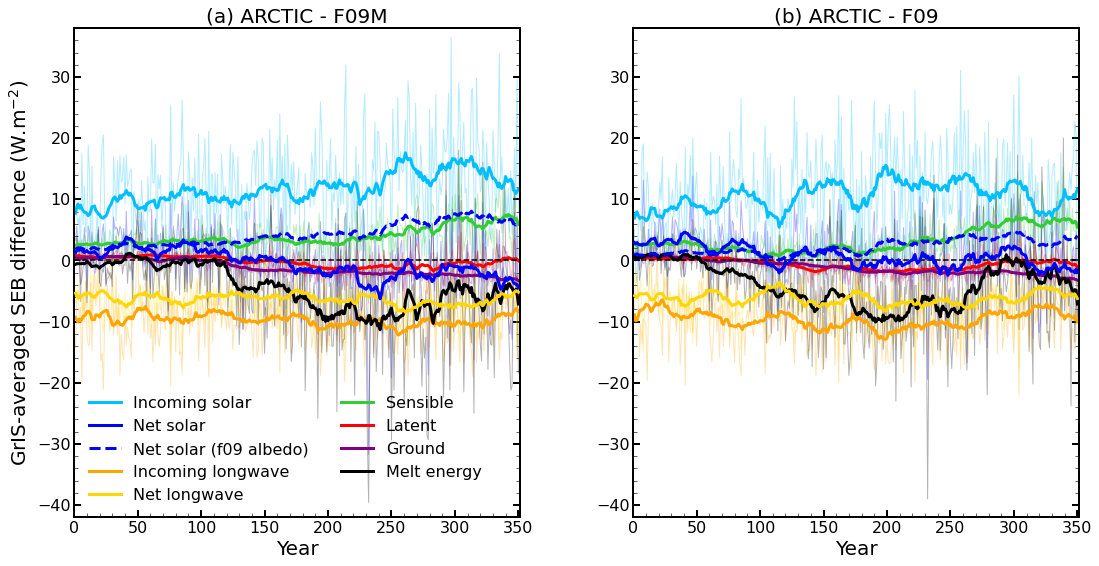

In [23]:
# Add SWn with F09 albedo
fig = plt.figure(figsize = (18,9))
gs=GridSpec(1,11)
plt.rcParams['axes.linewidth'] = 2 #set the value globally

size_tick = 16
size_label = 20
size_legend = 16
size_text = 20

#-------------------------------------------- ARCTIC-F09M --------------------------------------------
ax1 = plt.subplot(gs[0:5])

ax1.plot(np.arange(1,351), ARCTICf09m_1pctCO2_4xext_avg_SWd_JJA_diff, color='deepskyblue', linewidth=1, alpha=0.3)
ax1.plot(np.arange(1,351), ARCTICf09m_1pctCO2_4xext_avg_SWn_JJA_diff, color='blue', linewidth=1, alpha=0.3)
ax1.plot(np.arange(1,351), ARCTICf09m_1pctCO2_4xext_avg_LWd_JJA_diff, color='orange', linewidth=1, alpha=0.3)
ax1.plot(np.arange(1,351), ARCTICf09m_1pctCO2_4xext_avg_LWn_JJA_diff, color='gold', linewidth=1, alpha=0.3)
ax1.plot(np.arange(1,351), ARCTICf09m_1pctCO2_4xext_avg_SHF_JJA_diff, color='limegreen', linewidth=1, alpha=0.3)
ax1.plot(np.arange(1,351), ARCTICf09m_1pctCO2_4xext_avg_LHF_JJA_diff, color='red', linewidth=1, alpha=0.3)
ax1.plot(np.arange(1,351), ARCTICf09m_1pctCO2_4xext_avg_GHF_JJA_diff, color='purple', linewidth=1, alpha=0.3)
ax1.plot(np.arange(1,351), ARCTICf09m_1pctCO2_4xext_avg_ME_JJA_diff, color='black', linewidth=1, alpha=0.3)

ARCTICf09m_1pctCO2_4xext_avg_SWd_JJA_diff_rm = ARCTICf09m_1pctCO2_4xext_avg_SWd_JJA_diff.rolling(time=20, center=True, min_periods=2).mean()
ARCTICf09m_1pctCO2_4xext_avg_SWn_JJA_diff_rm = ARCTICf09m_1pctCO2_4xext_avg_SWn_JJA_diff.rolling(time=20, center=True, min_periods=2).mean()
ARCTICf09m_F09Malbedo_1pctCO2_4xext_avg_SWn_JJA_diff_rm = ARCTICf09m_F09Malbedo_1pctCO2_4xext_avg_SWn_JJA_diff.rolling(time=20, center=True, min_periods=2).mean()
ARCTICf09m_1pctCO2_4xext_avg_LWd_JJA_diff_rm = ARCTICf09m_1pctCO2_4xext_avg_LWd_JJA_diff.rolling(time=20, center=True, min_periods=2).mean()
ARCTICf09m_1pctCO2_4xext_avg_LWn_JJA_diff_rm = ARCTICf09m_1pctCO2_4xext_avg_LWn_JJA_diff.rolling(time=20, center=True, min_periods=2).mean()
ARCTICf09m_1pctCO2_4xext_avg_SHF_JJA_diff_rm = ARCTICf09m_1pctCO2_4xext_avg_SHF_JJA_diff.rolling(time=20, center=True, min_periods=2).mean()
ARCTICf09m_1pctCO2_4xext_avg_LHF_JJA_diff_rm = ARCTICf09m_1pctCO2_4xext_avg_LHF_JJA_diff.rolling(time=20, center=True, min_periods=2).mean()
ARCTICf09m_1pctCO2_4xext_avg_GHF_JJA_diff_rm = ARCTICf09m_1pctCO2_4xext_avg_GHF_JJA_diff.rolling(time=20, center=True, min_periods=2).mean()
ARCTICf09m_1pctCO2_4xext_avg_ME_JJA_diff_rm = ARCTICf09m_1pctCO2_4xext_avg_ME_JJA_diff.rolling(time=20, center=True, min_periods=2).mean()

ax1.plot(np.arange(1,351), ARCTICf09m_1pctCO2_4xext_avg_SWd_JJA_diff_rm, color='deepskyblue', linewidth=3, label='Incoming solar')
ax1.plot(np.arange(1,351), ARCTICf09m_1pctCO2_4xext_avg_SWn_JJA_diff_rm, color='blue', linewidth=3, label='Net solar', zorder=4)
ax1.plot(np.arange(1,351), ARCTICf09m_F09Malbedo_1pctCO2_4xext_avg_SWn_JJA_diff_rm, color='blue', linewidth=3, label='Net solar (f09 albedo)', linestyle='--', zorder=5)
ax1.plot(np.arange(1,351), ARCTICf09m_1pctCO2_4xext_avg_LWd_JJA_diff_rm, color='orange', linewidth=3, label='Incoming longwave')
ax1.plot(np.arange(1,351), ARCTICf09m_1pctCO2_4xext_avg_LWn_JJA_diff_rm, color='gold', linewidth=3, label='Net longwave', zorder=3)
ax1.plot(np.arange(1,351), ARCTICf09m_1pctCO2_4xext_avg_SHF_JJA_diff_rm, color='limegreen', linewidth=3, label='Sensible', zorder=2)
ax1.plot(np.arange(1,351), ARCTICf09m_1pctCO2_4xext_avg_LHF_JJA_diff_rm, color='red', linewidth=3, label='Latent')
ax1.plot(np.arange(1,351), ARCTICf09m_1pctCO2_4xext_avg_GHF_JJA_diff_rm, color='purple', linewidth=3, label='Ground')
ax1.plot(np.arange(1,351), ARCTICf09m_1pctCO2_4xext_avg_ME_JJA_diff_rm, color='black', linewidth=3, label='Melt energy')
ax1.hlines(y = 0, xmin = 0, xmax = 350, colors = 'black', linestyles = '--', linewidth = 1.5)

ax1.set_xlim([0, 351])
ax1.set_ylim([-42, 38])
ax1.set_xlabel('Year', fontsize=size_label)
ax1.set_ylabel('GrIS-averaged SEB difference (W.$\mathregular{m^{-2}}$)', fontsize=size_label)
ax1.xaxis.set_minor_locator(AutoMinorLocator())
ax1.yaxis.set_minor_locator(AutoMinorLocator())
ax1.tick_params(which='major', length=7, width=2, direction='in', right=True, labelright=False)
ax1.tick_params(which='minor', length=4, direction='in', right=True, labelright=False)
ax1.tick_params(labelsize=size_tick)
plt.title('(a) ARCTIC - F09M', fontsize=size_text)

ax1.legend(loc = 'best', frameon = False, prop={'size':size_legend}, ncol=2)

#-------------------------------------------- ARCTIC-F09 --------------------------------------------
ax2 = plt.subplot(gs[6:11])

ax2.plot(np.arange(1,351), ARCTICf09_1pctCO2_4xext_avg_SWd_JJA_diff, color='deepskyblue', linewidth=1, alpha=0.3)
ax2.plot(np.arange(1,351), ARCTICf09_1pctCO2_4xext_avg_SWn_JJA_diff, color='blue', linewidth=1, alpha=0.3)
ax2.plot(np.arange(1,351), ARCTICf09_1pctCO2_4xext_avg_LWd_JJA_diff, color='orange', linewidth=1, alpha=0.3)
ax2.plot(np.arange(1,351), ARCTICf09_1pctCO2_4xext_avg_LWn_JJA_diff, color='gold', linewidth=1, alpha=0.3)
ax2.plot(np.arange(1,351), ARCTICf09_1pctCO2_4xext_avg_SHF_JJA_diff, color='limegreen', linewidth=1, alpha=0.3)
ax2.plot(np.arange(1,351), ARCTICf09_1pctCO2_4xext_avg_LHF_JJA_diff, color='red', linewidth=1, alpha=0.3)
ax2.plot(np.arange(1,351), ARCTICf09_1pctCO2_4xext_avg_GHF_JJA_diff, color='purple', linewidth=1, alpha=0.3)
ax2.plot(np.arange(1,351), ARCTICf09_1pctCO2_4xext_avg_ME_JJA_diff, color='black', linewidth=1, alpha=0.3)

ARCTICf09_1pctCO2_4xext_avg_SWd_JJA_diff_rm = ARCTICf09_1pctCO2_4xext_avg_SWd_JJA_diff.rolling(time=20, center=True, min_periods=2).mean()
ARCTICf09_1pctCO2_4xext_avg_SWn_JJA_diff_rm = ARCTICf09_1pctCO2_4xext_avg_SWn_JJA_diff.rolling(time=20, center=True, min_periods=2).mean()
ARCTICf09_F09albedo_1pctCO2_4xext_avg_SWn_JJA_diff_rm = ARCTICf09_F09albedo_1pctCO2_4xext_avg_SWn_JJA_diff.rolling(time=20, center=True, min_periods=2).mean()
ARCTICf09_1pctCO2_4xext_avg_LWd_JJA_diff_rm = ARCTICf09_1pctCO2_4xext_avg_LWd_JJA_diff.rolling(time=20, center=True, min_periods=2).mean()
ARCTICf09_1pctCO2_4xext_avg_LWn_JJA_diff_rm = ARCTICf09_1pctCO2_4xext_avg_LWn_JJA_diff.rolling(time=20, center=True, min_periods=2).mean()
ARCTICf09_1pctCO2_4xext_avg_SHF_JJA_diff_rm = ARCTICf09_1pctCO2_4xext_avg_SHF_JJA_diff.rolling(time=20, center=True, min_periods=2).mean()
ARCTICf09_1pctCO2_4xext_avg_LHF_JJA_diff_rm = ARCTICf09_1pctCO2_4xext_avg_LHF_JJA_diff.rolling(time=20, center=True, min_periods=2).mean()
ARCTICf09_1pctCO2_4xext_avg_GHF_JJA_diff_rm = ARCTICf09_1pctCO2_4xext_avg_GHF_JJA_diff.rolling(time=20, center=True, min_periods=2).mean()
ARCTICf09_1pctCO2_4xext_avg_ME_JJA_diff_rm = ARCTICf09_1pctCO2_4xext_avg_ME_JJA_diff.rolling(time=20, center=True, min_periods=2).mean()

ax2.plot(np.arange(1,351), ARCTICf09_1pctCO2_4xext_avg_SWd_JJA_diff_rm, color='deepskyblue', linewidth=3, label='SWd')
ax2.plot(np.arange(1,351), ARCTICf09_1pctCO2_4xext_avg_SWn_JJA_diff_rm, color='blue', linewidth=3, label='SWn', zorder=4)
ax2.plot(np.arange(1,351), ARCTICf09_F09albedo_1pctCO2_4xext_avg_SWn_JJA_diff_rm, color='blue', linewidth=3, label='Net solar (f09 albedo)', linestyle='--', zorder=5)
ax2.plot(np.arange(1,351), ARCTICf09_1pctCO2_4xext_avg_LWd_JJA_diff_rm, color='orange', linewidth=3, label='LWd')
ax2.plot(np.arange(1,351), ARCTICf09_1pctCO2_4xext_avg_LWn_JJA_diff_rm, color='gold', linewidth=3, label='LWn', zorder=3)
ax2.plot(np.arange(1,351), ARCTICf09_1pctCO2_4xext_avg_SHF_JJA_diff_rm, color='limegreen', linewidth=3, label='SH', zorder=2)
ax2.plot(np.arange(1,351), ARCTICf09_1pctCO2_4xext_avg_LHF_JJA_diff_rm, color='red', linewidth=3, label='LH')
ax2.plot(np.arange(1,351), ARCTICf09_1pctCO2_4xext_avg_GHF_JJA_diff_rm, color='purple', linewidth=3, label='GHF')
ax2.plot(np.arange(1,351), ARCTICf09_1pctCO2_4xext_avg_ME_JJA_diff_rm, color='black', linewidth=3, label='ME')
ax2.hlines(y = 0, xmin = 0, xmax = 350, colors = 'black', linestyles = '--', linewidth = 1.5)

ax2.set_xlim([0, 351])
ax2.set_ylim([-42, 38])
ax2.set_xlabel('Year', fontsize=size_label)
#ax2.set_ylabel('GrIS-averaged SEB difference (W.$\mathregular{m^{-2}}$)', fontsize=size_label)
ax2.xaxis.set_minor_locator(AutoMinorLocator())
ax2.yaxis.set_minor_locator(AutoMinorLocator())
ax2.tick_params(which='major', length=7, width=2, direction='in', right=True, labelright=False)
ax2.tick_params(which='minor', length=4, direction='in', right=True, labelright=False)
ax2.tick_params(labelsize=size_tick)
plt.title('(b) ARCTIC - F09', fontsize=size_text)

plt.subplots_adjust(wspace=0.28)
plt.savefig(home_dir+'2022-VR-dynamic-GrIS/github/plot/tseries_SEB_anomaly_ARCTICf09mf09_coralbedo.png', dpi=300, bbox_inches='tight', facecolor='w', transparent=False) #

#### Linear regression on T2m difference

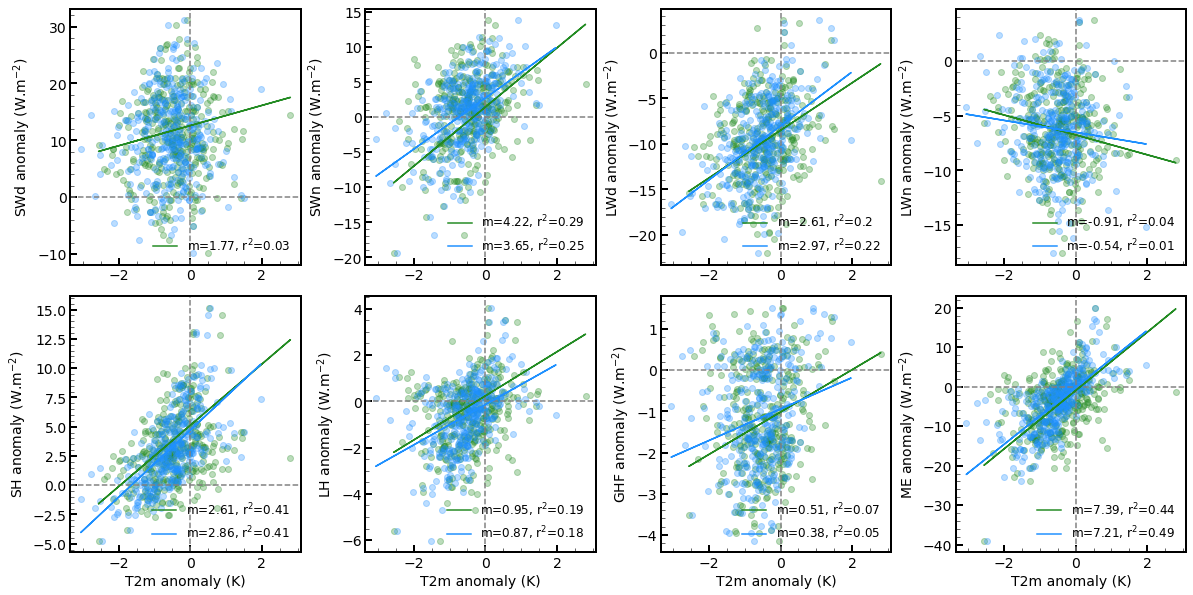

In [62]:
fig = plt.figure(figsize = (20,10))
gs=GridSpec(2,4)
plt.rcParams['axes.linewidth'] = 2 #set the value globally

size_tick = 14
size_label = 14
size_legend = 12
size_text = 20

#-------------------------------------------- SWd --------------------------------------------
ax1 = plt.subplot(gs[0])

plt.scatter(ARCTICf09m_1pctCO2_4xext_avg_TREFHT_JJA_diff, ARCTICf09_1pctCO2_4xext_avg_SWd_JJA_diff, color='forestgreen', alpha=0.3)
plt.scatter(ARCTICf09_1pctCO2_4xext_avg_TREFHT_JJA_diff, ARCTICf09_1pctCO2_4xext_avg_SWd_JJA_diff, color='dodgerblue', alpha=0.3)
plt.axvline(x=0., color='gray', linestyle='--')
plt.axhline(y=0., color='gray', linestyle='--')
plt.plot(ARCTICf09m_1pctCO2_4xext_avg_TREFHT_JJA_diff, ARCTICf09m_1pctCO2_4xext_avg_TREFHT_JJA_diff*slope_SWdm+intercept_SWdm, color='forestgreen', label='m='+str(round(slope_SWdm,2))+', $\mathregular{r^{2}}$='+str(round(r_value_SWdm**2,2)))
#plt.plot(ARCTICf09_1pctCO2_4xext_avg_TREFHT_JJA_diff, ARCTICf09_1pctCO2_4xext_avg_TREFHT_JJA_diff*slope_SWd+intercept_SWd, color='dodgerblue', label='m='+str(round(slope_SWd,2))+', $\mathregular{r^{2}}$='+str(round(r_value_SWd**2,2))) # p>0.05

ax1.legend(loc='lower right', frameon = False, prop={'size':size_legend}, ncol=1)

#ax1.set_ylim([-9, 4])
#ax1.set_xlabel("T2m anomaly (K)", fontsize=size_label)
ax1.set_ylabel("SWd anomaly (W.$\mathregular{m^{-2}}$)", fontsize=size_label)
ax1.xaxis.set_minor_locator(AutoMinorLocator())
ax1.yaxis.set_minor_locator(AutoMinorLocator())
ax1.tick_params(which="major", length=7, width=2, direction="in")
ax1.tick_params(which="minor", length=4, direction="in")
ax1.tick_params(labelsize=size_tick)

#-------------------------------------------- SWn --------------------------------------------
ax2 = plt.subplot(gs[1])

plt.scatter(ARCTICf09m_1pctCO2_4xext_avg_TREFHT_JJA_diff, ARCTICf09_1pctCO2_4xext_avg_SWn_JJA_diff, color='forestgreen', alpha=0.3)
plt.scatter(ARCTICf09_1pctCO2_4xext_avg_TREFHT_JJA_diff, ARCTICf09_1pctCO2_4xext_avg_SWn_JJA_diff, color='dodgerblue', alpha=0.3)
plt.axvline(x=0., color='gray', linestyle='--')
plt.axhline(y=0., color='gray', linestyle='--')
plt.plot(ARCTICf09m_1pctCO2_4xext_avg_TREFHT_JJA_diff, ARCTICf09m_1pctCO2_4xext_avg_TREFHT_JJA_diff*slope_SWnm+intercept_SWnm, color='forestgreen', label='m='+str(round(slope_SWnm,2))+', $\mathregular{r^{2}}$='+str(round(r_value_SWnm**2,2)))
plt.plot(ARCTICf09_1pctCO2_4xext_avg_TREFHT_JJA_diff, ARCTICf09_1pctCO2_4xext_avg_TREFHT_JJA_diff*slope_SWn+intercept_SWn, color='dodgerblue', label='m='+str(round(slope_SWn,2))+', $\mathregular{r^{2}}$='+str(round(r_value_SWn**2,2)))

ax2.legend(loc='lower right', frameon=False, prop={'size':size_legend}, ncol=1)

#ax2.set_ylim([-9, 4])
#ax2.set_xlabel("T2m anomaly (K)", fontsize=size_label)
ax2.set_ylabel("SWn anomaly (W.$\mathregular{m^{-2}}$)", fontsize=size_label)
ax2.xaxis.set_minor_locator(AutoMinorLocator())
ax2.yaxis.set_minor_locator(AutoMinorLocator())
ax2.tick_params(which="major", length=7, width=2, direction="in")
ax2.tick_params(which="minor", length=4, direction="in")
ax2.tick_params(labelsize=size_tick)

#-------------------------------------------- LWd --------------------------------------------
ax3 = plt.subplot(gs[2])

plt.scatter(ARCTICf09m_1pctCO2_4xext_avg_TREFHT_JJA_diff, ARCTICf09_1pctCO2_4xext_avg_LWd_JJA_diff, color='forestgreen', alpha=0.3)
plt.scatter(ARCTICf09_1pctCO2_4xext_avg_TREFHT_JJA_diff, ARCTICf09_1pctCO2_4xext_avg_LWd_JJA_diff, color='dodgerblue', alpha=0.3)
plt.axvline(x=0., color='gray', linestyle='--')
plt.axhline(y=0., color='gray', linestyle='--')
plt.plot(ARCTICf09m_1pctCO2_4xext_avg_TREFHT_JJA_diff, ARCTICf09m_1pctCO2_4xext_avg_TREFHT_JJA_diff*slope_LWdm+intercept_LWdm, color='forestgreen', label='m='+str(round(slope_LWdm,2))+', $\mathregular{r^{2}}$='+str(round(r_value_LWdm**2,2)))
plt.plot(ARCTICf09_1pctCO2_4xext_avg_TREFHT_JJA_diff, ARCTICf09_1pctCO2_4xext_avg_TREFHT_JJA_diff*slope_LWd+intercept_LWd, color='dodgerblue', label='m='+str(round(slope_LWd,2))+', $\mathregular{r^{2}}$='+str(round(r_value_LWd**2,2)))

ax3.legend(loc='lower right', frameon=False, prop={'size':size_legend}, ncol=1)

#ax3.set_ylim([-9, 4])
#ax3.set_xlabel("T2m anomaly (K)", fontsize=size_label)
ax3.set_ylabel("LWd anomaly (W.$\mathregular{m^{-2}}$)", fontsize=size_label)
ax3.xaxis.set_minor_locator(AutoMinorLocator())
ax3.yaxis.set_minor_locator(AutoMinorLocator())
ax3.tick_params(which="major", length=7, width=2, direction="in")
ax3.tick_params(which="minor", length=4, direction="in")
ax3.tick_params(labelsize=size_tick)

#-------------------------------------------- LWn --------------------------------------------
ax4 = plt.subplot(gs[3])

plt.scatter(ARCTICf09m_1pctCO2_4xext_avg_TREFHT_JJA_diff, ARCTICf09_1pctCO2_4xext_avg_LWn_JJA_diff, color='forestgreen', alpha=0.3)
plt.scatter(ARCTICf09_1pctCO2_4xext_avg_TREFHT_JJA_diff, ARCTICf09_1pctCO2_4xext_avg_LWn_JJA_diff, color='dodgerblue', alpha=0.3)
plt.axvline(x=0., color='gray', linestyle='--')
plt.axhline(y=0., color='gray', linestyle='--')
plt.plot(ARCTICf09m_1pctCO2_4xext_avg_TREFHT_JJA_diff, ARCTICf09m_1pctCO2_4xext_avg_TREFHT_JJA_diff*slope_LWnm+intercept_LWnm, color='forestgreen', label='m='+str(round(slope_LWnm,2))+', $\mathregular{r^{2}}$='+str(round(r_value_LWnm**2,2)))
plt.plot(ARCTICf09_1pctCO2_4xext_avg_TREFHT_JJA_diff, ARCTICf09_1pctCO2_4xext_avg_TREFHT_JJA_diff*slope_LWn+intercept_LWn, color='dodgerblue', label='m='+str(round(slope_LWn,2))+', $\mathregular{r^{2}}$='+str(round(r_value_LWn**2,2)))

ax4.legend(loc='lower right', frameon=False, prop={'size':size_legend}, ncol=1)

#ax4.set_ylim([-9, 4])
#ax4.set_xlabel("T2m anomaly (K)", fontsize=size_label)
ax4.set_ylabel("LWn anomaly (W.$\mathregular{m^{-2}}$)", fontsize=size_label)
ax4.xaxis.set_minor_locator(AutoMinorLocator())
ax4.yaxis.set_minor_locator(AutoMinorLocator())
ax4.tick_params(which="major", length=7, width=2, direction="in")
ax4.tick_params(which="minor", length=4, direction="in")
ax4.tick_params(labelsize=size_tick)

#-------------------------------------------- SH --------------------------------------------
ax5 = plt.subplot(gs[4])

plt.scatter(ARCTICf09m_1pctCO2_4xext_avg_TREFHT_JJA_diff, ARCTICf09_1pctCO2_4xext_avg_SHF_JJA_diff, color='forestgreen', alpha=0.3)
plt.scatter(ARCTICf09_1pctCO2_4xext_avg_TREFHT_JJA_diff, ARCTICf09_1pctCO2_4xext_avg_SHF_JJA_diff, color='dodgerblue', alpha=0.3)
plt.axvline(x=0., color='gray', linestyle='--')
plt.axhline(y=0., color='gray', linestyle='--')
plt.plot(ARCTICf09m_1pctCO2_4xext_avg_TREFHT_JJA_diff, ARCTICf09m_1pctCO2_4xext_avg_TREFHT_JJA_diff*slope_SHm+intercept_SHm, color='forestgreen', label='m='+str(round(slope_SHm,2))+', $\mathregular{r^{2}}$='+str(round(r_value_SHm**2,2)))
plt.plot(ARCTICf09_1pctCO2_4xext_avg_TREFHT_JJA_diff, ARCTICf09_1pctCO2_4xext_avg_TREFHT_JJA_diff*slope_SH+intercept_SH, color='dodgerblue', label='m='+str(round(slope_SH,2))+', $\mathregular{r^{2}}$='+str(round(r_value_SH**2,2)))

ax5.legend(loc='lower right', frameon = False, prop={'size':size_legend}, ncol=1)

#ax5.set_ylim([-9, 4])
ax5.set_xlabel("T2m anomaly (K)", fontsize=size_label)
ax5.set_ylabel("SH anomaly (W.$\mathregular{m^{-2}}$)", fontsize=size_label)
ax5.xaxis.set_minor_locator(AutoMinorLocator())
ax5.yaxis.set_minor_locator(AutoMinorLocator())
ax5.tick_params(which="major", length=7, width=2, direction="in")
ax5.tick_params(which="minor", length=4, direction="in")
ax5.tick_params(labelsize=size_tick)

#-------------------------------------------- LH --------------------------------------------
ax6 = plt.subplot(gs[5])

plt.scatter(ARCTICf09m_1pctCO2_4xext_avg_TREFHT_JJA_diff, ARCTICf09_1pctCO2_4xext_avg_LHF_JJA_diff, color='forestgreen', alpha=0.3)
plt.scatter(ARCTICf09_1pctCO2_4xext_avg_TREFHT_JJA_diff, ARCTICf09_1pctCO2_4xext_avg_LHF_JJA_diff, color='dodgerblue', alpha=0.3)
plt.axvline(x=0., color='gray', linestyle='--')
plt.axhline(y=0., color='gray', linestyle='--')
plt.plot(ARCTICf09m_1pctCO2_4xext_avg_TREFHT_JJA_diff, ARCTICf09m_1pctCO2_4xext_avg_TREFHT_JJA_diff*slope_LHm+intercept_LHm, color='forestgreen', label='m='+str(round(slope_LHm,2))+', $\mathregular{r^{2}}$='+str(round(r_value_LHm**2,2)))
plt.plot(ARCTICf09_1pctCO2_4xext_avg_TREFHT_JJA_diff, ARCTICf09_1pctCO2_4xext_avg_TREFHT_JJA_diff*slope_LH+intercept_LH, color='dodgerblue', label='m='+str(round(slope_LH,2))+', $\mathregular{r^{2}}$='+str(round(r_value_LH**2,2)))

ax6.legend(loc='lower right', frameon = False, prop={'size':size_legend}, ncol=1)

#ax6.set_ylim([-9, 4])
ax6.set_xlabel("T2m anomaly (K)", fontsize=size_label)
ax6.set_ylabel("LH anomaly (W.$\mathregular{m^{-2}}$)", fontsize=size_label)
ax6.xaxis.set_minor_locator(AutoMinorLocator())
ax6.yaxis.set_minor_locator(AutoMinorLocator())
ax6.tick_params(which="major", length=7, width=2, direction="in")
ax6.tick_params(which="minor", length=4, direction="in")
ax6.tick_params(labelsize=size_tick)

#-------------------------------------------- GHF --------------------------------------------
ax7 = plt.subplot(gs[6])

plt.scatter(ARCTICf09m_1pctCO2_4xext_avg_TREFHT_JJA_diff, ARCTICf09_1pctCO2_4xext_avg_GHF_JJA_diff, color='forestgreen', alpha=0.3)
plt.scatter(ARCTICf09_1pctCO2_4xext_avg_TREFHT_JJA_diff, ARCTICf09_1pctCO2_4xext_avg_GHF_JJA_diff, color='dodgerblue', alpha=0.3)
plt.axvline(x=0., color='gray', linestyle='--')
plt.axhline(y=0., color='gray', linestyle='--')
plt.plot(ARCTICf09m_1pctCO2_4xext_avg_TREFHT_JJA_diff, ARCTICf09m_1pctCO2_4xext_avg_TREFHT_JJA_diff*slope_GHFm+intercept_GHFm, color='forestgreen', label='m='+str(round(slope_GHFm,2))+', $\mathregular{r^{2}}$='+str(round(r_value_GHFm**2,2)))
plt.plot(ARCTICf09_1pctCO2_4xext_avg_TREFHT_JJA_diff, ARCTICf09_1pctCO2_4xext_avg_TREFHT_JJA_diff*slope_GHF+intercept_GHF, color='dodgerblue', label='m='+str(round(slope_GHF,2))+', $\mathregular{r^{2}}$='+str(round(r_value_GHF**2,2)))

ax7.legend(loc='lower right', frameon = False, prop={'size':size_legend}, ncol=1)

#ax7.set_ylim([-9, 4])
ax7.set_xlabel("T2m anomaly (K)", fontsize=size_label)
ax7.set_ylabel("GHF anomaly (W.$\mathregular{m^{-2}}$)", fontsize=size_label)
ax7.xaxis.set_minor_locator(AutoMinorLocator())
ax7.yaxis.set_minor_locator(AutoMinorLocator())
ax7.tick_params(which="major", length=7, width=2, direction="in")
ax7.tick_params(which="minor", length=4, direction="in")
ax7.tick_params(labelsize=size_tick)

#-------------------------------------------- ME --------------------------------------------
ax8 = plt.subplot(gs[7])

plt.scatter(ARCTICf09m_1pctCO2_4xext_avg_TREFHT_JJA_diff, ARCTICf09_1pctCO2_4xext_avg_ME_JJA_diff, color='forestgreen', alpha=0.3)
plt.scatter(ARCTICf09_1pctCO2_4xext_avg_TREFHT_JJA_diff, ARCTICf09_1pctCO2_4xext_avg_ME_JJA_diff, color='dodgerblue', alpha=0.3)
plt.axvline(x=0., color='gray', linestyle='--')
plt.axhline(y=0., color='gray', linestyle='--')
plt.plot(ARCTICf09m_1pctCO2_4xext_avg_TREFHT_JJA_diff, ARCTICf09m_1pctCO2_4xext_avg_TREFHT_JJA_diff*slope_MEm+intercept_MEm, color='forestgreen', label='m='+str(round(slope_MEm,2))+', $\mathregular{r^{2}}$='+str(round(r_value_MEm**2,2)))
plt.plot(ARCTICf09_1pctCO2_4xext_avg_TREFHT_JJA_diff, ARCTICf09_1pctCO2_4xext_avg_TREFHT_JJA_diff*slope_ME+intercept_ME, color='dodgerblue', label='m='+str(round(slope_ME,2))+', $\mathregular{r^{2}}$='+str(round(r_value_ME**2,2)))

ax8.legend(loc='lower right', frameon = False, prop={'size':size_legend}, ncol=1)

#ax8.set_ylim([-9, 4])
ax8.set_xlabel("T2m anomaly (K)", fontsize=size_label)
ax8.set_ylabel("ME anomaly (W.$\mathregular{m^{-2}}$)", fontsize=size_label)
ax8.xaxis.set_minor_locator(AutoMinorLocator())
ax8.yaxis.set_minor_locator(AutoMinorLocator())
ax8.tick_params(which="major", length=7, width=2, direction="in")
ax8.tick_params(which="minor", length=4, direction="in")
ax8.tick_params(labelsize=size_tick)


plt.subplots_adjust(wspace=0.28, hspace=0.12)
plt.savefig(
    home_dir + "2022-VR-dynamic-GrIS/github/plot/Scatter_GrIS_avg_dT2m_dSEB.png",
    dpi=300,
    bbox_inches="tight",
    facecolor="w",
    transparent=False,
)

#### Area-averaged SEB difference (ice landunits only)

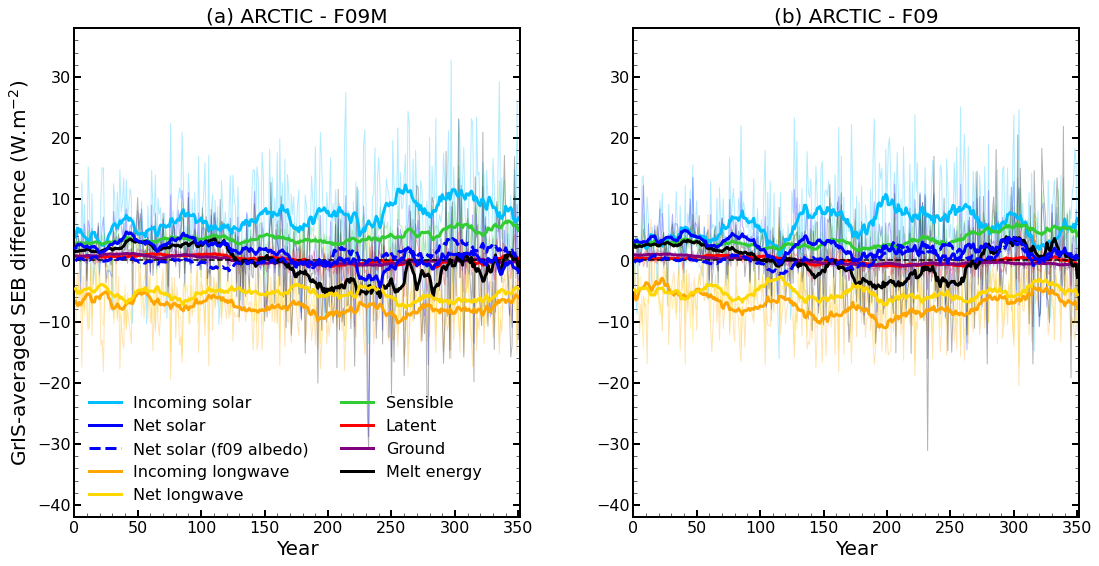

In [71]:
# Add SWn with F09 albedo
fig = plt.figure(figsize = (18,9))
gs=GridSpec(1,11)
plt.rcParams['axes.linewidth'] = 2 #set the value globally

size_tick = 16
size_label = 20
size_legend = 16
size_text = 20

#-------------------------------------------- ARCTIC-F09M --------------------------------------------
ax1 = plt.subplot(gs[0:5])

ax1.plot(np.arange(1,351), ARCTICf09m_1pctCO2_4xext_avg_SWd_JJA_diff, color='deepskyblue', linewidth=1, alpha=0.3)
ax1.plot(np.arange(1,351), ARCTICf09m_1pctCO2_4xext_avg_SWn_JJA_diff, color='blue', linewidth=1, alpha=0.3)
ax1.plot(np.arange(1,351), ARCTICf09m_1pctCO2_4xext_avg_LWd_JJA_diff, color='orange', linewidth=1, alpha=0.3)
ax1.plot(np.arange(1,351), ARCTICf09m_1pctCO2_4xext_avg_LWn_JJA_diff, color='gold', linewidth=1, alpha=0.3)
ax1.plot(np.arange(1,351), ARCTICf09m_1pctCO2_4xext_avg_SHF_JJA_diff, color='limegreen', linewidth=1, alpha=0.3)
ax1.plot(np.arange(1,351), ARCTICf09m_1pctCO2_4xext_avg_LHF_JJA_diff, color='red', linewidth=1, alpha=0.3)
ax1.plot(np.arange(1,351), ARCTICf09m_1pctCO2_4xext_avg_GHF_JJA_diff, color='purple', linewidth=1, alpha=0.3)
ax1.plot(np.arange(1,351), ARCTICf09m_1pctCO2_4xext_avg_ME_JJA_diff, color='black', linewidth=1, alpha=0.3)

ARCTICf09m_1pctCO2_4xext_avg_SWd_JJA_diff_rm = ARCTICf09m_1pctCO2_4xext_avg_SWd_JJA_diff.rolling(time=20, center=True, min_periods=2).mean()
ARCTICf09m_1pctCO2_4xext_avg_SWn_JJA_diff_rm = ARCTICf09m_1pctCO2_4xext_avg_SWn_JJA_diff.rolling(time=20, center=True, min_periods=2).mean()
ARCTICf09m_F09Malbedo_1pctCO2_4xext_avg_SWn_JJA_diff_rm = ARCTICf09m_F09Malbedo_1pctCO2_4xext_avg_SWn_JJA_diff.rolling(time=20, center=True, min_periods=2).mean()
ARCTICf09m_1pctCO2_4xext_avg_LWd_JJA_diff_rm = ARCTICf09m_1pctCO2_4xext_avg_LWd_JJA_diff.rolling(time=20, center=True, min_periods=2).mean()
ARCTICf09m_1pctCO2_4xext_avg_LWn_JJA_diff_rm = ARCTICf09m_1pctCO2_4xext_avg_LWn_JJA_diff.rolling(time=20, center=True, min_periods=2).mean()
ARCTICf09m_1pctCO2_4xext_avg_SHF_JJA_diff_rm = ARCTICf09m_1pctCO2_4xext_avg_SHF_JJA_diff.rolling(time=20, center=True, min_periods=2).mean()
ARCTICf09m_1pctCO2_4xext_avg_LHF_JJA_diff_rm = ARCTICf09m_1pctCO2_4xext_avg_LHF_JJA_diff.rolling(time=20, center=True, min_periods=2).mean()
ARCTICf09m_1pctCO2_4xext_avg_GHF_JJA_diff_rm = ARCTICf09m_1pctCO2_4xext_avg_GHF_JJA_diff.rolling(time=20, center=True, min_periods=2).mean()
ARCTICf09m_1pctCO2_4xext_avg_ME_JJA_diff_rm = ARCTICf09m_1pctCO2_4xext_avg_ME_JJA_diff.rolling(time=20, center=True, min_periods=2).mean()

ax1.plot(np.arange(1,351), ARCTICf09m_1pctCO2_4xext_avg_SWd_JJA_diff_rm, color='deepskyblue', linewidth=3, label='Incoming solar')
ax1.plot(np.arange(1,351), ARCTICf09m_1pctCO2_4xext_avg_SWn_JJA_diff_rm, color='blue', linewidth=3, label='Net solar', zorder=4)
ax1.plot(np.arange(1,351), ARCTICf09m_F09Malbedo_1pctCO2_4xext_avg_SWn_JJA_diff_rm, color='blue', linewidth=3, label='Net solar (f09 albedo)', linestyle='--', zorder=5)
ax1.plot(np.arange(1,351), ARCTICf09m_1pctCO2_4xext_avg_LWd_JJA_diff_rm, color='orange', linewidth=3, label='Incoming longwave')
ax1.plot(np.arange(1,351), ARCTICf09m_1pctCO2_4xext_avg_LWn_JJA_diff_rm, color='gold', linewidth=3, label='Net longwave', zorder=3)
ax1.plot(np.arange(1,351), ARCTICf09m_1pctCO2_4xext_avg_SHF_JJA_diff_rm, color='limegreen', linewidth=3, label='Sensible', zorder=2)
ax1.plot(np.arange(1,351), ARCTICf09m_1pctCO2_4xext_avg_LHF_JJA_diff_rm, color='red', linewidth=3, label='Latent')
ax1.plot(np.arange(1,351), ARCTICf09m_1pctCO2_4xext_avg_GHF_JJA_diff_rm, color='purple', linewidth=3, label='Ground')
ax1.plot(np.arange(1,351), ARCTICf09m_1pctCO2_4xext_avg_ME_JJA_diff_rm, color='black', linewidth=3, label='Melt energy')
ax1.hlines(y = 0, xmin = 0, xmax = 350, colors = 'black', linestyles = '--', linewidth = 1.5)

ax1.set_xlim([0, 351])
ax1.set_ylim([-42, 38])
ax1.set_xlabel('Year', fontsize=size_label)
ax1.set_ylabel('GrIS-averaged SEB difference (W.$\mathregular{m^{-2}}$)', fontsize=size_label)
ax1.xaxis.set_minor_locator(AutoMinorLocator())
ax1.yaxis.set_minor_locator(AutoMinorLocator())
ax1.tick_params(which='major', length=7, width=2, direction='in', right=True, labelright=False)
ax1.tick_params(which='minor', length=4, direction='in', right=True, labelright=False)
ax1.tick_params(labelsize=size_tick)
plt.title('(a) ARCTIC - F09M', fontsize=size_text)

ax1.legend(loc = 'best', frameon = False, prop={'size':size_legend}, ncol=2)

#-------------------------------------------- ARCTIC-F09 --------------------------------------------
ax2 = plt.subplot(gs[6:11])

ax2.plot(np.arange(1,351), ARCTICf09_1pctCO2_4xext_avg_SWd_JJA_diff, color='deepskyblue', linewidth=1, alpha=0.3)
ax2.plot(np.arange(1,351), ARCTICf09_1pctCO2_4xext_avg_SWn_JJA_diff, color='blue', linewidth=1, alpha=0.3)
ax2.plot(np.arange(1,351), ARCTICf09_1pctCO2_4xext_avg_LWd_JJA_diff, color='orange', linewidth=1, alpha=0.3)
ax2.plot(np.arange(1,351), ARCTICf09_1pctCO2_4xext_avg_LWn_JJA_diff, color='gold', linewidth=1, alpha=0.3)
ax2.plot(np.arange(1,351), ARCTICf09_1pctCO2_4xext_avg_SHF_JJA_diff, color='limegreen', linewidth=1, alpha=0.3)
ax2.plot(np.arange(1,351), ARCTICf09_1pctCO2_4xext_avg_LHF_JJA_diff, color='red', linewidth=1, alpha=0.3)
ax2.plot(np.arange(1,351), ARCTICf09_1pctCO2_4xext_avg_GHF_JJA_diff, color='purple', linewidth=1, alpha=0.3)
ax2.plot(np.arange(1,351), ARCTICf09_1pctCO2_4xext_avg_ME_JJA_diff, color='black', linewidth=1, alpha=0.3)

ARCTICf09_1pctCO2_4xext_avg_SWd_JJA_diff_rm = ARCTICf09_1pctCO2_4xext_avg_SWd_JJA_diff.rolling(time=20, center=True, min_periods=2).mean()
ARCTICf09_1pctCO2_4xext_avg_SWn_JJA_diff_rm = ARCTICf09_1pctCO2_4xext_avg_SWn_JJA_diff.rolling(time=20, center=True, min_periods=2).mean()
ARCTICf09_F09albedo_1pctCO2_4xext_avg_SWn_JJA_diff_rm = ARCTICf09_F09albedo_1pctCO2_4xext_avg_SWn_JJA_diff.rolling(time=20, center=True, min_periods=2).mean()
ARCTICf09_1pctCO2_4xext_avg_LWd_JJA_diff_rm = ARCTICf09_1pctCO2_4xext_avg_LWd_JJA_diff.rolling(time=20, center=True, min_periods=2).mean()
ARCTICf09_1pctCO2_4xext_avg_LWn_JJA_diff_rm = ARCTICf09_1pctCO2_4xext_avg_LWn_JJA_diff.rolling(time=20, center=True, min_periods=2).mean()
ARCTICf09_1pctCO2_4xext_avg_SHF_JJA_diff_rm = ARCTICf09_1pctCO2_4xext_avg_SHF_JJA_diff.rolling(time=20, center=True, min_periods=2).mean()
ARCTICf09_1pctCO2_4xext_avg_LHF_JJA_diff_rm = ARCTICf09_1pctCO2_4xext_avg_LHF_JJA_diff.rolling(time=20, center=True, min_periods=2).mean()
ARCTICf09_1pctCO2_4xext_avg_GHF_JJA_diff_rm = ARCTICf09_1pctCO2_4xext_avg_GHF_JJA_diff.rolling(time=20, center=True, min_periods=2).mean()
ARCTICf09_1pctCO2_4xext_avg_ME_JJA_diff_rm = ARCTICf09_1pctCO2_4xext_avg_ME_JJA_diff.rolling(time=20, center=True, min_periods=2).mean()

ax2.plot(np.arange(1,351), ARCTICf09_1pctCO2_4xext_avg_SWd_JJA_diff_rm, color='deepskyblue', linewidth=3, label='SWd')
ax2.plot(np.arange(1,351), ARCTICf09_1pctCO2_4xext_avg_SWn_JJA_diff_rm, color='blue', linewidth=3, label='SWn', zorder=4)
ax2.plot(np.arange(1,351), ARCTICf09_F09albedo_1pctCO2_4xext_avg_SWn_JJA_diff_rm, color='blue', linewidth=3, label='Net solar (f09 albedo)', linestyle='--', zorder=5)
ax2.plot(np.arange(1,351), ARCTICf09_1pctCO2_4xext_avg_LWd_JJA_diff_rm, color='orange', linewidth=3, label='LWd')
ax2.plot(np.arange(1,351), ARCTICf09_1pctCO2_4xext_avg_LWn_JJA_diff_rm, color='gold', linewidth=3, label='LWn', zorder=3)
ax2.plot(np.arange(1,351), ARCTICf09_1pctCO2_4xext_avg_SHF_JJA_diff_rm, color='limegreen', linewidth=3, label='SH', zorder=2)
ax2.plot(np.arange(1,351), ARCTICf09_1pctCO2_4xext_avg_LHF_JJA_diff_rm, color='red', linewidth=3, label='LH')
ax2.plot(np.arange(1,351), ARCTICf09_1pctCO2_4xext_avg_GHF_JJA_diff_rm, color='purple', linewidth=3, label='LH')
ax2.plot(np.arange(1,351), ARCTICf09_1pctCO2_4xext_avg_ME_JJA_diff_rm, color='black', linewidth=3, label='ME')
ax2.hlines(y = 0, xmin = 0, xmax = 350, colors = 'black', linestyles = '--', linewidth = 1.5)

ax2.set_xlim([0, 351])
ax2.set_ylim([-42, 38])
ax2.set_xlabel('Year', fontsize=size_label)
#ax2.set_ylabel('GrIS-averaged SEB difference (W.$\mathregular{m^{-2}}$)', fontsize=size_label)
ax2.xaxis.set_minor_locator(AutoMinorLocator())
ax2.yaxis.set_minor_locator(AutoMinorLocator())
ax2.tick_params(which='major', length=7, width=2, direction='in', right=True, labelright=False)
ax2.tick_params(which='minor', length=4, direction='in', right=True, labelright=False)
ax2.tick_params(labelsize=size_tick)
plt.title('(b) ARCTIC - F09', fontsize=size_text)

plt.subplots_adjust(wspace=0.28)
plt.savefig(home_dir+'2022-VR-dynamic-GrIS/github/plot/tseries_SEB_anomaly_ARCTICf09mf09_coralbedo_allice.png', dpi=300, bbox_inches='tight', facecolor='w', transparent=False) #

#### Remove initial differences and plot cumulative changes 

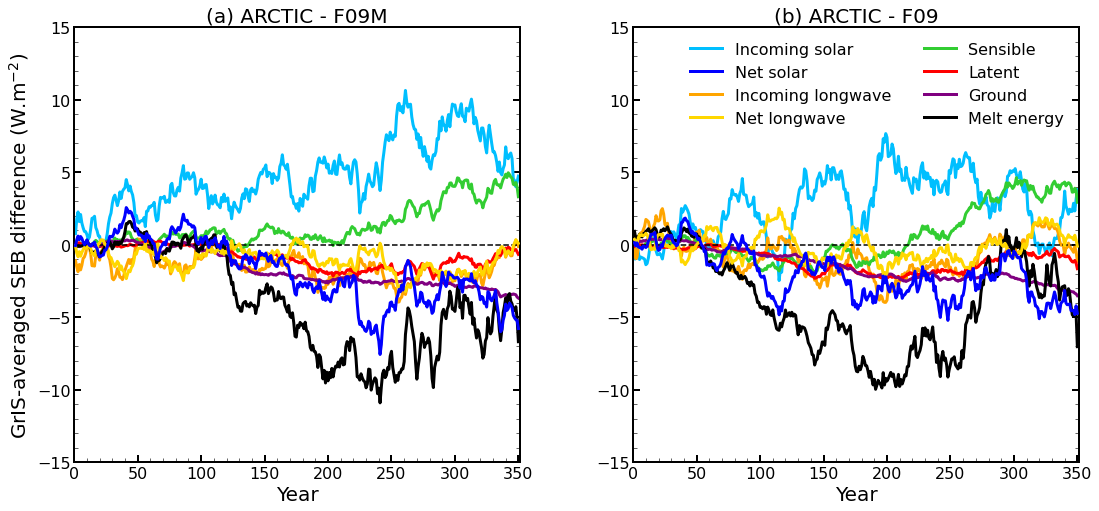

In [62]:
# Change based on initial differences
fig = plt.figure(figsize = (18,8))
gs=GridSpec(1,11)
plt.rcParams['axes.linewidth'] = 2 #set the value globally

size_tick = 16
size_label = 20
size_legend = 16
size_text = 20

ARCTICf09m_1pctCO2_4xext_avg_SWd_JJA_diffa = ARCTICf09m_1pctCO2_4xext_avg_SWd_JJA_diff - ARCTICf09m_PI_avg_SWd_JJA_diff
ARCTICf09m_1pctCO2_4xext_avg_SWn_JJA_diffa = ARCTICf09m_1pctCO2_4xext_avg_SWn_JJA_diff - ARCTICf09m_PI_avg_SWn_JJA_diff
ARCTICf09m_1pctCO2_4xext_avg_LWd_JJA_diffa = ARCTICf09m_1pctCO2_4xext_avg_LWd_JJA_diff - ARCTICf09m_PI_avg_LWd_JJA_diff
ARCTICf09m_1pctCO2_4xext_avg_LWn_JJA_diffa = ARCTICf09m_1pctCO2_4xext_avg_LWn_JJA_diff - ARCTICf09m_PI_avg_LWn_JJA_diff
ARCTICf09m_1pctCO2_4xext_avg_SHF_JJA_diffa = ARCTICf09m_1pctCO2_4xext_avg_SHF_JJA_diff - ARCTICf09m_PI_avg_SHF_JJA_diff
ARCTICf09m_1pctCO2_4xext_avg_LHF_JJA_diffa = ARCTICf09m_1pctCO2_4xext_avg_LHF_JJA_diff - ARCTICf09m_PI_avg_LHF_JJA_diff
ARCTICf09m_1pctCO2_4xext_avg_GHF_JJA_diffa = ARCTICf09m_1pctCO2_4xext_avg_GHF_JJA_diff - ARCTICf09m_PI_avg_GHF_JJA_diff
ARCTICf09m_1pctCO2_4xext_avg_ME_JJA_diffa = ARCTICf09m_1pctCO2_4xext_avg_ME_JJA_diff - ARCTICf09m_PI_avg_ME_JJA_diff

ARCTICf09_1pctCO2_4xext_avg_SWd_JJA_diffa = ARCTICf09_1pctCO2_4xext_avg_SWd_JJA_diff - ARCTICf09_PI_avg_SWd_JJA_diff
ARCTICf09_1pctCO2_4xext_avg_SWn_JJA_diffa = ARCTICf09_1pctCO2_4xext_avg_SWn_JJA_diff - ARCTICf09_PI_avg_SWn_JJA_diff
ARCTICf09_1pctCO2_4xext_avg_LWd_JJA_diffa = ARCTICf09_1pctCO2_4xext_avg_LWd_JJA_diff - ARCTICf09_PI_avg_LWd_JJA_diff
ARCTICf09_1pctCO2_4xext_avg_LWn_JJA_diffa = ARCTICf09_1pctCO2_4xext_avg_LWn_JJA_diff - ARCTICf09_PI_avg_LWn_JJA_diff
ARCTICf09_1pctCO2_4xext_avg_SHF_JJA_diffa = ARCTICf09_1pctCO2_4xext_avg_SHF_JJA_diff - ARCTICf09_PI_avg_SHF_JJA_diff
ARCTICf09_1pctCO2_4xext_avg_LHF_JJA_diffa = ARCTICf09_1pctCO2_4xext_avg_LHF_JJA_diff - ARCTICf09_PI_avg_LHF_JJA_diff
ARCTICf09_1pctCO2_4xext_avg_GHF_JJA_diffa = ARCTICf09_1pctCO2_4xext_avg_GHF_JJA_diff - ARCTICf09_PI_avg_GHF_JJA_diff
ARCTICf09_1pctCO2_4xext_avg_ME_JJA_diffa = ARCTICf09_1pctCO2_4xext_avg_ME_JJA_diff - ARCTICf09_PI_avg_ME_JJA_diff

#-------------------------------------------- ARCTIC-F09M --------------------------------------------
ax1 = plt.subplot(gs[0:5])

#ax1.plot(np.arange(1,351), ARCTICf09m_1pctCO2_4xext_avg_SWd_JJA_diffa, color='deepskyblue', linewidth=1, alpha=0.3)
#ax1.plot(np.arange(1,351), ARCTICf09m_1pctCO2_4xext_avg_SWn_JJA_diffa, color='blue', linewidth=1, alpha=0.3)
#ax1.plot(np.arange(1,351), ARCTICf09m_1pctCO2_4xext_avg_LWd_JJA_diffa, color='orange', linewidth=1, alpha=0.3)
#ax1.plot(np.arange(1,351), ARCTICf09m_1pctCO2_4xext_avg_LWn_JJA_diffa, color='gold', linewidth=1, alpha=0.3)
#ax1.plot(np.arange(1,351), ARCTICf09m_1pctCO2_4xext_avg_SHF_JJA_diffa, color='limegreen', linewidth=1, alpha=0.3)
#ax1.plot(np.arange(1,351), ARCTICf09m_1pctCO2_4xext_avg_LHF_JJA_diffa, color='red', linewidth=1, alpha=0.3)
#ax1.plot(np.arange(1,351), ARCTICf09m_1pctCO2_4xext_avg_GHF_JJA_diffa, color='purple', linewidth=1, alpha=0.3)
#ax1.plot(np.arange(1,351), ARCTICf09m_1pctCO2_4xext_avg_ME_JJA_diffa, color='black', linewidth=1, alpha=0.3)

ARCTICf09m_1pctCO2_4xext_avg_SWd_JJA_diffa_rm = ARCTICf09m_1pctCO2_4xext_avg_SWd_JJA_diffa.rolling(time=20, center=True, min_periods=2).mean()
ARCTICf09m_1pctCO2_4xext_avg_SWn_JJA_diffa_rm = ARCTICf09m_1pctCO2_4xext_avg_SWn_JJA_diffa.rolling(time=20, center=True, min_periods=2).mean()
#ARCTICf09m_F09Malbedo_1pctCO2_4xext_avg_SWn_JJA_diff_rm = ARCTICf09m_F09Malbedo_1pctCO2_4xext_avg_SWn_JJA_diff.rolling(time=20, center=True, min_periods=2).mean()
ARCTICf09m_1pctCO2_4xext_avg_LWd_JJA_diffa_rm = ARCTICf09m_1pctCO2_4xext_avg_LWd_JJA_diffa.rolling(time=20, center=True, min_periods=2).mean()
ARCTICf09m_1pctCO2_4xext_avg_LWn_JJA_diffa_rm = ARCTICf09m_1pctCO2_4xext_avg_LWn_JJA_diffa.rolling(time=20, center=True, min_periods=2).mean()
ARCTICf09m_1pctCO2_4xext_avg_SHF_JJA_diffa_rm = ARCTICf09m_1pctCO2_4xext_avg_SHF_JJA_diffa.rolling(time=20, center=True, min_periods=2).mean()
ARCTICf09m_1pctCO2_4xext_avg_LHF_JJA_diffa_rm = ARCTICf09m_1pctCO2_4xext_avg_LHF_JJA_diffa.rolling(time=20, center=True, min_periods=2).mean()
ARCTICf09m_1pctCO2_4xext_avg_GHF_JJA_diffa_rm = ARCTICf09m_1pctCO2_4xext_avg_GHF_JJA_diffa.rolling(time=20, center=True, min_periods=2).mean()
ARCTICf09m_1pctCO2_4xext_avg_ME_JJA_diffa_rm = ARCTICf09m_1pctCO2_4xext_avg_ME_JJA_diffa.rolling(time=20, center=True, min_periods=2).mean()

ax1.plot(np.arange(1,351), ARCTICf09m_1pctCO2_4xext_avg_SWd_JJA_diffa_rm, color='deepskyblue', linewidth=3, label='Incoming solar')
ax1.plot(np.arange(1,351), ARCTICf09m_1pctCO2_4xext_avg_SWn_JJA_diffa_rm, color='blue', linewidth=3, label='Net solar', zorder=4)
#ax1.plot(np.arange(1,351), ARCTICf09m_F09Malbedo_1pctCO2_4xext_avg_SWn_JJA_diff_rm, color='blue', linewidth=3, label='Net solar (f09 albedo)', linestyle='--', zorder=5)
ax1.plot(np.arange(1,351), ARCTICf09m_1pctCO2_4xext_avg_LWd_JJA_diffa_rm, color='orange', linewidth=3, label='Incoming longwave')
ax1.plot(np.arange(1,351), ARCTICf09m_1pctCO2_4xext_avg_LWn_JJA_diffa_rm, color='gold', linewidth=3, label='Net longwave', zorder=3)
ax1.plot(np.arange(1,351), ARCTICf09m_1pctCO2_4xext_avg_SHF_JJA_diffa_rm, color='limegreen', linewidth=3, label='Sensible', zorder=2)
ax1.plot(np.arange(1,351), ARCTICf09m_1pctCO2_4xext_avg_LHF_JJA_diffa_rm, color='red', linewidth=3, label='Latent')
ax1.plot(np.arange(1,351), ARCTICf09m_1pctCO2_4xext_avg_GHF_JJA_diffa_rm, color='purple', linewidth=3, label='Ground')
ax1.plot(np.arange(1,351), ARCTICf09m_1pctCO2_4xext_avg_ME_JJA_diffa_rm, color='black', linewidth=3, label='Melt energy')
ax1.hlines(y = 0, xmin = 0, xmax = 350, colors = 'black', linestyles = '--', linewidth = 1.5)

ax1.set_xlim([0, 351])
ax1.set_ylim([-15, 15])
ax1.set_xlabel('Year', fontsize=size_label)
ax1.set_ylabel('GrIS-averaged SEB difference (W.$\mathregular{m^{-2}}$)', fontsize=size_label)
ax1.xaxis.set_minor_locator(AutoMinorLocator())
ax1.yaxis.set_minor_locator(AutoMinorLocator())
ax1.tick_params(which='major', length=7, width=2, direction='in', right=True, labelright=False)
ax1.tick_params(which='minor', length=4, direction='in', right=True, labelright=False)
ax1.tick_params(labelsize=size_tick)
plt.title('(a) ARCTIC - F09M', fontsize=size_text)

#ax1.legend(loc = 'best', frameon = False, prop={'size':size_legend}, ncol=2)

#-------------------------------------------- ARCTIC-F09 --------------------------------------------
ax2 = plt.subplot(gs[6:11])

#ax2.plot(np.arange(1,351), ARCTICf09_1pctCO2_4xext_avg_SWd_JJA_diffa, color='deepskyblue', linewidth=1, alpha=0.3)
#ax2.plot(np.arange(1,351), ARCTICf09_1pctCO2_4xext_avg_SWn_JJA_diffa, color='blue', linewidth=1, alpha=0.3)
#ax2.plot(np.arange(1,351), ARCTICf09_1pctCO2_4xext_avg_LWd_JJA_diffa, color='orange', linewidth=1, alpha=0.3)
#ax2.plot(np.arange(1,351), ARCTICf09_1pctCO2_4xext_avg_LWn_JJA_diffa, color='gold', linewidth=1, alpha=0.3)
#ax2.plot(np.arange(1,351), ARCTICf09_1pctCO2_4xext_avg_SHF_JJA_diffa, color='limegreen', linewidth=1, alpha=0.3)
#ax2.plot(np.arange(1,351), ARCTICf09_1pctCO2_4xext_avg_LHF_JJA_diffa, color='red', linewidth=1, alpha=0.3)
#ax2.plot(np.arange(1,351), ARCTICf09_1pctCO2_4xext_avg_GHF_JJA_diffa, color='purple', linewidth=1, alpha=0.3)
#ax2.plot(np.arange(1,351), ARCTICf09_1pctCO2_4xext_avg_ME_JJA_diffa, color='black', linewidth=1, alpha=0.3)

ARCTICf09_1pctCO2_4xext_avg_SWd_JJA_diffa_rm = ARCTICf09_1pctCO2_4xext_avg_SWd_JJA_diffa.rolling(time=20, center=True, min_periods=2).mean()
ARCTICf09_1pctCO2_4xext_avg_SWn_JJA_diffa_rm = ARCTICf09_1pctCO2_4xext_avg_SWn_JJA_diffa.rolling(time=20, center=True, min_periods=2).mean()
#ARCTICf09_F09albedo_1pctCO2_4xext_avg_SWn_JJA_diff_rm = ARCTICf09_F09albedo_1pctCO2_4xext_avg_SWn_JJA_diff.rolling(time=20, center=True, min_periods=2).mean()
ARCTICf09_1pctCO2_4xext_avg_LWd_JJA_diffa_rm = ARCTICf09_1pctCO2_4xext_avg_LWd_JJA_diffa.rolling(time=20, center=True, min_periods=2).mean()
ARCTICf09_1pctCO2_4xext_avg_LWn_JJA_diffa_rm = ARCTICf09_1pctCO2_4xext_avg_LWn_JJA_diffa.rolling(time=20, center=True, min_periods=2).mean()
ARCTICf09_1pctCO2_4xext_avg_SHF_JJA_diffa_rm = ARCTICf09_1pctCO2_4xext_avg_SHF_JJA_diffa.rolling(time=20, center=True, min_periods=2).mean()
ARCTICf09_1pctCO2_4xext_avg_LHF_JJA_diffa_rm = ARCTICf09_1pctCO2_4xext_avg_LHF_JJA_diffa.rolling(time=20, center=True, min_periods=2).mean()
ARCTICf09_1pctCO2_4xext_avg_GHF_JJA_diffa_rm = ARCTICf09_1pctCO2_4xext_avg_GHF_JJA_diffa.rolling(time=20, center=True, min_periods=2).mean()
ARCTICf09_1pctCO2_4xext_avg_ME_JJA_diffa_rm = ARCTICf09_1pctCO2_4xext_avg_ME_JJA_diffa.rolling(time=20, center=True, min_periods=2).mean()

ax2.plot(np.arange(1,351), ARCTICf09_1pctCO2_4xext_avg_SWd_JJA_diffa_rm, color='deepskyblue', linewidth=3, label='Incoming solar')
ax2.plot(np.arange(1,351), ARCTICf09_1pctCO2_4xext_avg_SWn_JJA_diffa_rm, color='blue', linewidth=3, label='Net solar', zorder=4)
#ax2.plot(np.arange(1,351), ARCTICf09_F09albedo_1pctCO2_4xext_avg_SWn_JJA_diff_rm, color='blue', linewidth=3, label='Net solar (f09 albedo)', linestyle='--', zorder=5)
ax2.plot(np.arange(1,351), ARCTICf09_1pctCO2_4xext_avg_LWd_JJA_diffa_rm, color='orange', linewidth=3, label='Incoming longwave')
ax2.plot(np.arange(1,351), ARCTICf09_1pctCO2_4xext_avg_LWn_JJA_diffa_rm, color='gold', linewidth=3, label='Net longwave', zorder=3)
ax2.plot(np.arange(1,351), ARCTICf09_1pctCO2_4xext_avg_SHF_JJA_diffa_rm, color='limegreen', linewidth=3, label='Sensible', zorder=2)
ax2.plot(np.arange(1,351), ARCTICf09_1pctCO2_4xext_avg_LHF_JJA_diffa_rm, color='red', linewidth=3, label='Latent')
ax2.plot(np.arange(1,351), ARCTICf09_1pctCO2_4xext_avg_GHF_JJA_diffa_rm, color='purple', linewidth=3, label='Ground')
ax2.plot(np.arange(1,351), ARCTICf09_1pctCO2_4xext_avg_ME_JJA_diffa_rm, color='black', linewidth=3, label='Melt energy')
ax2.hlines(y = 0, xmin = 0, xmax = 350, colors = 'black', linestyles = '--', linewidth = 1.5)

ax2.set_xlim([0, 351])
ax2.set_ylim([-15, 15])
ax2.set_xlabel('Year', fontsize=size_label)
#ax2.set_ylabel('GrIS-averaged SEB difference (W.$\mathregular{m^{-2}}$)', fontsize=size_label)
ax2.xaxis.set_minor_locator(AutoMinorLocator())
ax2.yaxis.set_minor_locator(AutoMinorLocator())
ax2.tick_params(which='major', length=7, width=2, direction='in', right=True, labelright=False)
ax2.tick_params(which='minor', length=4, direction='in', right=True, labelright=False)
ax2.tick_params(labelsize=size_tick)
plt.title('(b) ARCTIC - F09', fontsize=size_text)

ax2.legend(loc = 'best', frameon = False, prop={'size':size_legend}, ncol=2)

plt.subplots_adjust(wspace=0.28)
plt.savefig(home_dir+'2022-VR-dynamic-GrIS/github/plot/tseries_SEB_anomaly_ARCTICf09mf09_comparedtoPI30_coralbedo.png', dpi=300, bbox_inches='tight', facecolor='w', transparent=False) #

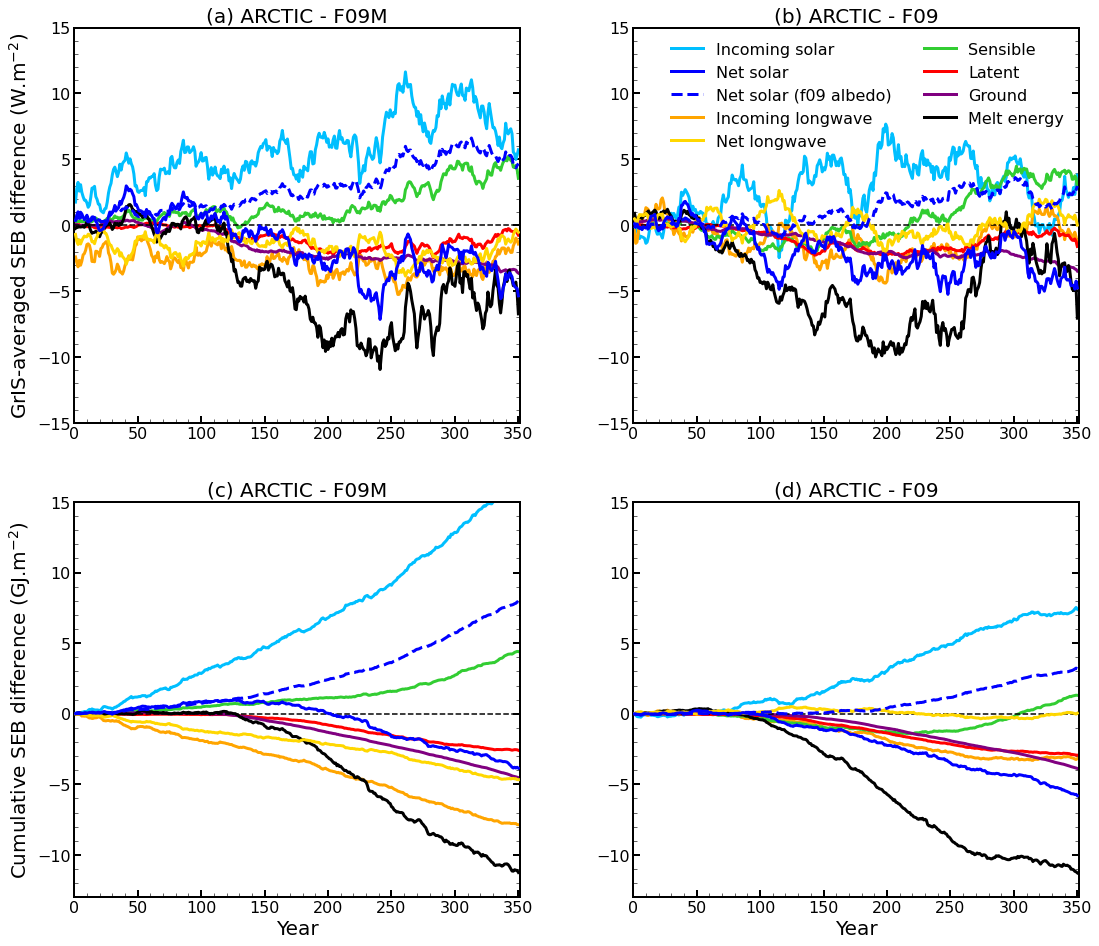

In [109]:
# Change based on initial differences (averaged over last 20 yrs of piControl)
fig = plt.figure(figsize = (18,16))
gs=GridSpec(2,11)
plt.rcParams['axes.linewidth'] = 2 #set the value globally

size_tick = 16
size_label = 20
size_legend = 16
size_text = 20

ARCTICf09m_1pctCO2_4xext_avg_SWd_JJA_diffa = ARCTICf09m_1pctCO2_4xext_avg_SWd_JJA_diff - ARCTICf09m_PI_avg_SWd_JJA_diff
ARCTICf09m_1pctCO2_4xext_avg_SWn_JJA_diffa = ARCTICf09m_1pctCO2_4xext_avg_SWn_JJA_diff - ARCTICf09m_PI_avg_SWn_JJA_diff
ARCTICf09m_F09Malbedo_1pctCO2_4xext_avg_SWn_JJA_diffa = ARCTICf09m_F09Malbedo_1pctCO2_4xext_avg_SWn_JJA_diff - ARCTICf09m_F09Malbedo_PI_avg_SWn_JJA_diff
ARCTICf09m_1pctCO2_4xext_avg_LWd_JJA_diffa = ARCTICf09m_1pctCO2_4xext_avg_LWd_JJA_diff - ARCTICf09m_PI_avg_LWd_JJA_diff
ARCTICf09m_1pctCO2_4xext_avg_LWn_JJA_diffa = ARCTICf09m_1pctCO2_4xext_avg_LWn_JJA_diff - ARCTICf09m_PI_avg_LWn_JJA_diff
ARCTICf09m_1pctCO2_4xext_avg_SHF_JJA_diffa = ARCTICf09m_1pctCO2_4xext_avg_SHF_JJA_diff - ARCTICf09m_PI_avg_SHF_JJA_diff
ARCTICf09m_1pctCO2_4xext_avg_LHF_JJA_diffa = ARCTICf09m_1pctCO2_4xext_avg_LHF_JJA_diff - ARCTICf09m_PI_avg_LHF_JJA_diff
ARCTICf09m_1pctCO2_4xext_avg_GHF_JJA_diffa = ARCTICf09m_1pctCO2_4xext_avg_GHF_JJA_diff - ARCTICf09m_PI_avg_GHF_JJA_diff
ARCTICf09m_1pctCO2_4xext_avg_ME_JJA_diffa = ARCTICf09m_1pctCO2_4xext_avg_ME_JJA_diff - ARCTICf09m_PI_avg_ME_JJA_diff

ARCTICf09_1pctCO2_4xext_avg_SWd_JJA_diffa = ARCTICf09_1pctCO2_4xext_avg_SWd_JJA_diff - ARCTICf09_PI_avg_SWd_JJA_diff
ARCTICf09_1pctCO2_4xext_avg_SWn_JJA_diffa = ARCTICf09_1pctCO2_4xext_avg_SWn_JJA_diff - ARCTICf09_PI_avg_SWn_JJA_diff
ARCTICf09_F09albedo_1pctCO2_4xext_avg_SWn_JJA_diffa = ARCTICf09_F09albedo_1pctCO2_4xext_avg_SWn_JJA_diff - ARCTICf09_F09albedo_PI_avg_SWn_JJA_diff
ARCTICf09_1pctCO2_4xext_avg_LWd_JJA_diffa = ARCTICf09_1pctCO2_4xext_avg_LWd_JJA_diff - ARCTICf09_PI_avg_LWd_JJA_diff
ARCTICf09_1pctCO2_4xext_avg_LWn_JJA_diffa = ARCTICf09_1pctCO2_4xext_avg_LWn_JJA_diff - ARCTICf09_PI_avg_LWn_JJA_diff
ARCTICf09_1pctCO2_4xext_avg_SHF_JJA_diffa = ARCTICf09_1pctCO2_4xext_avg_SHF_JJA_diff - ARCTICf09_PI_avg_SHF_JJA_diff
ARCTICf09_1pctCO2_4xext_avg_LHF_JJA_diffa = ARCTICf09_1pctCO2_4xext_avg_LHF_JJA_diff - ARCTICf09_PI_avg_LHF_JJA_diff
ARCTICf09_1pctCO2_4xext_avg_GHF_JJA_diffa = ARCTICf09_1pctCO2_4xext_avg_GHF_JJA_diff - ARCTICf09_PI_avg_GHF_JJA_diff
ARCTICf09_1pctCO2_4xext_avg_ME_JJA_diffa = ARCTICf09_1pctCO2_4xext_avg_ME_JJA_diff - ARCTICf09_PI_avg_ME_JJA_diff

#-------------------------------------------- ARCTIC-F09M --------------------------------------------
ax1 = plt.subplot(gs[0:1,0:5])

#ax1.plot(np.arange(1,351), ARCTICf09m_1pctCO2_4xext_avg_SWd_JJA_diffa, color='deepskyblue', linewidth=1, alpha=0.3)
#ax1.plot(np.arange(1,351), ARCTICf09m_1pctCO2_4xext_avg_SWn_JJA_diffa, color='blue', linewidth=1, alpha=0.3)
#ax1.plot(np.arange(1,351), ARCTICf09m_1pctCO2_4xext_avg_LWd_JJA_diffa, color='orange', linewidth=1, alpha=0.3)
#ax1.plot(np.arange(1,351), ARCTICf09m_1pctCO2_4xext_avg_LWn_JJA_diffa, color='gold', linewidth=1, alpha=0.3)
#ax1.plot(np.arange(1,351), ARCTICf09m_1pctCO2_4xext_avg_SHF_JJA_diffa, color='limegreen', linewidth=1, alpha=0.3)
#ax1.plot(np.arange(1,351), ARCTICf09m_1pctCO2_4xext_avg_LHF_JJA_diffa, color='red', linewidth=1, alpha=0.3)
#ax1.plot(np.arange(1,351), ARCTICf09m_1pctCO2_4xext_avg_GHF_JJA_diffa, color='purple', linewidth=1, alpha=0.3)
#ax1.plot(np.arange(1,351), ARCTICf09m_1pctCO2_4xext_avg_ME_JJA_diffa, color='black', linewidth=1, alpha=0.3)

ARCTICf09m_1pctCO2_4xext_avg_SWd_JJA_diffa_rm = ARCTICf09m_1pctCO2_4xext_avg_SWd_JJA_diffa.rolling(time=20, center=True, min_periods=2).mean()
ARCTICf09m_1pctCO2_4xext_avg_SWn_JJA_diffa_rm = ARCTICf09m_1pctCO2_4xext_avg_SWn_JJA_diffa.rolling(time=20, center=True, min_periods=2).mean()
ARCTICf09m_F09Malbedo_1pctCO2_4xext_avg_SWn_JJA_diffa_rm = ARCTICf09m_F09Malbedo_1pctCO2_4xext_avg_SWn_JJA_diffa.rolling(time=20, center=True, min_periods=2).mean()
ARCTICf09m_1pctCO2_4xext_avg_LWd_JJA_diffa_rm = ARCTICf09m_1pctCO2_4xext_avg_LWd_JJA_diffa.rolling(time=20, center=True, min_periods=2).mean()
ARCTICf09m_1pctCO2_4xext_avg_LWn_JJA_diffa_rm = ARCTICf09m_1pctCO2_4xext_avg_LWn_JJA_diffa.rolling(time=20, center=True, min_periods=2).mean()
ARCTICf09m_1pctCO2_4xext_avg_SHF_JJA_diffa_rm = ARCTICf09m_1pctCO2_4xext_avg_SHF_JJA_diffa.rolling(time=20, center=True, min_periods=2).mean()
ARCTICf09m_1pctCO2_4xext_avg_LHF_JJA_diffa_rm = ARCTICf09m_1pctCO2_4xext_avg_LHF_JJA_diffa.rolling(time=20, center=True, min_periods=2).mean()
ARCTICf09m_1pctCO2_4xext_avg_GHF_JJA_diffa_rm = ARCTICf09m_1pctCO2_4xext_avg_GHF_JJA_diffa.rolling(time=20, center=True, min_periods=2).mean()
ARCTICf09m_1pctCO2_4xext_avg_ME_JJA_diffa_rm = ARCTICf09m_1pctCO2_4xext_avg_ME_JJA_diffa.rolling(time=20, center=True, min_periods=2).mean()

ax1.plot(np.arange(1,351), ARCTICf09m_1pctCO2_4xext_avg_SWd_JJA_diffa_rm, color='deepskyblue', linewidth=3, label='Incoming solar')
ax1.plot(np.arange(1,351), ARCTICf09m_1pctCO2_4xext_avg_SWn_JJA_diffa_rm, color='blue', linewidth=3, label='Net solar', zorder=4)
ax1.plot(np.arange(1,351), ARCTICf09m_F09Malbedo_1pctCO2_4xext_avg_SWn_JJA_diffa_rm, color='blue', linewidth=3, label='Net solar (f09 albedo)', linestyle='--', zorder=5)
ax1.plot(np.arange(1,351), ARCTICf09m_1pctCO2_4xext_avg_LWd_JJA_diffa_rm, color='orange', linewidth=3, label='Incoming longwave')
ax1.plot(np.arange(1,351), ARCTICf09m_1pctCO2_4xext_avg_LWn_JJA_diffa_rm, color='gold', linewidth=3, label='Net longwave', zorder=3)
ax1.plot(np.arange(1,351), ARCTICf09m_1pctCO2_4xext_avg_SHF_JJA_diffa_rm, color='limegreen', linewidth=3, label='Sensible', zorder=2)
ax1.plot(np.arange(1,351), ARCTICf09m_1pctCO2_4xext_avg_LHF_JJA_diffa_rm, color='red', linewidth=3, label='Latent')
ax1.plot(np.arange(1,351), ARCTICf09m_1pctCO2_4xext_avg_GHF_JJA_diffa_rm, color='purple', linewidth=3, label='Ground')
ax1.plot(np.arange(1,351), ARCTICf09m_1pctCO2_4xext_avg_ME_JJA_diffa_rm, color='black', linewidth=3, label='Melt energy')
ax1.hlines(y = 0, xmin = 0, xmax = 350, colors = 'black', linestyles = '--', linewidth = 1.5)

ax1.set_xlim([0, 351])
ax1.set_ylim([-15, 15])
#ax1.set_xlabel('Year', fontsize=size_label)
ax1.set_ylabel('GrIS-averaged SEB difference (W.$\mathregular{m^{-2}}$)', fontsize=size_label)
ax1.xaxis.set_minor_locator(AutoMinorLocator())
ax1.yaxis.set_minor_locator(AutoMinorLocator())
ax1.tick_params(which='major', length=7, width=2, direction='in', right=True, labelright=False)
ax1.tick_params(which='minor', length=4, direction='in', right=True, labelright=False)
ax1.tick_params(labelsize=size_tick)
plt.title('(a) ARCTIC - F09M', fontsize=size_text)

#ax1.legend(loc = 'best', frameon = False, prop={'size':size_legend}, ncol=2)

#-------------------------------------------- ARCTIC-F09 --------------------------------------------
ax2 = plt.subplot(gs[0:1,6:11])

#ax2.plot(np.arange(1,351), ARCTICf09_1pctCO2_4xext_avg_SWd_JJA_diffa, color='deepskyblue', linewidth=1, alpha=0.3)
#ax2.plot(np.arange(1,351), ARCTICf09_1pctCO2_4xext_avg_SWn_JJA_diffa, color='blue', linewidth=1, alpha=0.3)
#ax2.plot(np.arange(1,351), ARCTICf09_1pctCO2_4xext_avg_LWd_JJA_diffa, color='orange', linewidth=1, alpha=0.3)
#ax2.plot(np.arange(1,351), ARCTICf09_1pctCO2_4xext_avg_LWn_JJA_diffa, color='gold', linewidth=1, alpha=0.3)
#ax2.plot(np.arange(1,351), ARCTICf09_1pctCO2_4xext_avg_SHF_JJA_diffa, color='limegreen', linewidth=1, alpha=0.3)
#ax2.plot(np.arange(1,351), ARCTICf09_1pctCO2_4xext_avg_LHF_JJA_diffa, color='red', linewidth=1, alpha=0.3)
#ax2.plot(np.arange(1,351), ARCTICf09_1pctCO2_4xext_avg_GHF_JJA_diffa, color='purple', linewidth=1, alpha=0.3)
#ax2.plot(np.arange(1,351), ARCTICf09_1pctCO2_4xext_avg_ME_JJA_diffa, color='black', linewidth=1, alpha=0.3)

ARCTICf09_1pctCO2_4xext_avg_SWd_JJA_diffa_rm = ARCTICf09_1pctCO2_4xext_avg_SWd_JJA_diffa.rolling(time=20, center=True, min_periods=2).mean()
ARCTICf09_1pctCO2_4xext_avg_SWn_JJA_diffa_rm = ARCTICf09_1pctCO2_4xext_avg_SWn_JJA_diffa.rolling(time=20, center=True, min_periods=2).mean()
ARCTICf09_F09albedo_1pctCO2_4xext_avg_SWn_JJA_diffa_rm = ARCTICf09_F09albedo_1pctCO2_4xext_avg_SWn_JJA_diffa.rolling(time=20, center=True, min_periods=2).mean()
ARCTICf09_1pctCO2_4xext_avg_LWd_JJA_diffa_rm = ARCTICf09_1pctCO2_4xext_avg_LWd_JJA_diffa.rolling(time=20, center=True, min_periods=2).mean()
ARCTICf09_1pctCO2_4xext_avg_LWn_JJA_diffa_rm = ARCTICf09_1pctCO2_4xext_avg_LWn_JJA_diffa.rolling(time=20, center=True, min_periods=2).mean()
ARCTICf09_1pctCO2_4xext_avg_SHF_JJA_diffa_rm = ARCTICf09_1pctCO2_4xext_avg_SHF_JJA_diffa.rolling(time=20, center=True, min_periods=2).mean()
ARCTICf09_1pctCO2_4xext_avg_LHF_JJA_diffa_rm = ARCTICf09_1pctCO2_4xext_avg_LHF_JJA_diffa.rolling(time=20, center=True, min_periods=2).mean()
ARCTICf09_1pctCO2_4xext_avg_GHF_JJA_diffa_rm = ARCTICf09_1pctCO2_4xext_avg_GHF_JJA_diffa.rolling(time=20, center=True, min_periods=2).mean()
ARCTICf09_1pctCO2_4xext_avg_ME_JJA_diffa_rm = ARCTICf09_1pctCO2_4xext_avg_ME_JJA_diffa.rolling(time=20, center=True, min_periods=2).mean()

ax2.plot(np.arange(1,351), ARCTICf09_1pctCO2_4xext_avg_SWd_JJA_diffa_rm, color='deepskyblue', linewidth=3, label='Incoming solar')
ax2.plot(np.arange(1,351), ARCTICf09_1pctCO2_4xext_avg_SWn_JJA_diffa_rm, color='blue', linewidth=3, label='Net solar', zorder=4)
ax2.plot(np.arange(1,351), ARCTICf09_F09albedo_1pctCO2_4xext_avg_SWn_JJA_diffa_rm, color='blue', linewidth=3, label='Net solar (f09 albedo)', linestyle='--', zorder=5)
ax2.plot(np.arange(1,351), ARCTICf09_1pctCO2_4xext_avg_LWd_JJA_diffa_rm, color='orange', linewidth=3, label='Incoming longwave')
ax2.plot(np.arange(1,351), ARCTICf09_1pctCO2_4xext_avg_LWn_JJA_diffa_rm, color='gold', linewidth=3, label='Net longwave', zorder=3)
ax2.plot(np.arange(1,351), ARCTICf09_1pctCO2_4xext_avg_SHF_JJA_diffa_rm, color='limegreen', linewidth=3, label='Sensible', zorder=2)
ax2.plot(np.arange(1,351), ARCTICf09_1pctCO2_4xext_avg_LHF_JJA_diffa_rm, color='red', linewidth=3, label='Latent')
ax2.plot(np.arange(1,351), ARCTICf09_1pctCO2_4xext_avg_GHF_JJA_diffa_rm, color='purple', linewidth=3, label='Ground')
ax2.plot(np.arange(1,351), ARCTICf09_1pctCO2_4xext_avg_ME_JJA_diffa_rm, color='black', linewidth=3, label='Melt energy')
ax2.hlines(y = 0, xmin = 0, xmax = 350, colors = 'black', linestyles = '--', linewidth = 1.5)

ax2.set_xlim([0, 351])
ax2.set_ylim([-15, 15])
#ax2.set_xlabel('Year', fontsize=size_label)
#ax2.set_ylabel('GrIS-averaged SEB difference (W.$\mathregular{m^{-2}}$)', fontsize=size_label)
ax2.xaxis.set_minor_locator(AutoMinorLocator())
ax2.yaxis.set_minor_locator(AutoMinorLocator())
ax2.tick_params(which='major', length=7, width=2, direction='in', right=True, labelright=False)
ax2.tick_params(which='minor', length=4, direction='in', right=True, labelright=False)
ax2.tick_params(labelsize=size_tick)
plt.title('(b) ARCTIC - F09', fontsize=size_text)

ax2.legend(loc = 'best', frameon = False, prop={'size':size_legend}, ncol=2)

#-------------------------------------------- ARCTIC-F09M accumulated --------------------------------------------
ax3 = plt.subplot(gs[1:2,0:5])

ax3.plot(np.arange(1,351), ARCTICf09m_1pctCO2_4xext_avg_SWd_JJA_diffa.cumsum()*(92*24*3600)/1e9, color='deepskyblue', linewidth=3, label='Incoming solar')
ax3.plot(np.arange(1,351), ARCTICf09m_1pctCO2_4xext_avg_SWn_JJA_diffa.cumsum()*(92*24*3600)/1e9, color='blue', linewidth=3, label='Net solar', zorder=4)
ax3.plot(np.arange(1,351), ARCTICf09m_F09Malbedo_1pctCO2_4xext_avg_SWn_JJA_diffa.cumsum()*(92*24*3600)/1e9, color='blue', linewidth=3, label='Net solar (f09 albedo)', linestyle='--', zorder=5)
ax3.plot(np.arange(1,351), ARCTICf09m_1pctCO2_4xext_avg_LWd_JJA_diffa.cumsum()*(92*24*3600)/1e9, color='orange', linewidth=3, label='Incoming longwave')
ax3.plot(np.arange(1,351), ARCTICf09m_1pctCO2_4xext_avg_LWn_JJA_diffa.cumsum()*(92*24*3600)/1e9, color='gold', linewidth=3, label='Net longwave', zorder=3)
ax3.plot(np.arange(1,351), ARCTICf09m_1pctCO2_4xext_avg_SHF_JJA_diffa.cumsum()*(92*24*3600)/1e9, color='limegreen', linewidth=3, label='Sensible', zorder=2)
ax3.plot(np.arange(1,351), ARCTICf09m_1pctCO2_4xext_avg_LHF_JJA_diffa.cumsum()*(92*24*3600)/1e9, color='red', linewidth=3, label='Latent')
ax3.plot(np.arange(1,351), ARCTICf09m_1pctCO2_4xext_avg_GHF_JJA_diffa.cumsum()*(92*24*3600)/1e9, color='purple', linewidth=3, label='Ground')
ax3.plot(np.arange(1,351), ARCTICf09m_1pctCO2_4xext_avg_ME_JJA_diffa.cumsum()*(92*24*3600)/1e9, color='black', linewidth=3, label='Melt energy')
ax3.hlines(y = 0, xmin = 0, xmax = 350, colors = 'black', linestyles = '--', linewidth = 1.5)

ax3.set_xlim([0, 351])
ax3.set_ylim([-13, 15])
ax3.set_xlabel('Year', fontsize=size_label)
ax3.set_ylabel('Cumulative SEB difference (GJ.$\mathregular{m^{-2}}$)', fontsize=size_label)
ax3.xaxis.set_minor_locator(AutoMinorLocator())
ax3.yaxis.set_minor_locator(AutoMinorLocator())
ax3.tick_params(which='major', length=7, width=2, direction='in', right=True, labelright=False)
ax3.tick_params(which='minor', length=4, direction='in', right=True, labelright=False)
ax3.tick_params(labelsize=size_tick)
plt.title('(c) ARCTIC - F09M', fontsize=size_text)

#-------------------------------------------- ARCTIC-F09 accumulated --------------------------------------------
ax4 = plt.subplot(gs[1:2,6:11])

ax4.plot(np.arange(1,351), ARCTICf09_1pctCO2_4xext_avg_SWd_JJA_diffa.cumsum()*(92*24*3600)/1e9, color='deepskyblue', linewidth=3, label='Incoming solar')
ax4.plot(np.arange(1,351), ARCTICf09_1pctCO2_4xext_avg_SWn_JJA_diffa.cumsum()*(92*24*3600)/1e9, color='blue', linewidth=3, label='Net solar', zorder=4)
ax4.plot(np.arange(1,351), ARCTICf09_F09albedo_1pctCO2_4xext_avg_SWn_JJA_diffa.cumsum()*(92*24*3600)/1e9, color='blue', linewidth=3, label='Net solar (f09 albedo)', linestyle='--', zorder=5)
ax4.plot(np.arange(1,351), ARCTICf09_1pctCO2_4xext_avg_LWd_JJA_diffa.cumsum()*(92*24*3600)/1e9, color='orange', linewidth=3, label='Incoming longwave')
ax4.plot(np.arange(1,351), ARCTICf09_1pctCO2_4xext_avg_LWn_JJA_diffa.cumsum()*(92*24*3600)/1e9, color='gold', linewidth=3, label='Net longwave', zorder=3)
ax4.plot(np.arange(1,351), ARCTICf09_1pctCO2_4xext_avg_SHF_JJA_diffa.cumsum()*(92*24*3600)/1e9, color='limegreen', linewidth=3, label='Sensible', zorder=2)
ax4.plot(np.arange(1,351), ARCTICf09_1pctCO2_4xext_avg_LHF_JJA_diffa.cumsum()*(92*24*3600)/1e9, color='red', linewidth=3, label='Latent')
ax4.plot(np.arange(1,351), ARCTICf09_1pctCO2_4xext_avg_GHF_JJA_diffa.cumsum()*(92*24*3600)/1e9, color='purple', linewidth=3, label='Ground')
ax4.plot(np.arange(1,351), ARCTICf09_1pctCO2_4xext_avg_ME_JJA_diffa.cumsum()*(92*24*3600)/1e9, color='black', linewidth=3, label='Melt energy')
ax4.hlines(y = 0, xmin = 0, xmax = 350, colors = 'black', linestyles = '--', linewidth = 1.5)

ax4.set_xlim([0, 351])
ax4.set_ylim([-13, 15])
ax4.set_xlabel('Year', fontsize=size_label)
#ax4.set_ylabel('Cumulative SEB difference (W.$\mathregular{m^{-2}}$)', fontsize=size_label)
ax4.xaxis.set_minor_locator(AutoMinorLocator())
ax4.yaxis.set_minor_locator(AutoMinorLocator())
ax4.tick_params(which='major', length=7, width=2, direction='in', right=True, labelright=False)
ax4.tick_params(which='minor', length=4, direction='in', right=True, labelright=False)
ax4.tick_params(labelsize=size_tick)
plt.title('(d) ARCTIC - F09', fontsize=size_text)

plt.subplots_adjust(wspace=0.28)
plt.savefig(home_dir+'2022-VR-dynamic-GrIS/github/plot/tseries_SEB_anomaly_cumanomaly_ARCTICf09mf09_comparedtoPI20_coralbedo.png', dpi=300, bbox_inches='tight', facecolor='w', transparent=False) #

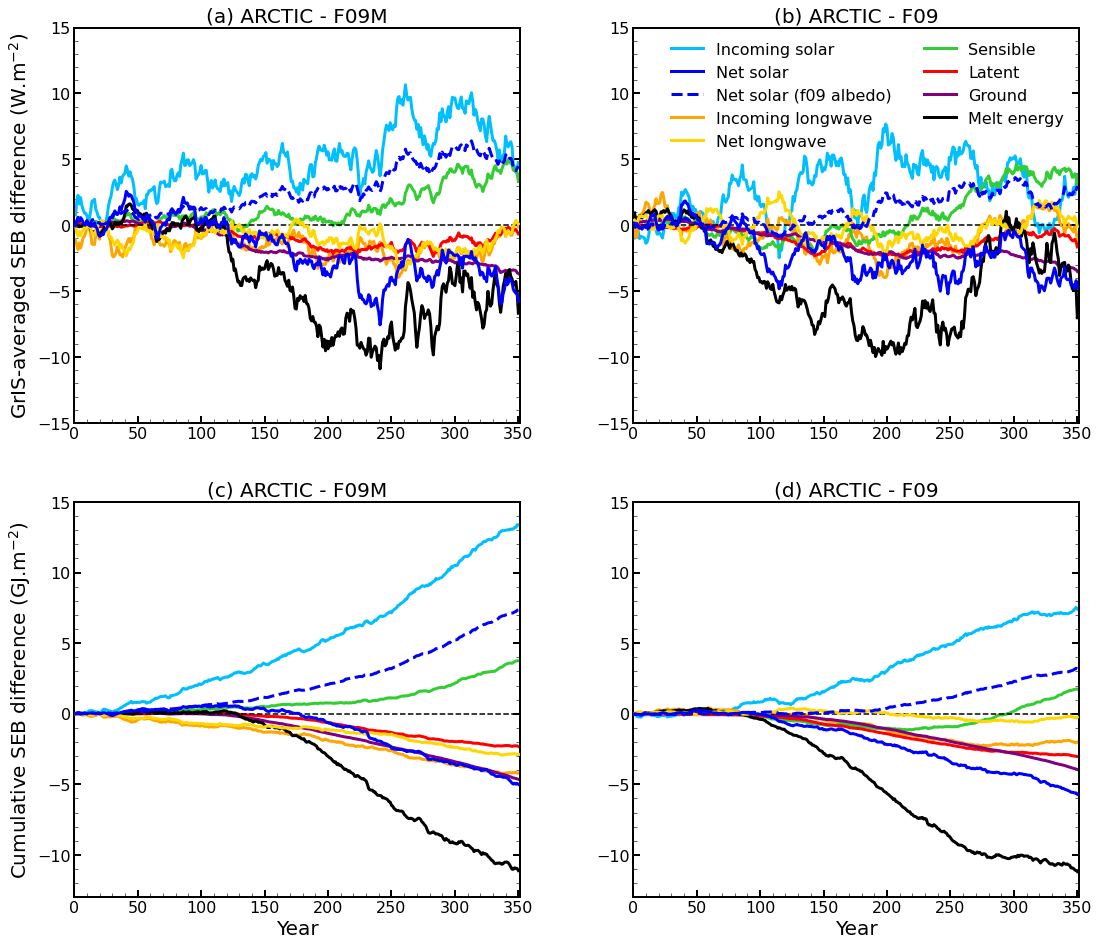

In [44]:
# Change based on initial differences (averaged over last 30 yrs of piControl)
fig = plt.figure(figsize = (18,16))
gs=GridSpec(2,11)
plt.rcParams['axes.linewidth'] = 2 #set the value globally

size_tick = 16
size_label = 20
size_legend = 16
size_text = 20

ARCTICf09m_1pctCO2_4xext_avg_SWd_JJA_diffa = ARCTICf09m_1pctCO2_4xext_avg_SWd_JJA_diff - ARCTICf09m_PI_avg_SWd_JJA_diff
ARCTICf09m_1pctCO2_4xext_avg_SWn_JJA_diffa = ARCTICf09m_1pctCO2_4xext_avg_SWn_JJA_diff - ARCTICf09m_PI_avg_SWn_JJA_diff
ARCTICf09m_F09Malbedo_1pctCO2_4xext_avg_SWn_JJA_diffa = ARCTICf09m_F09Malbedo_1pctCO2_4xext_avg_SWn_JJA_diff - ARCTICf09m_F09Malbedo_PI_avg_SWn_JJA_diff
ARCTICf09m_1pctCO2_4xext_avg_LWd_JJA_diffa = ARCTICf09m_1pctCO2_4xext_avg_LWd_JJA_diff - ARCTICf09m_PI_avg_LWd_JJA_diff
ARCTICf09m_1pctCO2_4xext_avg_LWn_JJA_diffa = ARCTICf09m_1pctCO2_4xext_avg_LWn_JJA_diff - ARCTICf09m_PI_avg_LWn_JJA_diff
ARCTICf09m_1pctCO2_4xext_avg_SHF_JJA_diffa = ARCTICf09m_1pctCO2_4xext_avg_SHF_JJA_diff - ARCTICf09m_PI_avg_SHF_JJA_diff
ARCTICf09m_1pctCO2_4xext_avg_LHF_JJA_diffa = ARCTICf09m_1pctCO2_4xext_avg_LHF_JJA_diff - ARCTICf09m_PI_avg_LHF_JJA_diff
ARCTICf09m_1pctCO2_4xext_avg_GHF_JJA_diffa = ARCTICf09m_1pctCO2_4xext_avg_GHF_JJA_diff - ARCTICf09m_PI_avg_GHF_JJA_diff
ARCTICf09m_1pctCO2_4xext_avg_ME_JJA_diffa = ARCTICf09m_1pctCO2_4xext_avg_ME_JJA_diff - ARCTICf09m_PI_avg_ME_JJA_diff

ARCTICf09_1pctCO2_4xext_avg_SWd_JJA_diffa = ARCTICf09_1pctCO2_4xext_avg_SWd_JJA_diff - ARCTICf09_PI_avg_SWd_JJA_diff
ARCTICf09_1pctCO2_4xext_avg_SWn_JJA_diffa = ARCTICf09_1pctCO2_4xext_avg_SWn_JJA_diff - ARCTICf09_PI_avg_SWn_JJA_diff
ARCTICf09_F09albedo_1pctCO2_4xext_avg_SWn_JJA_diffa = ARCTICf09_F09albedo_1pctCO2_4xext_avg_SWn_JJA_diff - ARCTICf09_F09albedo_PI_avg_SWn_JJA_diff
ARCTICf09_1pctCO2_4xext_avg_LWd_JJA_diffa = ARCTICf09_1pctCO2_4xext_avg_LWd_JJA_diff - ARCTICf09_PI_avg_LWd_JJA_diff
ARCTICf09_1pctCO2_4xext_avg_LWn_JJA_diffa = ARCTICf09_1pctCO2_4xext_avg_LWn_JJA_diff - ARCTICf09_PI_avg_LWn_JJA_diff
ARCTICf09_1pctCO2_4xext_avg_SHF_JJA_diffa = ARCTICf09_1pctCO2_4xext_avg_SHF_JJA_diff - ARCTICf09_PI_avg_SHF_JJA_diff
ARCTICf09_1pctCO2_4xext_avg_LHF_JJA_diffa = ARCTICf09_1pctCO2_4xext_avg_LHF_JJA_diff - ARCTICf09_PI_avg_LHF_JJA_diff
ARCTICf09_1pctCO2_4xext_avg_GHF_JJA_diffa = ARCTICf09_1pctCO2_4xext_avg_GHF_JJA_diff - ARCTICf09_PI_avg_GHF_JJA_diff
ARCTICf09_1pctCO2_4xext_avg_ME_JJA_diffa = ARCTICf09_1pctCO2_4xext_avg_ME_JJA_diff - ARCTICf09_PI_avg_ME_JJA_diff

#-------------------------------------------- ARCTIC-F09M --------------------------------------------
ax1 = plt.subplot(gs[0:1,0:5])

#ax1.plot(np.arange(1,351), ARCTICf09m_1pctCO2_4xext_avg_SWd_JJA_diffa, color='deepskyblue', linewidth=1, alpha=0.3)
#ax1.plot(np.arange(1,351), ARCTICf09m_1pctCO2_4xext_avg_SWn_JJA_diffa, color='blue', linewidth=1, alpha=0.3)
#ax1.plot(np.arange(1,351), ARCTICf09m_1pctCO2_4xext_avg_LWd_JJA_diffa, color='orange', linewidth=1, alpha=0.3)
#ax1.plot(np.arange(1,351), ARCTICf09m_1pctCO2_4xext_avg_LWn_JJA_diffa, color='gold', linewidth=1, alpha=0.3)
#ax1.plot(np.arange(1,351), ARCTICf09m_1pctCO2_4xext_avg_SHF_JJA_diffa, color='limegreen', linewidth=1, alpha=0.3)
#ax1.plot(np.arange(1,351), ARCTICf09m_1pctCO2_4xext_avg_LHF_JJA_diffa, color='red', linewidth=1, alpha=0.3)
#ax1.plot(np.arange(1,351), ARCTICf09m_1pctCO2_4xext_avg_GHF_JJA_diffa, color='purple', linewidth=1, alpha=0.3)
#ax1.plot(np.arange(1,351), ARCTICf09m_1pctCO2_4xext_avg_ME_JJA_diffa, color='black', linewidth=1, alpha=0.3)

ARCTICf09m_1pctCO2_4xext_avg_SWd_JJA_diffa_rm = ARCTICf09m_1pctCO2_4xext_avg_SWd_JJA_diffa.rolling(time=20, center=True, min_periods=2).mean()
ARCTICf09m_1pctCO2_4xext_avg_SWn_JJA_diffa_rm = ARCTICf09m_1pctCO2_4xext_avg_SWn_JJA_diffa.rolling(time=20, center=True, min_periods=2).mean()
ARCTICf09m_F09Malbedo_1pctCO2_4xext_avg_SWn_JJA_diffa_rm = ARCTICf09m_F09Malbedo_1pctCO2_4xext_avg_SWn_JJA_diffa.rolling(time=20, center=True, min_periods=2).mean()
ARCTICf09m_1pctCO2_4xext_avg_LWd_JJA_diffa_rm = ARCTICf09m_1pctCO2_4xext_avg_LWd_JJA_diffa.rolling(time=20, center=True, min_periods=2).mean()
ARCTICf09m_1pctCO2_4xext_avg_LWn_JJA_diffa_rm = ARCTICf09m_1pctCO2_4xext_avg_LWn_JJA_diffa.rolling(time=20, center=True, min_periods=2).mean()
ARCTICf09m_1pctCO2_4xext_avg_SHF_JJA_diffa_rm = ARCTICf09m_1pctCO2_4xext_avg_SHF_JJA_diffa.rolling(time=20, center=True, min_periods=2).mean()
ARCTICf09m_1pctCO2_4xext_avg_LHF_JJA_diffa_rm = ARCTICf09m_1pctCO2_4xext_avg_LHF_JJA_diffa.rolling(time=20, center=True, min_periods=2).mean()
ARCTICf09m_1pctCO2_4xext_avg_GHF_JJA_diffa_rm = ARCTICf09m_1pctCO2_4xext_avg_GHF_JJA_diffa.rolling(time=20, center=True, min_periods=2).mean()
ARCTICf09m_1pctCO2_4xext_avg_ME_JJA_diffa_rm = ARCTICf09m_1pctCO2_4xext_avg_ME_JJA_diffa.rolling(time=20, center=True, min_periods=2).mean()

ax1.plot(np.arange(1,351), ARCTICf09m_1pctCO2_4xext_avg_SWd_JJA_diffa_rm, color='deepskyblue', linewidth=3, label='Incoming solar')
ax1.plot(np.arange(1,351), ARCTICf09m_1pctCO2_4xext_avg_SWn_JJA_diffa_rm, color='blue', linewidth=3, label='Net solar', zorder=4)
ax1.plot(np.arange(1,351), ARCTICf09m_F09Malbedo_1pctCO2_4xext_avg_SWn_JJA_diffa_rm, color='blue', linewidth=3, label='Net solar (f09 albedo)', linestyle='--', zorder=5)
ax1.plot(np.arange(1,351), ARCTICf09m_1pctCO2_4xext_avg_LWd_JJA_diffa_rm, color='orange', linewidth=3, label='Incoming longwave')
ax1.plot(np.arange(1,351), ARCTICf09m_1pctCO2_4xext_avg_LWn_JJA_diffa_rm, color='gold', linewidth=3, label='Net longwave', zorder=3)
ax1.plot(np.arange(1,351), ARCTICf09m_1pctCO2_4xext_avg_SHF_JJA_diffa_rm, color='limegreen', linewidth=3, label='Sensible', zorder=2)
ax1.plot(np.arange(1,351), ARCTICf09m_1pctCO2_4xext_avg_LHF_JJA_diffa_rm, color='red', linewidth=3, label='Latent')
ax1.plot(np.arange(1,351), ARCTICf09m_1pctCO2_4xext_avg_GHF_JJA_diffa_rm, color='purple', linewidth=3, label='Ground')
ax1.plot(np.arange(1,351), ARCTICf09m_1pctCO2_4xext_avg_ME_JJA_diffa_rm, color='black', linewidth=3, label='Melt energy')
ax1.hlines(y = 0, xmin = 0, xmax = 350, colors = 'black', linestyles = '--', linewidth = 1.5)

ax1.set_xlim([0, 351])
ax1.set_ylim([-15, 15])
#ax1.set_xlabel('Year', fontsize=size_label)
ax1.set_ylabel('GrIS-averaged SEB difference (W.$\mathregular{m^{-2}}$)', fontsize=size_label)
ax1.xaxis.set_minor_locator(AutoMinorLocator())
ax1.yaxis.set_minor_locator(AutoMinorLocator())
ax1.tick_params(which='major', length=7, width=2, direction='in', right=True, labelright=False)
ax1.tick_params(which='minor', length=4, direction='in', right=True, labelright=False)
ax1.tick_params(labelsize=size_tick)
plt.title('(a) ARCTIC - F09M', fontsize=size_text)

#ax1.legend(loc = 'best', frameon = False, prop={'size':size_legend}, ncol=2)

#-------------------------------------------- ARCTIC-F09 --------------------------------------------
ax2 = plt.subplot(gs[0:1,6:11])

#ax2.plot(np.arange(1,351), ARCTICf09_1pctCO2_4xext_avg_SWd_JJA_diffa, color='deepskyblue', linewidth=1, alpha=0.3)
#ax2.plot(np.arange(1,351), ARCTICf09_1pctCO2_4xext_avg_SWn_JJA_diffa, color='blue', linewidth=1, alpha=0.3)
#ax2.plot(np.arange(1,351), ARCTICf09_1pctCO2_4xext_avg_LWd_JJA_diffa, color='orange', linewidth=1, alpha=0.3)
#ax2.plot(np.arange(1,351), ARCTICf09_1pctCO2_4xext_avg_LWn_JJA_diffa, color='gold', linewidth=1, alpha=0.3)
#ax2.plot(np.arange(1,351), ARCTICf09_1pctCO2_4xext_avg_SHF_JJA_diffa, color='limegreen', linewidth=1, alpha=0.3)
#ax2.plot(np.arange(1,351), ARCTICf09_1pctCO2_4xext_avg_LHF_JJA_diffa, color='red', linewidth=1, alpha=0.3)
#ax2.plot(np.arange(1,351), ARCTICf09_1pctCO2_4xext_avg_GHF_JJA_diffa, color='purple', linewidth=1, alpha=0.3)
#ax2.plot(np.arange(1,351), ARCTICf09_1pctCO2_4xext_avg_ME_JJA_diffa, color='black', linewidth=1, alpha=0.3)

ARCTICf09_1pctCO2_4xext_avg_SWd_JJA_diffa_rm = ARCTICf09_1pctCO2_4xext_avg_SWd_JJA_diffa.rolling(time=20, center=True, min_periods=2).mean()
ARCTICf09_1pctCO2_4xext_avg_SWn_JJA_diffa_rm = ARCTICf09_1pctCO2_4xext_avg_SWn_JJA_diffa.rolling(time=20, center=True, min_periods=2).mean()
ARCTICf09_F09albedo_1pctCO2_4xext_avg_SWn_JJA_diffa_rm = ARCTICf09_F09albedo_1pctCO2_4xext_avg_SWn_JJA_diffa.rolling(time=20, center=True, min_periods=2).mean()
ARCTICf09_1pctCO2_4xext_avg_LWd_JJA_diffa_rm = ARCTICf09_1pctCO2_4xext_avg_LWd_JJA_diffa.rolling(time=20, center=True, min_periods=2).mean()
ARCTICf09_1pctCO2_4xext_avg_LWn_JJA_diffa_rm = ARCTICf09_1pctCO2_4xext_avg_LWn_JJA_diffa.rolling(time=20, center=True, min_periods=2).mean()
ARCTICf09_1pctCO2_4xext_avg_SHF_JJA_diffa_rm = ARCTICf09_1pctCO2_4xext_avg_SHF_JJA_diffa.rolling(time=20, center=True, min_periods=2).mean()
ARCTICf09_1pctCO2_4xext_avg_LHF_JJA_diffa_rm = ARCTICf09_1pctCO2_4xext_avg_LHF_JJA_diffa.rolling(time=20, center=True, min_periods=2).mean()
ARCTICf09_1pctCO2_4xext_avg_GHF_JJA_diffa_rm = ARCTICf09_1pctCO2_4xext_avg_GHF_JJA_diffa.rolling(time=20, center=True, min_periods=2).mean()
ARCTICf09_1pctCO2_4xext_avg_ME_JJA_diffa_rm = ARCTICf09_1pctCO2_4xext_avg_ME_JJA_diffa.rolling(time=20, center=True, min_periods=2).mean()

ax2.plot(np.arange(1,351), ARCTICf09_1pctCO2_4xext_avg_SWd_JJA_diffa_rm, color='deepskyblue', linewidth=3, label='Incoming solar')
ax2.plot(np.arange(1,351), ARCTICf09_1pctCO2_4xext_avg_SWn_JJA_diffa_rm, color='blue', linewidth=3, label='Net solar', zorder=4)
ax2.plot(np.arange(1,351), ARCTICf09_F09albedo_1pctCO2_4xext_avg_SWn_JJA_diffa_rm, color='blue', linewidth=3, label='Net solar (f09 albedo)', linestyle='--', zorder=5)
ax2.plot(np.arange(1,351), ARCTICf09_1pctCO2_4xext_avg_LWd_JJA_diffa_rm, color='orange', linewidth=3, label='Incoming longwave')
ax2.plot(np.arange(1,351), ARCTICf09_1pctCO2_4xext_avg_LWn_JJA_diffa_rm, color='gold', linewidth=3, label='Net longwave', zorder=3)
ax2.plot(np.arange(1,351), ARCTICf09_1pctCO2_4xext_avg_SHF_JJA_diffa_rm, color='limegreen', linewidth=3, label='Sensible', zorder=2)
ax2.plot(np.arange(1,351), ARCTICf09_1pctCO2_4xext_avg_LHF_JJA_diffa_rm, color='red', linewidth=3, label='Latent')
ax2.plot(np.arange(1,351), ARCTICf09_1pctCO2_4xext_avg_GHF_JJA_diffa_rm, color='purple', linewidth=3, label='Ground')
ax2.plot(np.arange(1,351), ARCTICf09_1pctCO2_4xext_avg_ME_JJA_diffa_rm, color='black', linewidth=3, label='Melt energy')
ax2.hlines(y = 0, xmin = 0, xmax = 350, colors = 'black', linestyles = '--', linewidth = 1.5)

ax2.set_xlim([0, 351])
ax2.set_ylim([-15, 15])
#ax2.set_xlabel('Year', fontsize=size_label)
#ax2.set_ylabel('GrIS-averaged SEB difference (W.$\mathregular{m^{-2}}$)', fontsize=size_label)
ax2.xaxis.set_minor_locator(AutoMinorLocator())
ax2.yaxis.set_minor_locator(AutoMinorLocator())
ax2.tick_params(which='major', length=7, width=2, direction='in', right=True, labelright=False)
ax2.tick_params(which='minor', length=4, direction='in', right=True, labelright=False)
ax2.tick_params(labelsize=size_tick)
plt.title('(b) ARCTIC - F09', fontsize=size_text)

ax2.legend(loc = 'best', frameon = False, prop={'size':size_legend}, ncol=2)

#-------------------------------------------- ARCTIC-F09M accumulated --------------------------------------------
ax3 = plt.subplot(gs[1:2,0:5])

ax3.plot(np.arange(1,351), ARCTICf09m_1pctCO2_4xext_avg_SWd_JJA_diffa.cumsum()*(92*24*3600)/1e9, color='deepskyblue', linewidth=3, label='Incoming solar')
ax3.plot(np.arange(1,351), ARCTICf09m_1pctCO2_4xext_avg_SWn_JJA_diffa.cumsum()*(92*24*3600)/1e9, color='blue', linewidth=3, label='Net solar', zorder=4)
ax3.plot(np.arange(1,351), ARCTICf09m_F09Malbedo_1pctCO2_4xext_avg_SWn_JJA_diffa.cumsum()*(92*24*3600)/1e9, color='blue', linewidth=3, label='Net solar (f09 albedo)', linestyle='--', zorder=5)
ax3.plot(np.arange(1,351), ARCTICf09m_1pctCO2_4xext_avg_LWd_JJA_diffa.cumsum()*(92*24*3600)/1e9, color='orange', linewidth=3, label='Incoming longwave')
ax3.plot(np.arange(1,351), ARCTICf09m_1pctCO2_4xext_avg_LWn_JJA_diffa.cumsum()*(92*24*3600)/1e9, color='gold', linewidth=3, label='Net longwave', zorder=3)
ax3.plot(np.arange(1,351), ARCTICf09m_1pctCO2_4xext_avg_SHF_JJA_diffa.cumsum()*(92*24*3600)/1e9, color='limegreen', linewidth=3, label='Sensible', zorder=2)
ax3.plot(np.arange(1,351), ARCTICf09m_1pctCO2_4xext_avg_LHF_JJA_diffa.cumsum()*(92*24*3600)/1e9, color='red', linewidth=3, label='Latent')
ax3.plot(np.arange(1,351), ARCTICf09m_1pctCO2_4xext_avg_GHF_JJA_diffa.cumsum()*(92*24*3600)/1e9, color='purple', linewidth=3, label='Ground')
ax3.plot(np.arange(1,351), ARCTICf09m_1pctCO2_4xext_avg_ME_JJA_diffa.cumsum()*(92*24*3600)/1e9, color='black', linewidth=3, label='Melt energy')
ax3.hlines(y = 0, xmin = 0, xmax = 350, colors = 'black', linestyles = '--', linewidth = 1.5)

ax3.set_xlim([0, 351])
ax3.set_ylim([-13, 15])
ax3.set_xlabel('Year', fontsize=size_label)
ax3.set_ylabel('Cumulative SEB difference (GJ.$\mathregular{m^{-2}}$)', fontsize=size_label)
ax3.xaxis.set_minor_locator(AutoMinorLocator())
ax3.yaxis.set_minor_locator(AutoMinorLocator())
ax3.tick_params(which='major', length=7, width=2, direction='in', right=True, labelright=False)
ax3.tick_params(which='minor', length=4, direction='in', right=True, labelright=False)
ax3.tick_params(labelsize=size_tick)
plt.title('(c) ARCTIC - F09M', fontsize=size_text)

#-------------------------------------------- ARCTIC-F09 accumulated --------------------------------------------
ax4 = plt.subplot(gs[1:2,6:11])

ax4.plot(np.arange(1,351), ARCTICf09_1pctCO2_4xext_avg_SWd_JJA_diffa.cumsum()*(92*24*3600)/1e9, color='deepskyblue', linewidth=3, label='Incoming solar')
ax4.plot(np.arange(1,351), ARCTICf09_1pctCO2_4xext_avg_SWn_JJA_diffa.cumsum()*(92*24*3600)/1e9, color='blue', linewidth=3, label='Net solar', zorder=4)
ax4.plot(np.arange(1,351), ARCTICf09_F09albedo_1pctCO2_4xext_avg_SWn_JJA_diffa.cumsum()*(92*24*3600)/1e9, color='blue', linewidth=3, label='Net solar (f09 albedo)', linestyle='--', zorder=5)
ax4.plot(np.arange(1,351), ARCTICf09_1pctCO2_4xext_avg_LWd_JJA_diffa.cumsum()*(92*24*3600)/1e9, color='orange', linewidth=3, label='Incoming longwave')
ax4.plot(np.arange(1,351), ARCTICf09_1pctCO2_4xext_avg_LWn_JJA_diffa.cumsum()*(92*24*3600)/1e9, color='gold', linewidth=3, label='Net longwave', zorder=3)
ax4.plot(np.arange(1,351), ARCTICf09_1pctCO2_4xext_avg_SHF_JJA_diffa.cumsum()*(92*24*3600)/1e9, color='limegreen', linewidth=3, label='Sensible', zorder=2)
ax4.plot(np.arange(1,351), ARCTICf09_1pctCO2_4xext_avg_LHF_JJA_diffa.cumsum()*(92*24*3600)/1e9, color='red', linewidth=3, label='Latent')
ax4.plot(np.arange(1,351), ARCTICf09_1pctCO2_4xext_avg_GHF_JJA_diffa.cumsum()*(92*24*3600)/1e9, color='purple', linewidth=3, label='Ground')
ax4.plot(np.arange(1,351), ARCTICf09_1pctCO2_4xext_avg_ME_JJA_diffa.cumsum()*(92*24*3600)/1e9, color='black', linewidth=3, label='Melt energy')
ax4.hlines(y = 0, xmin = 0, xmax = 350, colors = 'black', linestyles = '--', linewidth = 1.5)

ax4.set_xlim([0, 351])
ax4.set_ylim([-13, 15])
ax4.set_xlabel('Year', fontsize=size_label)
#ax4.set_ylabel('Cumulative SEB difference (W.$\mathregular{m^{-2}}$)', fontsize=size_label)
ax4.xaxis.set_minor_locator(AutoMinorLocator())
ax4.yaxis.set_minor_locator(AutoMinorLocator())
ax4.tick_params(which='major', length=7, width=2, direction='in', right=True, labelright=False)
ax4.tick_params(which='minor', length=4, direction='in', right=True, labelright=False)
ax4.tick_params(labelsize=size_tick)
plt.title('(d) ARCTIC - F09', fontsize=size_text)

plt.subplots_adjust(wspace=0.28)
plt.savefig(home_dir+'2022-VR-dynamic-GrIS/github/plot/tseries_SEB_anomaly_cumanomaly_ARCTICf09mf09_comparedtoPI30_coralbedo.png', dpi=300, bbox_inches='tight', facecolor='w', transparent=False) #

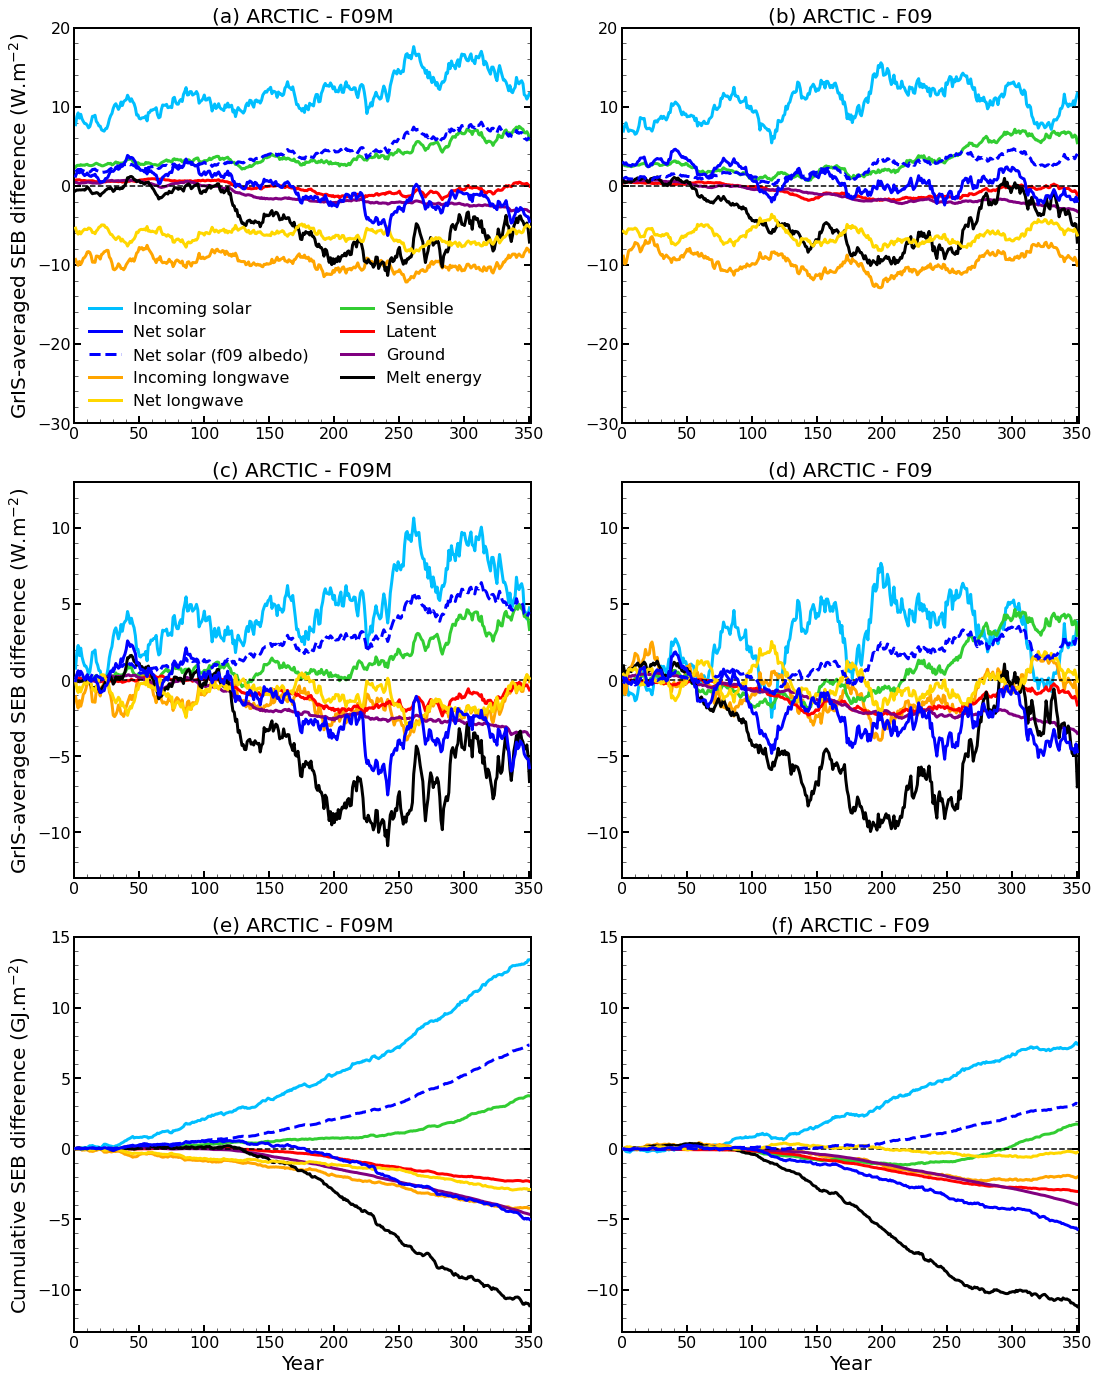

In [27]:
# Differences + change based on initial differences (averaged over last 30 yrs of piControl) + cumulative changes
fig = plt.figure(figsize = (18,24))
gs=GridSpec(3,11)
plt.rcParams['axes.linewidth'] = 2 #set the value globally

size_tick = 16
size_label = 20
size_legend = 16
size_text = 20

ARCTICf09m_1pctCO2_4xext_avg_SWd_JJA_diffa = ARCTICf09m_1pctCO2_4xext_avg_SWd_JJA_diff - ARCTICf09m_PI_avg_SWd_JJA_diff
ARCTICf09m_1pctCO2_4xext_avg_SWn_JJA_diffa = ARCTICf09m_1pctCO2_4xext_avg_SWn_JJA_diff - ARCTICf09m_PI_avg_SWn_JJA_diff
ARCTICf09m_F09Malbedo_1pctCO2_4xext_avg_SWn_JJA_diffa = ARCTICf09m_F09Malbedo_1pctCO2_4xext_avg_SWn_JJA_diff - ARCTICf09m_F09Malbedo_PI_avg_SWn_JJA_diff
ARCTICf09m_1pctCO2_4xext_avg_LWd_JJA_diffa = ARCTICf09m_1pctCO2_4xext_avg_LWd_JJA_diff - ARCTICf09m_PI_avg_LWd_JJA_diff
ARCTICf09m_1pctCO2_4xext_avg_LWn_JJA_diffa = ARCTICf09m_1pctCO2_4xext_avg_LWn_JJA_diff - ARCTICf09m_PI_avg_LWn_JJA_diff
ARCTICf09m_1pctCO2_4xext_avg_SHF_JJA_diffa = ARCTICf09m_1pctCO2_4xext_avg_SHF_JJA_diff - ARCTICf09m_PI_avg_SHF_JJA_diff
ARCTICf09m_1pctCO2_4xext_avg_LHF_JJA_diffa = ARCTICf09m_1pctCO2_4xext_avg_LHF_JJA_diff - ARCTICf09m_PI_avg_LHF_JJA_diff
ARCTICf09m_1pctCO2_4xext_avg_GHF_JJA_diffa = ARCTICf09m_1pctCO2_4xext_avg_GHF_JJA_diff - ARCTICf09m_PI_avg_GHF_JJA_diff
ARCTICf09m_1pctCO2_4xext_avg_ME_JJA_diffa = ARCTICf09m_1pctCO2_4xext_avg_ME_JJA_diff - ARCTICf09m_PI_avg_ME_JJA_diff

ARCTICf09_1pctCO2_4xext_avg_SWd_JJA_diffa = ARCTICf09_1pctCO2_4xext_avg_SWd_JJA_diff - ARCTICf09_PI_avg_SWd_JJA_diff
ARCTICf09_1pctCO2_4xext_avg_SWn_JJA_diffa = ARCTICf09_1pctCO2_4xext_avg_SWn_JJA_diff - ARCTICf09_PI_avg_SWn_JJA_diff
ARCTICf09_F09albedo_1pctCO2_4xext_avg_SWn_JJA_diffa = ARCTICf09_F09albedo_1pctCO2_4xext_avg_SWn_JJA_diff - ARCTICf09_F09albedo_PI_avg_SWn_JJA_diff
ARCTICf09_1pctCO2_4xext_avg_LWd_JJA_diffa = ARCTICf09_1pctCO2_4xext_avg_LWd_JJA_diff - ARCTICf09_PI_avg_LWd_JJA_diff
ARCTICf09_1pctCO2_4xext_avg_LWn_JJA_diffa = ARCTICf09_1pctCO2_4xext_avg_LWn_JJA_diff - ARCTICf09_PI_avg_LWn_JJA_diff
ARCTICf09_1pctCO2_4xext_avg_SHF_JJA_diffa = ARCTICf09_1pctCO2_4xext_avg_SHF_JJA_diff - ARCTICf09_PI_avg_SHF_JJA_diff
ARCTICf09_1pctCO2_4xext_avg_LHF_JJA_diffa = ARCTICf09_1pctCO2_4xext_avg_LHF_JJA_diff - ARCTICf09_PI_avg_LHF_JJA_diff
ARCTICf09_1pctCO2_4xext_avg_GHF_JJA_diffa = ARCTICf09_1pctCO2_4xext_avg_GHF_JJA_diff - ARCTICf09_PI_avg_GHF_JJA_diff
ARCTICf09_1pctCO2_4xext_avg_ME_JJA_diffa = ARCTICf09_1pctCO2_4xext_avg_ME_JJA_diff - ARCTICf09_PI_avg_ME_JJA_diff

#-------------------------------------------- ARCTIC-F09M --------------------------------------------
ax1 = plt.subplot(gs[0:1,0:5])

ARCTICf09m_1pctCO2_4xext_avg_SWd_JJA_diff_rm = ARCTICf09m_1pctCO2_4xext_avg_SWd_JJA_diff.rolling(time=20, center=True, min_periods=2).mean()
ARCTICf09m_1pctCO2_4xext_avg_SWn_JJA_diff_rm = ARCTICf09m_1pctCO2_4xext_avg_SWn_JJA_diff.rolling(time=20, center=True, min_periods=2).mean()
ARCTICf09m_F09Malbedo_1pctCO2_4xext_avg_SWn_JJA_diff_rm = ARCTICf09m_F09Malbedo_1pctCO2_4xext_avg_SWn_JJA_diff.rolling(time=20, center=True, min_periods=2).mean()
ARCTICf09m_1pctCO2_4xext_avg_LWd_JJA_diff_rm = ARCTICf09m_1pctCO2_4xext_avg_LWd_JJA_diff.rolling(time=20, center=True, min_periods=2).mean()
ARCTICf09m_1pctCO2_4xext_avg_LWn_JJA_diff_rm = ARCTICf09m_1pctCO2_4xext_avg_LWn_JJA_diff.rolling(time=20, center=True, min_periods=2).mean()
ARCTICf09m_1pctCO2_4xext_avg_SHF_JJA_diff_rm = ARCTICf09m_1pctCO2_4xext_avg_SHF_JJA_diff.rolling(time=20, center=True, min_periods=2).mean()
ARCTICf09m_1pctCO2_4xext_avg_LHF_JJA_diff_rm = ARCTICf09m_1pctCO2_4xext_avg_LHF_JJA_diff.rolling(time=20, center=True, min_periods=2).mean()
ARCTICf09m_1pctCO2_4xext_avg_GHF_JJA_diff_rm = ARCTICf09m_1pctCO2_4xext_avg_GHF_JJA_diff.rolling(time=20, center=True, min_periods=2).mean()
ARCTICf09m_1pctCO2_4xext_avg_ME_JJA_diff_rm = ARCTICf09m_1pctCO2_4xext_avg_ME_JJA_diff.rolling(time=20, center=True, min_periods=2).mean()

ax1.plot(np.arange(1,351), ARCTICf09m_1pctCO2_4xext_avg_SWd_JJA_diff_rm, color='deepskyblue', linewidth=3, label='Incoming solar')
ax1.plot(np.arange(1,351), ARCTICf09m_1pctCO2_4xext_avg_SWn_JJA_diff_rm, color='blue', linewidth=3, label='Net solar', zorder=4)
ax1.plot(np.arange(1,351), ARCTICf09m_F09Malbedo_1pctCO2_4xext_avg_SWn_JJA_diff_rm, color='blue', linewidth=3, label='Net solar (f09 albedo)', linestyle='--', zorder=5)
ax1.plot(np.arange(1,351), ARCTICf09m_1pctCO2_4xext_avg_LWd_JJA_diff_rm, color='orange', linewidth=3, label='Incoming longwave')
ax1.plot(np.arange(1,351), ARCTICf09m_1pctCO2_4xext_avg_LWn_JJA_diff_rm, color='gold', linewidth=3, label='Net longwave', zorder=3)
ax1.plot(np.arange(1,351), ARCTICf09m_1pctCO2_4xext_avg_SHF_JJA_diff_rm, color='limegreen', linewidth=3, label='Sensible', zorder=2)
ax1.plot(np.arange(1,351), ARCTICf09m_1pctCO2_4xext_avg_LHF_JJA_diff_rm, color='red', linewidth=3, label='Latent')
ax1.plot(np.arange(1,351), ARCTICf09m_1pctCO2_4xext_avg_GHF_JJA_diff_rm, color='purple', linewidth=3, label='Ground')
ax1.plot(np.arange(1,351), ARCTICf09m_1pctCO2_4xext_avg_ME_JJA_diff_rm, color='black', linewidth=3, label='Melt energy')
ax1.hlines(y = 0, xmin = 0, xmax = 350, colors = 'black', linestyles = '--', linewidth = 1.5)

ax1.set_xlim([0, 351])
ax1.set_ylim([-30, 20])
#ax1.set_xlabel('Year', fontsize=size_label)
ax1.set_ylabel('GrIS-averaged SEB difference (W.$\mathregular{m^{-2}}$)', fontsize=size_label)
ax1.xaxis.set_minor_locator(AutoMinorLocator())
ax1.yaxis.set_minor_locator(AutoMinorLocator())
ax1.tick_params(which='major', length=7, width=2, direction='in', right=True, labelright=False)
ax1.tick_params(which='minor', length=4, direction='in', right=True, labelright=False)
ax1.tick_params(labelsize=size_tick)
plt.title('(a) ARCTIC - F09M', fontsize=size_text)

ax1.legend(loc = 'best', frameon = False, prop={'size':size_legend}, ncol=2)

#-------------------------------------------- ARCTIC-F09 --------------------------------------------
ax2 = plt.subplot(gs[0:1,6:11])

ARCTICf09_1pctCO2_4xext_avg_SWd_JJA_diff_rm = ARCTICf09_1pctCO2_4xext_avg_SWd_JJA_diff.rolling(time=20, center=True, min_periods=2).mean()
ARCTICf09_1pctCO2_4xext_avg_SWn_JJA_diff_rm = ARCTICf09_1pctCO2_4xext_avg_SWn_JJA_diff.rolling(time=20, center=True, min_periods=2).mean()
ARCTICf09_F09albedo_1pctCO2_4xext_avg_SWn_JJA_diff_rm = ARCTICf09_F09albedo_1pctCO2_4xext_avg_SWn_JJA_diff.rolling(time=20, center=True, min_periods=2).mean()
ARCTICf09_1pctCO2_4xext_avg_LWd_JJA_diff_rm = ARCTICf09_1pctCO2_4xext_avg_LWd_JJA_diff.rolling(time=20, center=True, min_periods=2).mean()
ARCTICf09_1pctCO2_4xext_avg_LWn_JJA_diff_rm = ARCTICf09_1pctCO2_4xext_avg_LWn_JJA_diff.rolling(time=20, center=True, min_periods=2).mean()
ARCTICf09_1pctCO2_4xext_avg_SHF_JJA_diff_rm = ARCTICf09_1pctCO2_4xext_avg_SHF_JJA_diff.rolling(time=20, center=True, min_periods=2).mean()
ARCTICf09_1pctCO2_4xext_avg_LHF_JJA_diff_rm = ARCTICf09_1pctCO2_4xext_avg_LHF_JJA_diff.rolling(time=20, center=True, min_periods=2).mean()
ARCTICf09_1pctCO2_4xext_avg_GHF_JJA_diff_rm = ARCTICf09_1pctCO2_4xext_avg_GHF_JJA_diff.rolling(time=20, center=True, min_periods=2).mean()
ARCTICf09_1pctCO2_4xext_avg_ME_JJA_diff_rm = ARCTICf09_1pctCO2_4xext_avg_ME_JJA_diff.rolling(time=20, center=True, min_periods=2).mean()

ax2.plot(np.arange(1,351), ARCTICf09_1pctCO2_4xext_avg_SWd_JJA_diff_rm, color='deepskyblue', linewidth=3, label='SWd')
ax2.plot(np.arange(1,351), ARCTICf09_1pctCO2_4xext_avg_SWn_JJA_diff_rm, color='blue', linewidth=3, label='SWn', zorder=4)
ax2.plot(np.arange(1,351), ARCTICf09_F09albedo_1pctCO2_4xext_avg_SWn_JJA_diff_rm, color='blue', linewidth=3, label='Net solar (f09 albedo)', linestyle='--', zorder=5)
ax2.plot(np.arange(1,351), ARCTICf09_1pctCO2_4xext_avg_LWd_JJA_diff_rm, color='orange', linewidth=3, label='LWd')
ax2.plot(np.arange(1,351), ARCTICf09_1pctCO2_4xext_avg_LWn_JJA_diff_rm, color='gold', linewidth=3, label='LWn', zorder=3)
ax2.plot(np.arange(1,351), ARCTICf09_1pctCO2_4xext_avg_SHF_JJA_diff_rm, color='limegreen', linewidth=3, label='SH', zorder=2)
ax2.plot(np.arange(1,351), ARCTICf09_1pctCO2_4xext_avg_LHF_JJA_diff_rm, color='red', linewidth=3, label='LH')
ax2.plot(np.arange(1,351), ARCTICf09_1pctCO2_4xext_avg_GHF_JJA_diff_rm, color='purple', linewidth=3, label='LH')
ax2.plot(np.arange(1,351), ARCTICf09_1pctCO2_4xext_avg_ME_JJA_diff_rm, color='black', linewidth=3, label='ME')
ax2.hlines(y = 0, xmin = 0, xmax = 350, colors = 'black', linestyles = '--', linewidth = 1.5)

ax2.set_xlim([0, 351])
ax2.set_ylim([-30, 20])
#ax2.set_xlabel('Year', fontsize=size_label)
#ax2.set_ylabel('GrIS-averaged SEB difference (W.$\mathregular{m^{-2}}$)', fontsize=size_label)
ax2.xaxis.set_minor_locator(AutoMinorLocator())
ax2.yaxis.set_minor_locator(AutoMinorLocator())
ax2.tick_params(which='major', length=7, width=2, direction='in', right=True, labelright=False)
ax2.tick_params(which='minor', length=4, direction='in', right=True, labelright=False)
ax2.tick_params(labelsize=size_tick)
plt.title('(b) ARCTIC - F09', fontsize=size_text)

#-------------------------------------------- ARCTIC-F09M compared to PI30 --------------------------------------------
ax3 = plt.subplot(gs[1:2,0:5])

ARCTICf09m_1pctCO2_4xext_avg_SWd_JJA_diffa_rm = ARCTICf09m_1pctCO2_4xext_avg_SWd_JJA_diffa.rolling(time=20, center=True, min_periods=2).mean()
ARCTICf09m_1pctCO2_4xext_avg_SWn_JJA_diffa_rm = ARCTICf09m_1pctCO2_4xext_avg_SWn_JJA_diffa.rolling(time=20, center=True, min_periods=2).mean()
ARCTICf09m_F09Malbedo_1pctCO2_4xext_avg_SWn_JJA_diffa_rm = ARCTICf09m_F09Malbedo_1pctCO2_4xext_avg_SWn_JJA_diffa.rolling(time=20, center=True, min_periods=2).mean()
ARCTICf09m_1pctCO2_4xext_avg_LWd_JJA_diffa_rm = ARCTICf09m_1pctCO2_4xext_avg_LWd_JJA_diffa.rolling(time=20, center=True, min_periods=2).mean()
ARCTICf09m_1pctCO2_4xext_avg_LWn_JJA_diffa_rm = ARCTICf09m_1pctCO2_4xext_avg_LWn_JJA_diffa.rolling(time=20, center=True, min_periods=2).mean()
ARCTICf09m_1pctCO2_4xext_avg_SHF_JJA_diffa_rm = ARCTICf09m_1pctCO2_4xext_avg_SHF_JJA_diffa.rolling(time=20, center=True, min_periods=2).mean()
ARCTICf09m_1pctCO2_4xext_avg_LHF_JJA_diffa_rm = ARCTICf09m_1pctCO2_4xext_avg_LHF_JJA_diffa.rolling(time=20, center=True, min_periods=2).mean()
ARCTICf09m_1pctCO2_4xext_avg_GHF_JJA_diffa_rm = ARCTICf09m_1pctCO2_4xext_avg_GHF_JJA_diffa.rolling(time=20, center=True, min_periods=2).mean()
ARCTICf09m_1pctCO2_4xext_avg_ME_JJA_diffa_rm = ARCTICf09m_1pctCO2_4xext_avg_ME_JJA_diffa.rolling(time=20, center=True, min_periods=2).mean()

ax3.plot(np.arange(1,351), ARCTICf09m_1pctCO2_4xext_avg_SWd_JJA_diffa_rm, color='deepskyblue', linewidth=3, label='Incoming solar')
ax3.plot(np.arange(1,351), ARCTICf09m_1pctCO2_4xext_avg_SWn_JJA_diffa_rm, color='blue', linewidth=3, label='Net solar', zorder=4)
ax3.plot(np.arange(1,351), ARCTICf09m_F09Malbedo_1pctCO2_4xext_avg_SWn_JJA_diffa_rm, color='blue', linewidth=3, label='Net solar (f09 albedo)', linestyle='--', zorder=5)
ax3.plot(np.arange(1,351), ARCTICf09m_1pctCO2_4xext_avg_LWd_JJA_diffa_rm, color='orange', linewidth=3, label='Incoming longwave')
ax3.plot(np.arange(1,351), ARCTICf09m_1pctCO2_4xext_avg_LWn_JJA_diffa_rm, color='gold', linewidth=3, label='Net longwave', zorder=3)
ax3.plot(np.arange(1,351), ARCTICf09m_1pctCO2_4xext_avg_SHF_JJA_diffa_rm, color='limegreen', linewidth=3, label='Sensible', zorder=2)
ax3.plot(np.arange(1,351), ARCTICf09m_1pctCO2_4xext_avg_LHF_JJA_diffa_rm, color='red', linewidth=3, label='Latent')
ax3.plot(np.arange(1,351), ARCTICf09m_1pctCO2_4xext_avg_GHF_JJA_diffa_rm, color='purple', linewidth=3, label='Ground')
ax3.plot(np.arange(1,351), ARCTICf09m_1pctCO2_4xext_avg_ME_JJA_diffa_rm, color='black', linewidth=3, label='Melt energy')
ax3.hlines(y = 0, xmin = 0, xmax = 350, colors = 'black', linestyles = '--', linewidth = 1.5)

ax3.set_xlim([0, 351])
ax3.set_ylim([-13, 13])
#ax3.set_xlabel('Year', fontsize=size_label)
ax3.set_ylabel('GrIS-averaged SEB difference (W.$\mathregular{m^{-2}}$)', fontsize=size_label)
ax3.xaxis.set_minor_locator(AutoMinorLocator())
ax3.yaxis.set_minor_locator(AutoMinorLocator())
ax3.tick_params(which='major', length=7, width=2, direction='in', right=True, labelright=False)
ax3.tick_params(which='minor', length=4, direction='in', right=True, labelright=False)
ax3.tick_params(labelsize=size_tick)
plt.title('(c) ARCTIC - F09M', fontsize=size_text)

#ax1.legend(loc = 'best', frameon = False, prop={'size':size_legend}, ncol=2)

#-------------------------------------------- ARCTIC-F09 compared to PI30 --------------------------------------------
ax4 = plt.subplot(gs[1:2,6:11])

ARCTICf09_1pctCO2_4xext_avg_SWd_JJA_diffa_rm = ARCTICf09_1pctCO2_4xext_avg_SWd_JJA_diffa.rolling(time=20, center=True, min_periods=2).mean()
ARCTICf09_1pctCO2_4xext_avg_SWn_JJA_diffa_rm = ARCTICf09_1pctCO2_4xext_avg_SWn_JJA_diffa.rolling(time=20, center=True, min_periods=2).mean()
ARCTICf09_F09albedo_1pctCO2_4xext_avg_SWn_JJA_diffa_rm = ARCTICf09_F09albedo_1pctCO2_4xext_avg_SWn_JJA_diffa.rolling(time=20, center=True, min_periods=2).mean()
ARCTICf09_1pctCO2_4xext_avg_LWd_JJA_diffa_rm = ARCTICf09_1pctCO2_4xext_avg_LWd_JJA_diffa.rolling(time=20, center=True, min_periods=2).mean()
ARCTICf09_1pctCO2_4xext_avg_LWn_JJA_diffa_rm = ARCTICf09_1pctCO2_4xext_avg_LWn_JJA_diffa.rolling(time=20, center=True, min_periods=2).mean()
ARCTICf09_1pctCO2_4xext_avg_SHF_JJA_diffa_rm = ARCTICf09_1pctCO2_4xext_avg_SHF_JJA_diffa.rolling(time=20, center=True, min_periods=2).mean()
ARCTICf09_1pctCO2_4xext_avg_LHF_JJA_diffa_rm = ARCTICf09_1pctCO2_4xext_avg_LHF_JJA_diffa.rolling(time=20, center=True, min_periods=2).mean()
ARCTICf09_1pctCO2_4xext_avg_GHF_JJA_diffa_rm = ARCTICf09_1pctCO2_4xext_avg_GHF_JJA_diffa.rolling(time=20, center=True, min_periods=2).mean()
ARCTICf09_1pctCO2_4xext_avg_ME_JJA_diffa_rm = ARCTICf09_1pctCO2_4xext_avg_ME_JJA_diffa.rolling(time=20, center=True, min_periods=2).mean()

ax4.plot(np.arange(1,351), ARCTICf09_1pctCO2_4xext_avg_SWd_JJA_diffa_rm, color='deepskyblue', linewidth=3, label='Incoming solar')
ax4.plot(np.arange(1,351), ARCTICf09_1pctCO2_4xext_avg_SWn_JJA_diffa_rm, color='blue', linewidth=3, label='Net solar', zorder=4)
ax4.plot(np.arange(1,351), ARCTICf09_F09albedo_1pctCO2_4xext_avg_SWn_JJA_diffa_rm, color='blue', linewidth=3, label='Net solar (f09 albedo)', linestyle='--', zorder=5)
ax4.plot(np.arange(1,351), ARCTICf09_1pctCO2_4xext_avg_LWd_JJA_diffa_rm, color='orange', linewidth=3, label='Incoming longwave')
ax4.plot(np.arange(1,351), ARCTICf09_1pctCO2_4xext_avg_LWn_JJA_diffa_rm, color='gold', linewidth=3, label='Net longwave', zorder=3)
ax4.plot(np.arange(1,351), ARCTICf09_1pctCO2_4xext_avg_SHF_JJA_diffa_rm, color='limegreen', linewidth=3, label='Sensible', zorder=2)
ax4.plot(np.arange(1,351), ARCTICf09_1pctCO2_4xext_avg_LHF_JJA_diffa_rm, color='red', linewidth=3, label='Latent')
ax4.plot(np.arange(1,351), ARCTICf09_1pctCO2_4xext_avg_GHF_JJA_diffa_rm, color='purple', linewidth=3, label='Ground')
ax4.plot(np.arange(1,351), ARCTICf09_1pctCO2_4xext_avg_ME_JJA_diffa_rm, color='black', linewidth=3, label='Melt energy')
ax4.hlines(y = 0, xmin = 0, xmax = 350, colors = 'black', linestyles = '--', linewidth = 1.5)

ax4.set_xlim([0, 351])
ax4.set_ylim([-13, 13])
#ax4.set_xlabel('Year', fontsize=size_label)
#ax4.set_ylabel('GrIS-averaged SEB difference (W.$\mathregular{m^{-2}}$)', fontsize=size_label)
ax4.xaxis.set_minor_locator(AutoMinorLocator())
ax4.yaxis.set_minor_locator(AutoMinorLocator())
ax4.tick_params(which='major', length=7, width=2, direction='in', right=True, labelright=False)
ax4.tick_params(which='minor', length=4, direction='in', right=True, labelright=False)
ax4.tick_params(labelsize=size_tick)
plt.title('(d) ARCTIC - F09', fontsize=size_text)

#-------------------------------------------- ARCTIC-F09M accumulated --------------------------------------------
ax5 = plt.subplot(gs[2:3,0:5])

ax5.plot(np.arange(1,351), ARCTICf09m_1pctCO2_4xext_avg_SWd_JJA_diffa.cumsum()*(92*24*3600)/1e9, color='deepskyblue', linewidth=3, label='Incoming solar')
ax5.plot(np.arange(1,351), ARCTICf09m_1pctCO2_4xext_avg_SWn_JJA_diffa.cumsum()*(92*24*3600)/1e9, color='blue', linewidth=3, label='Net solar', zorder=4)
ax5.plot(np.arange(1,351), ARCTICf09m_F09Malbedo_1pctCO2_4xext_avg_SWn_JJA_diffa.cumsum()*(92*24*3600)/1e9, color='blue', linewidth=3, label='Net solar (f09 albedo)', linestyle='--', zorder=5)
ax5.plot(np.arange(1,351), ARCTICf09m_1pctCO2_4xext_avg_LWd_JJA_diffa.cumsum()*(92*24*3600)/1e9, color='orange', linewidth=3, label='Incoming longwave')
ax5.plot(np.arange(1,351), ARCTICf09m_1pctCO2_4xext_avg_LWn_JJA_diffa.cumsum()*(92*24*3600)/1e9, color='gold', linewidth=3, label='Net longwave', zorder=3)
ax5.plot(np.arange(1,351), ARCTICf09m_1pctCO2_4xext_avg_SHF_JJA_diffa.cumsum()*(92*24*3600)/1e9, color='limegreen', linewidth=3, label='Sensible', zorder=2)
ax5.plot(np.arange(1,351), ARCTICf09m_1pctCO2_4xext_avg_LHF_JJA_diffa.cumsum()*(92*24*3600)/1e9, color='red', linewidth=3, label='Latent')
ax5.plot(np.arange(1,351), ARCTICf09m_1pctCO2_4xext_avg_GHF_JJA_diffa.cumsum()*(92*24*3600)/1e9, color='purple', linewidth=3, label='Ground')
ax5.plot(np.arange(1,351), ARCTICf09m_1pctCO2_4xext_avg_ME_JJA_diffa.cumsum()*(92*24*3600)/1e9, color='black', linewidth=3, label='Melt energy')
ax5.hlines(y = 0, xmin = 0, xmax = 350, colors = 'black', linestyles = '--', linewidth = 1.5)

ax5.set_xlim([0, 351])
ax5.set_ylim([-13, 15])
ax5.set_xlabel('Year', fontsize=size_label)
ax5.set_ylabel('Cumulative SEB difference (GJ.$\mathregular{m^{-2}}$)', fontsize=size_label)
ax5.xaxis.set_minor_locator(AutoMinorLocator())
ax5.yaxis.set_minor_locator(AutoMinorLocator())
ax5.tick_params(which='major', length=7, width=2, direction='in', right=True, labelright=False)
ax5.tick_params(which='minor', length=4, direction='in', right=True, labelright=False)
ax5.tick_params(labelsize=size_tick)
plt.title('(e) ARCTIC - F09M', fontsize=size_text)

#-------------------------------------------- ARCTIC-F09 accumulated --------------------------------------------
ax6 = plt.subplot(gs[2:3,6:11])

ax6.plot(np.arange(1,351), ARCTICf09_1pctCO2_4xext_avg_SWd_JJA_diffa.cumsum()*(92*24*3600)/1e9, color='deepskyblue', linewidth=3, label='Incoming solar')
ax6.plot(np.arange(1,351), ARCTICf09_1pctCO2_4xext_avg_SWn_JJA_diffa.cumsum()*(92*24*3600)/1e9, color='blue', linewidth=3, label='Net solar', zorder=4)
ax6.plot(np.arange(1,351), ARCTICf09_F09albedo_1pctCO2_4xext_avg_SWn_JJA_diffa.cumsum()*(92*24*3600)/1e9, color='blue', linewidth=3, label='Net solar (f09 albedo)', linestyle='--', zorder=5)
ax6.plot(np.arange(1,351), ARCTICf09_1pctCO2_4xext_avg_LWd_JJA_diffa.cumsum()*(92*24*3600)/1e9, color='orange', linewidth=3, label='Incoming longwave')
ax6.plot(np.arange(1,351), ARCTICf09_1pctCO2_4xext_avg_LWn_JJA_diffa.cumsum()*(92*24*3600)/1e9, color='gold', linewidth=3, label='Net longwave', zorder=3)
ax6.plot(np.arange(1,351), ARCTICf09_1pctCO2_4xext_avg_SHF_JJA_diffa.cumsum()*(92*24*3600)/1e9, color='limegreen', linewidth=3, label='Sensible', zorder=2)
ax6.plot(np.arange(1,351), ARCTICf09_1pctCO2_4xext_avg_LHF_JJA_diffa.cumsum()*(92*24*3600)/1e9, color='red', linewidth=3, label='Latent')
ax6.plot(np.arange(1,351), ARCTICf09_1pctCO2_4xext_avg_GHF_JJA_diffa.cumsum()*(92*24*3600)/1e9, color='purple', linewidth=3, label='Ground')
ax6.plot(np.arange(1,351), ARCTICf09_1pctCO2_4xext_avg_ME_JJA_diffa.cumsum()*(92*24*3600)/1e9, color='black', linewidth=3, label='Melt energy')
ax6.hlines(y = 0, xmin = 0, xmax = 350, colors = 'black', linestyles = '--', linewidth = 1.5)

ax6.set_xlim([0, 351])
ax6.set_ylim([-13, 15])
ax6.set_xlabel('Year', fontsize=size_label)
#ax6.set_ylabel('Cumulative SEB difference (W.$\mathregular{m^{-2}}$)', fontsize=size_label)
ax6.xaxis.set_minor_locator(AutoMinorLocator())
ax6.yaxis.set_minor_locator(AutoMinorLocator())
ax6.tick_params(which='major', length=7, width=2, direction='in', right=True, labelright=False)
ax6.tick_params(which='minor', length=4, direction='in', right=True, labelright=False)
ax6.tick_params(labelsize=size_tick)
plt.title('(f) ARCTIC - F09', fontsize=size_text)

plt.subplots_adjust(wspace=0., hspace=0.15)
plt.savefig(home_dir+'2022-VR-dynamic-GrIS/github/plot/tseries_SEB_anomaly_cumanomaly_ARCTICf09mf09_pluscomparedtoPI30_coralbedo.png', dpi=300, bbox_inches='tight', facecolor='w', transparent=False) #

#### Remove initial differences and plot cumulative changes (ice landunits only)

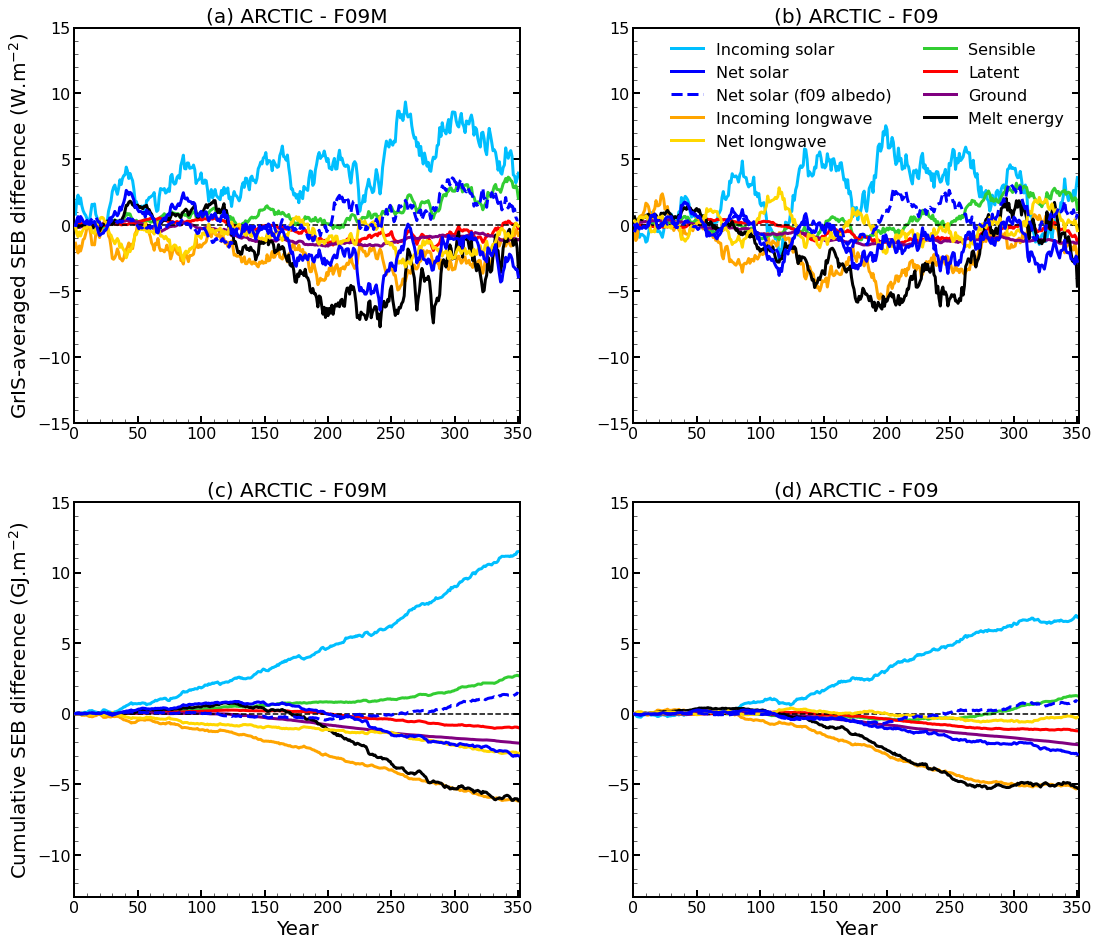

In [72]:
# Change based on initial differences (Only consider 100% ice grids)
fig = plt.figure(figsize = (18,16))
gs=GridSpec(2,11)
plt.rcParams['axes.linewidth'] = 2 #set the value globally

size_tick = 16
size_label = 20
size_legend = 16
size_text = 20

ARCTICf09m_1pctCO2_4xext_avg_SWd_JJA_diffa = ARCTICf09m_1pctCO2_4xext_avg_SWd_JJA_diff - ARCTICf09m_PI_avg_SWd_JJA_diff
ARCTICf09m_1pctCO2_4xext_avg_SWn_JJA_diffa = ARCTICf09m_1pctCO2_4xext_avg_SWn_JJA_diff - ARCTICf09m_PI_avg_SWn_JJA_diff
ARCTICf09m_F09Malbedo_1pctCO2_4xext_avg_SWn_JJA_diffa = ARCTICf09m_F09Malbedo_1pctCO2_4xext_avg_SWn_JJA_diff - ARCTICf09m_F09Malbedo_PI_avg_SWn_JJA_diff
ARCTICf09m_1pctCO2_4xext_avg_LWd_JJA_diffa = ARCTICf09m_1pctCO2_4xext_avg_LWd_JJA_diff - ARCTICf09m_PI_avg_LWd_JJA_diff
ARCTICf09m_1pctCO2_4xext_avg_LWn_JJA_diffa = ARCTICf09m_1pctCO2_4xext_avg_LWn_JJA_diff - ARCTICf09m_PI_avg_LWn_JJA_diff
ARCTICf09m_1pctCO2_4xext_avg_SHF_JJA_diffa = ARCTICf09m_1pctCO2_4xext_avg_SHF_JJA_diff - ARCTICf09m_PI_avg_SHF_JJA_diff
ARCTICf09m_1pctCO2_4xext_avg_LHF_JJA_diffa = ARCTICf09m_1pctCO2_4xext_avg_LHF_JJA_diff - ARCTICf09m_PI_avg_LHF_JJA_diff
ARCTICf09m_1pctCO2_4xext_avg_GHF_JJA_diffa = ARCTICf09m_1pctCO2_4xext_avg_GHF_JJA_diff - ARCTICf09m_PI_avg_GHF_JJA_diff
ARCTICf09m_1pctCO2_4xext_avg_ME_JJA_diffa = ARCTICf09m_1pctCO2_4xext_avg_ME_JJA_diff - ARCTICf09m_PI_avg_ME_JJA_diff

ARCTICf09_1pctCO2_4xext_avg_SWd_JJA_diffa = ARCTICf09_1pctCO2_4xext_avg_SWd_JJA_diff - ARCTICf09_PI_avg_SWd_JJA_diff
ARCTICf09_1pctCO2_4xext_avg_SWn_JJA_diffa = ARCTICf09_1pctCO2_4xext_avg_SWn_JJA_diff - ARCTICf09_PI_avg_SWn_JJA_diff
ARCTICf09_F09albedo_1pctCO2_4xext_avg_SWn_JJA_diffa = ARCTICf09_F09albedo_1pctCO2_4xext_avg_SWn_JJA_diff - ARCTICf09_F09albedo_PI_avg_SWn_JJA_diff
ARCTICf09_1pctCO2_4xext_avg_LWd_JJA_diffa = ARCTICf09_1pctCO2_4xext_avg_LWd_JJA_diff - ARCTICf09_PI_avg_LWd_JJA_diff
ARCTICf09_1pctCO2_4xext_avg_LWn_JJA_diffa = ARCTICf09_1pctCO2_4xext_avg_LWn_JJA_diff - ARCTICf09_PI_avg_LWn_JJA_diff
ARCTICf09_1pctCO2_4xext_avg_SHF_JJA_diffa = ARCTICf09_1pctCO2_4xext_avg_SHF_JJA_diff - ARCTICf09_PI_avg_SHF_JJA_diff
ARCTICf09_1pctCO2_4xext_avg_LHF_JJA_diffa = ARCTICf09_1pctCO2_4xext_avg_LHF_JJA_diff - ARCTICf09_PI_avg_LHF_JJA_diff
ARCTICf09_1pctCO2_4xext_avg_GHF_JJA_diffa = ARCTICf09_1pctCO2_4xext_avg_GHF_JJA_diff - ARCTICf09_PI_avg_GHF_JJA_diff
ARCTICf09_1pctCO2_4xext_avg_ME_JJA_diffa = ARCTICf09_1pctCO2_4xext_avg_ME_JJA_diff - ARCTICf09_PI_avg_ME_JJA_diff

#-------------------------------------------- ARCTIC-F09M --------------------------------------------
ax1 = plt.subplot(gs[0:1,0:5])

#ax1.plot(np.arange(1,351), ARCTICf09m_1pctCO2_4xext_avg_SWd_JJA_diffa, color='deepskyblue', linewidth=1, alpha=0.3)
#ax1.plot(np.arange(1,351), ARCTICf09m_1pctCO2_4xext_avg_SWn_JJA_diffa, color='blue', linewidth=1, alpha=0.3)
#ax1.plot(np.arange(1,351), ARCTICf09m_1pctCO2_4xext_avg_LWd_JJA_diffa, color='orange', linewidth=1, alpha=0.3)
#ax1.plot(np.arange(1,351), ARCTICf09m_1pctCO2_4xext_avg_LWn_JJA_diffa, color='gold', linewidth=1, alpha=0.3)
#ax1.plot(np.arange(1,351), ARCTICf09m_1pctCO2_4xext_avg_SHF_JJA_diffa, color='limegreen', linewidth=1, alpha=0.3)
#ax1.plot(np.arange(1,351), ARCTICf09m_1pctCO2_4xext_avg_LHF_JJA_diffa, color='red', linewidth=1, alpha=0.3)
#ax1.plot(np.arange(1,351), ARCTICf09m_1pctCO2_4xext_avg_GHF_JJA_diffa, color='purple', linewidth=1, alpha=0.3)
#ax1.plot(np.arange(1,351), ARCTICf09m_1pctCO2_4xext_avg_ME_JJA_diffa, color='black', linewidth=1, alpha=0.3)

ARCTICf09m_1pctCO2_4xext_avg_SWd_JJA_diffa_rm = ARCTICf09m_1pctCO2_4xext_avg_SWd_JJA_diffa.rolling(time=20, center=True, min_periods=2).mean()
ARCTICf09m_1pctCO2_4xext_avg_SWn_JJA_diffa_rm = ARCTICf09m_1pctCO2_4xext_avg_SWn_JJA_diffa.rolling(time=20, center=True, min_periods=2).mean()
ARCTICf09m_F09Malbedo_1pctCO2_4xext_avg_SWn_JJA_diffa_rm = ARCTICf09m_F09Malbedo_1pctCO2_4xext_avg_SWn_JJA_diffa.rolling(time=20, center=True, min_periods=2).mean()
ARCTICf09m_1pctCO2_4xext_avg_LWd_JJA_diffa_rm = ARCTICf09m_1pctCO2_4xext_avg_LWd_JJA_diffa.rolling(time=20, center=True, min_periods=2).mean()
ARCTICf09m_1pctCO2_4xext_avg_LWn_JJA_diffa_rm = ARCTICf09m_1pctCO2_4xext_avg_LWn_JJA_diffa.rolling(time=20, center=True, min_periods=2).mean()
ARCTICf09m_1pctCO2_4xext_avg_SHF_JJA_diffa_rm = ARCTICf09m_1pctCO2_4xext_avg_SHF_JJA_diffa.rolling(time=20, center=True, min_periods=2).mean()
ARCTICf09m_1pctCO2_4xext_avg_LHF_JJA_diffa_rm = ARCTICf09m_1pctCO2_4xext_avg_LHF_JJA_diffa.rolling(time=20, center=True, min_periods=2).mean()
ARCTICf09m_1pctCO2_4xext_avg_GHF_JJA_diffa_rm = ARCTICf09m_1pctCO2_4xext_avg_GHF_JJA_diffa.rolling(time=20, center=True, min_periods=2).mean()
ARCTICf09m_1pctCO2_4xext_avg_ME_JJA_diffa_rm = ARCTICf09m_1pctCO2_4xext_avg_ME_JJA_diffa.rolling(time=20, center=True, min_periods=2).mean()

ax1.plot(np.arange(1,351), ARCTICf09m_1pctCO2_4xext_avg_SWd_JJA_diffa_rm, color='deepskyblue', linewidth=3, label='Incoming solar')
ax1.plot(np.arange(1,351), ARCTICf09m_1pctCO2_4xext_avg_SWn_JJA_diffa_rm, color='blue', linewidth=3, label='Net solar', zorder=4)
ax1.plot(np.arange(1,351), ARCTICf09m_F09Malbedo_1pctCO2_4xext_avg_SWn_JJA_diffa_rm, color='blue', linewidth=3, label='Net solar (f09 albedo)', linestyle='--', zorder=5)
ax1.plot(np.arange(1,351), ARCTICf09m_1pctCO2_4xext_avg_LWd_JJA_diffa_rm, color='orange', linewidth=3, label='Incoming longwave')
ax1.plot(np.arange(1,351), ARCTICf09m_1pctCO2_4xext_avg_LWn_JJA_diffa_rm, color='gold', linewidth=3, label='Net longwave', zorder=3)
ax1.plot(np.arange(1,351), ARCTICf09m_1pctCO2_4xext_avg_SHF_JJA_diffa_rm, color='limegreen', linewidth=3, label='Sensible', zorder=2)
ax1.plot(np.arange(1,351), ARCTICf09m_1pctCO2_4xext_avg_LHF_JJA_diffa_rm, color='red', linewidth=3, label='Latent')
ax1.plot(np.arange(1,351), ARCTICf09m_1pctCO2_4xext_avg_GHF_JJA_diffa_rm, color='purple', linewidth=3, label='Ground')
ax1.plot(np.arange(1,351), ARCTICf09m_1pctCO2_4xext_avg_ME_JJA_diffa_rm, color='black', linewidth=3, label='Melt energy')
ax1.hlines(y = 0, xmin = 0, xmax = 350, colors = 'black', linestyles = '--', linewidth = 1.5)

ax1.set_xlim([0, 351])
ax1.set_ylim([-15, 15])
#ax1.set_xlabel('Year', fontsize=size_label)
ax1.set_ylabel('GrIS-averaged SEB difference (W.$\mathregular{m^{-2}}$)', fontsize=size_label)
ax1.xaxis.set_minor_locator(AutoMinorLocator())
ax1.yaxis.set_minor_locator(AutoMinorLocator())
ax1.tick_params(which='major', length=7, width=2, direction='in', right=True, labelright=False)
ax1.tick_params(which='minor', length=4, direction='in', right=True, labelright=False)
ax1.tick_params(labelsize=size_tick)
plt.title('(a) ARCTIC - F09M', fontsize=size_text)

#ax1.legend(loc = 'best', frameon = False, prop={'size':size_legend}, ncol=2)

#-------------------------------------------- ARCTIC-F09 --------------------------------------------
ax2 = plt.subplot(gs[0:1,6:11])

#ax2.plot(np.arange(1,351), ARCTICf09_1pctCO2_4xext_avg_SWd_JJA_diffa, color='deepskyblue', linewidth=1, alpha=0.3)
#ax2.plot(np.arange(1,351), ARCTICf09_1pctCO2_4xext_avg_SWn_JJA_diffa, color='blue', linewidth=1, alpha=0.3)
#ax2.plot(np.arange(1,351), ARCTICf09_1pctCO2_4xext_avg_LWd_JJA_diffa, color='orange', linewidth=1, alpha=0.3)
#ax2.plot(np.arange(1,351), ARCTICf09_1pctCO2_4xext_avg_LWn_JJA_diffa, color='gold', linewidth=1, alpha=0.3)
#ax2.plot(np.arange(1,351), ARCTICf09_1pctCO2_4xext_avg_SHF_JJA_diffa, color='limegreen', linewidth=1, alpha=0.3)
#ax2.plot(np.arange(1,351), ARCTICf09_1pctCO2_4xext_avg_LHF_JJA_diffa, color='red', linewidth=1, alpha=0.3)
#ax2.plot(np.arange(1,351), ARCTICf09_1pctCO2_4xext_avg_GHF_JJA_diffa, color='purple', linewidth=1, alpha=0.3)
#ax2.plot(np.arange(1,351), ARCTICf09_1pctCO2_4xext_avg_ME_JJA_diffa, color='black', linewidth=1, alpha=0.3)

ARCTICf09_1pctCO2_4xext_avg_SWd_JJA_diffa_rm = ARCTICf09_1pctCO2_4xext_avg_SWd_JJA_diffa.rolling(time=20, center=True, min_periods=2).mean()
ARCTICf09_1pctCO2_4xext_avg_SWn_JJA_diffa_rm = ARCTICf09_1pctCO2_4xext_avg_SWn_JJA_diffa.rolling(time=20, center=True, min_periods=2).mean()
ARCTICf09_F09albedo_1pctCO2_4xext_avg_SWn_JJA_diffa_rm = ARCTICf09_F09albedo_1pctCO2_4xext_avg_SWn_JJA_diffa.rolling(time=20, center=True, min_periods=2).mean()
ARCTICf09_1pctCO2_4xext_avg_LWd_JJA_diffa_rm = ARCTICf09_1pctCO2_4xext_avg_LWd_JJA_diffa.rolling(time=20, center=True, min_periods=2).mean()
ARCTICf09_1pctCO2_4xext_avg_LWn_JJA_diffa_rm = ARCTICf09_1pctCO2_4xext_avg_LWn_JJA_diffa.rolling(time=20, center=True, min_periods=2).mean()
ARCTICf09_1pctCO2_4xext_avg_SHF_JJA_diffa_rm = ARCTICf09_1pctCO2_4xext_avg_SHF_JJA_diffa.rolling(time=20, center=True, min_periods=2).mean()
ARCTICf09_1pctCO2_4xext_avg_LHF_JJA_diffa_rm = ARCTICf09_1pctCO2_4xext_avg_LHF_JJA_diffa.rolling(time=20, center=True, min_periods=2).mean()
ARCTICf09_1pctCO2_4xext_avg_GHF_JJA_diffa_rm = ARCTICf09_1pctCO2_4xext_avg_GHF_JJA_diffa.rolling(time=20, center=True, min_periods=2).mean()
ARCTICf09_1pctCO2_4xext_avg_ME_JJA_diffa_rm = ARCTICf09_1pctCO2_4xext_avg_ME_JJA_diffa.rolling(time=20, center=True, min_periods=2).mean()

ax2.plot(np.arange(1,351), ARCTICf09_1pctCO2_4xext_avg_SWd_JJA_diffa_rm, color='deepskyblue', linewidth=3, label='Incoming solar')
ax2.plot(np.arange(1,351), ARCTICf09_1pctCO2_4xext_avg_SWn_JJA_diffa_rm, color='blue', linewidth=3, label='Net solar', zorder=4)
ax2.plot(np.arange(1,351), ARCTICf09_F09albedo_1pctCO2_4xext_avg_SWn_JJA_diffa_rm, color='blue', linewidth=3, label='Net solar (f09 albedo)', linestyle='--', zorder=5)
ax2.plot(np.arange(1,351), ARCTICf09_1pctCO2_4xext_avg_LWd_JJA_diffa_rm, color='orange', linewidth=3, label='Incoming longwave')
ax2.plot(np.arange(1,351), ARCTICf09_1pctCO2_4xext_avg_LWn_JJA_diffa_rm, color='gold', linewidth=3, label='Net longwave', zorder=3)
ax2.plot(np.arange(1,351), ARCTICf09_1pctCO2_4xext_avg_SHF_JJA_diffa_rm, color='limegreen', linewidth=3, label='Sensible', zorder=2)
ax2.plot(np.arange(1,351), ARCTICf09_1pctCO2_4xext_avg_LHF_JJA_diffa_rm, color='red', linewidth=3, label='Latent')
ax2.plot(np.arange(1,351), ARCTICf09_1pctCO2_4xext_avg_GHF_JJA_diffa_rm, color='purple', linewidth=3, label='Ground')
ax2.plot(np.arange(1,351), ARCTICf09_1pctCO2_4xext_avg_ME_JJA_diffa_rm, color='black', linewidth=3, label='Melt energy')
ax2.hlines(y = 0, xmin = 0, xmax = 350, colors = 'black', linestyles = '--', linewidth = 1.5)

ax2.set_xlim([0, 351])
ax2.set_ylim([-15, 15])
#ax2.set_xlabel('Year', fontsize=size_label)
#ax2.set_ylabel('GrIS-averaged SEB difference (W.$\mathregular{m^{-2}}$)', fontsize=size_label)
ax2.xaxis.set_minor_locator(AutoMinorLocator())
ax2.yaxis.set_minor_locator(AutoMinorLocator())
ax2.tick_params(which='major', length=7, width=2, direction='in', right=True, labelright=False)
ax2.tick_params(which='minor', length=4, direction='in', right=True, labelright=False)
ax2.tick_params(labelsize=size_tick)
plt.title('(b) ARCTIC - F09', fontsize=size_text)

ax2.legend(loc = 'best', frameon = False, prop={'size':size_legend}, ncol=2)

#-------------------------------------------- ARCTIC-F09M accumulated --------------------------------------------
ax3 = plt.subplot(gs[1:2,0:5])

ax3.plot(np.arange(1,351), ARCTICf09m_1pctCO2_4xext_avg_SWd_JJA_diffa.cumsum()*(92*24*3600)/1e9, color='deepskyblue', linewidth=3, label='Incoming solar')
ax3.plot(np.arange(1,351), ARCTICf09m_1pctCO2_4xext_avg_SWn_JJA_diffa.cumsum()*(92*24*3600)/1e9, color='blue', linewidth=3, label='Net solar', zorder=4)
ax3.plot(np.arange(1,351), ARCTICf09m_F09Malbedo_1pctCO2_4xext_avg_SWn_JJA_diffa.cumsum()*(92*24*3600)/1e9, color='blue', linewidth=3, label='Net solar (f09 albedo)', linestyle='--', zorder=5)
ax3.plot(np.arange(1,351), ARCTICf09m_1pctCO2_4xext_avg_LWd_JJA_diffa.cumsum()*(92*24*3600)/1e9, color='orange', linewidth=3, label='Incoming longwave')
ax3.plot(np.arange(1,351), ARCTICf09m_1pctCO2_4xext_avg_LWn_JJA_diffa.cumsum()*(92*24*3600)/1e9, color='gold', linewidth=3, label='Net longwave', zorder=3)
ax3.plot(np.arange(1,351), ARCTICf09m_1pctCO2_4xext_avg_SHF_JJA_diffa.cumsum()*(92*24*3600)/1e9, color='limegreen', linewidth=3, label='Sensible', zorder=2)
ax3.plot(np.arange(1,351), ARCTICf09m_1pctCO2_4xext_avg_LHF_JJA_diffa.cumsum()*(92*24*3600)/1e9, color='red', linewidth=3, label='Latent')
ax3.plot(np.arange(1,351), ARCTICf09m_1pctCO2_4xext_avg_GHF_JJA_diffa.cumsum()*(92*24*3600)/1e9, color='purple', linewidth=3, label='Ground')
ax3.plot(np.arange(1,351), ARCTICf09m_1pctCO2_4xext_avg_ME_JJA_diffa.cumsum()*(92*24*3600)/1e9, color='black', linewidth=3, label='Melt energy')
ax3.hlines(y = 0, xmin = 0, xmax = 350, colors = 'black', linestyles = '--', linewidth = 1.5)

ax3.set_xlim([0, 351])
ax3.set_ylim([-13, 15])
ax3.set_xlabel('Year', fontsize=size_label)
ax3.set_ylabel('Cumulative SEB difference (GJ.$\mathregular{m^{-2}}$)', fontsize=size_label)
ax3.xaxis.set_minor_locator(AutoMinorLocator())
ax3.yaxis.set_minor_locator(AutoMinorLocator())
ax3.tick_params(which='major', length=7, width=2, direction='in', right=True, labelright=False)
ax3.tick_params(which='minor', length=4, direction='in', right=True, labelright=False)
ax3.tick_params(labelsize=size_tick)
plt.title('(c) ARCTIC - F09M', fontsize=size_text)

#-------------------------------------------- ARCTIC-F09 accumulated --------------------------------------------
ax4 = plt.subplot(gs[1:2,6:11])

ax4.plot(np.arange(1,351), ARCTICf09_1pctCO2_4xext_avg_SWd_JJA_diffa.cumsum()*(92*24*3600)/1e9, color='deepskyblue', linewidth=3, label='Incoming solar')
ax4.plot(np.arange(1,351), ARCTICf09_1pctCO2_4xext_avg_SWn_JJA_diffa.cumsum()*(92*24*3600)/1e9, color='blue', linewidth=3, label='Net solar', zorder=4)
ax4.plot(np.arange(1,351), ARCTICf09_F09albedo_1pctCO2_4xext_avg_SWn_JJA_diffa.cumsum()*(92*24*3600)/1e9, color='blue', linewidth=3, label='Net solar (f09 albedo)', linestyle='--', zorder=5)
ax4.plot(np.arange(1,351), ARCTICf09_1pctCO2_4xext_avg_LWd_JJA_diffa.cumsum()*(92*24*3600)/1e9, color='orange', linewidth=3, label='Incoming longwave')
ax4.plot(np.arange(1,351), ARCTICf09_1pctCO2_4xext_avg_LWn_JJA_diffa.cumsum()*(92*24*3600)/1e9, color='gold', linewidth=3, label='Net longwave', zorder=3)
ax4.plot(np.arange(1,351), ARCTICf09_1pctCO2_4xext_avg_SHF_JJA_diffa.cumsum()*(92*24*3600)/1e9, color='limegreen', linewidth=3, label='Sensible', zorder=2)
ax4.plot(np.arange(1,351), ARCTICf09_1pctCO2_4xext_avg_LHF_JJA_diffa.cumsum()*(92*24*3600)/1e9, color='red', linewidth=3, label='Latent')
ax4.plot(np.arange(1,351), ARCTICf09_1pctCO2_4xext_avg_GHF_JJA_diffa.cumsum()*(92*24*3600)/1e9, color='purple', linewidth=3, label='Ground')
ax4.plot(np.arange(1,351), ARCTICf09_1pctCO2_4xext_avg_ME_JJA_diffa.cumsum()*(92*24*3600)/1e9, color='black', linewidth=3, label='Melt energy')
ax4.hlines(y = 0, xmin = 0, xmax = 350, colors = 'black', linestyles = '--', linewidth = 1.5)

ax4.set_xlim([0, 351])
ax4.set_ylim([-13, 15])
ax4.set_xlabel('Year', fontsize=size_label)
#ax4.set_ylabel('Cumulative SEB difference (W.$\mathregular{m^{-2}}$)', fontsize=size_label)
ax4.xaxis.set_minor_locator(AutoMinorLocator())
ax4.yaxis.set_minor_locator(AutoMinorLocator())
ax4.tick_params(which='major', length=7, width=2, direction='in', right=True, labelright=False)
ax4.tick_params(which='minor', length=4, direction='in', right=True, labelright=False)
ax4.tick_params(labelsize=size_tick)
plt.title('(d) ARCTIC - F09', fontsize=size_text)

plt.subplots_adjust(wspace=0.28)
plt.savefig(home_dir+'2022-VR-dynamic-GrIS/github/plot/tseries_SEB_anomaly_cumanomaly_ARCTICf09mf09_comparedtoPI30_coralbedo_allice.png', dpi=300, bbox_inches='tight', facecolor='w', transparent=False) #